In [5]:
from pytorch_toolbelt.utils import fs

#predicted_scenes_paths = [
#    "../runs/211111_11_32_b2_unet_s4_leaky_valid_4fold_rfl_bce_mse_regularized_d4_medium_fold0/checkpoints_metrics_all_aggregate/valid/step1536/0d8ed29b0760dc59v.npz",
#]
predicted_scenes_paths = fs.find_in_dir_with_ext(
    "../runs/211111_11_32_b2_unet_s4_leaky_valid_4fold_rfl_bce_mse_regularized_d4_medium_fold0/checkpoints_metrics_all_aggregate/valid/step1536", ".npz"
)
predicted_scenes = list(map(fs.id_from_fname, predicted_scenes_paths))
print("Scenes", len(predicted_scenes))

Scenes 12


In [6]:
groundtruth = pd.read_csv("../data/validation.csv")
groundtruth=groundtruth[groundtruth.scene_id.isin(predicted_scenes)].reset_index()

In [18]:
shore_root="../data/full"
objectness_thresholds = [0.45, 0.475, 0.4875, 0.5, 0.5125, 0.525, 0.55]

In [19]:
from pytorch_toolbelt.utils import to_numpy
import collections
import torch
from xview3 import CENTERNET_OUTPUT_OBJECTNESS_MAP, MultilabelCircleNetDecodeResult, XView3DataModule

from xview3 import CENTERNET_OUTPUT_VESSEL_MAP

from xview3 import CENTERNET_OUTPUT_FISHING_MAP

from xview3 import CENTERNET_OUTPUT_SIZE

from xview3 import CENTERNET_OUTPUT_OFFSET


def decode_predictions(scene_paths, box_coder:MultilabelCircleNetCoder,
                       objectness_thresholds_lower_bound=0.3,
                       apply_activation=False, max_objects=2048):
    predictions = collections.defaultdict(list)
    for path in scene_paths:
        scene_id = fs.id_from_fname(path)
        saved_predictions = np.load(path, allow_pickle=True)
        outputs = dict(
            CENTERNET_OUTPUT_OBJECTNESS_MAP=torch.from_numpy(saved_predictions[CENTERNET_OUTPUT_OBJECTNESS_MAP]),
            CENTERNET_OUTPUT_VESSEL_MAP=torch.from_numpy(saved_predictions[CENTERNET_OUTPUT_VESSEL_MAP]),
            CENTERNET_OUTPUT_FISHING_MAP=torch.from_numpy(saved_predictions[CENTERNET_OUTPUT_FISHING_MAP]),
            CENTERNET_OUTPUT_SIZE=torch.from_numpy(saved_predictions[CENTERNET_OUTPUT_SIZE]),
            CENTERNET_OUTPUT_OFFSET=torch.from_numpy(saved_predictions[CENTERNET_OUTPUT_OFFSET])
            if CENTERNET_OUTPUT_OFFSET in saved_predictions
            else None,
        )

        preds: MultilabelCircleNetDecodeResult = box_coder.decode(
            objectness_map=outputs[CENTERNET_OUTPUT_OBJECTNESS_MAP],
            is_vessel_map=outputs[CENTERNET_OUTPUT_VESSEL_MAP],
            is_fishing_map=outputs[CENTERNET_OUTPUT_FISHING_MAP],
            length_map=outputs[CENTERNET_OUTPUT_SIZE],
            offset_map=outputs.get(CENTERNET_OUTPUT_OFFSET, None),
            apply_activation=apply_activation,
            max_objects=max_objects,
        )

        pos_mask = preds.scores[0] >= objectness_thresholds_lower_bound

        centers = to_numpy(preds.centers[0][pos_mask]).astype(int)
        scores = to_numpy(preds.scores[0, pos_mask]).astype(np.float32)
        lengths = XView3DataModule.decode_lengths(preds.lengths[0, pos_mask])

        is_vessel_prob = to_numpy(preds.is_vessel[0, pos_mask]).astype(np.float32)
        is_fishing_prob = to_numpy(preds.is_fishing[0, pos_mask]).astype(np.float32)

        for (
            (detect_scene_column, detect_scene_row),
            objectness_score,
            is_vessel_p,
            is_fishing_p,
            vessel_length_m,
        ) in zip(centers, scores, is_vessel_prob, is_fishing_prob, lengths):
            predictions["vessel_length_m"].append(vessel_length_m)
            predictions["detect_scene_row"].append(detect_scene_row)
            predictions["detect_scene_column"].append(detect_scene_column)
            predictions["scene_id"].append(scene_id)
            # Scores
            predictions["objectness_p"].append(objectness_score)
            predictions["is_vessel_p"].append(is_vessel_p)
            predictions["is_fishing_p"].append(is_fishing_p)
            # Thresholds
            predictions["objectness_threshold"].append(objectness_thresholds_lower_bound)

    predictions = pd.DataFrame.from_dict(predictions)
    return predictions

In [20]:
import itertools
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder


def summarize(df, objectness_threshold):
    view = df[df.objectness_threshold==objectness_threshold].copy()
    is_vessel_threshold = LabelEncoder()
    is_fishing_threshold = LabelEncoder()
    view["is_vessel_threshold"] = is_vessel_threshold.fit_transform(view["is_vessel_threshold"])
    view["is_fishing_threshold"] = is_fishing_threshold.fit_transform(view["is_fishing_threshold"])
    matrix = np.zeros((
        len(is_vessel_threshold.classes_),
        len(is_fishing_threshold.classes_)
    ))

    for i, row in view.iterrows():
        value = row["aggregate"]
        matrix[int(row["is_vessel_threshold"]), int(row["is_fishing_threshold"])] = value

    return matrix, is_vessel_threshold.classes_, is_fishing_threshold.classes_

def plot_visualizations(df):
    for obj in sorted(df.objectness_threshold.unique()):
        matrix, vessel_thresholds, fishing_thresholds = summarize(df, obj)

        plt.figure(figsize=(18,18))
        plt.matshow(matrix)
        plt.xticks(range(len(vessel_thresholds)), ["{0:.2f}".format(float(x)) for x in vessel_thresholds], rotation=45)
        plt.xlabel("vessel_thresholds")
        plt.yticks(range(len(fishing_thresholds)),  ["{0:.2f}".format(float(x)) for x in fishing_thresholds])
        plt.xlabel("fishing_thresholds")

        ymax, xmax = np.unravel_index(np.argmax(matrix), matrix.shape)
        text= "vessel={:.3f}, fishing={:.3f} aggregate={:.3f}".format(vessel_thresholds[xmax], fishing_thresholds[ymax], matrix.max())

        # if not ax:
        #     ax=plt.gca()

        bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
        arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
        kw = dict(xycoords='data',textcoords="axes fraction",
                  arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
        plt.annotate(text, xy=(xmax, ymax), xytext=(0.94,0.96), **kw)

        # if True:
        #     fmt = ".3f"
        #     thresh = (matrix.max() + matrix.min()) / 2.0
        #     for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        #         if np.isfinite(matrix[i, j]):
        #
        #             if matrix[i, j] == matrix.max():
        #                 plt.axvline(x=vessel_thresholds[i])
        #                 plt.axhline(y=fishing_thresholds[j])
        #
        #                 plt.axvline(x=i)
        #                 plt.axhline(y=j)
        #
        #                 plt.text(
        #                     j,
        #                     i,
        #                     format(matrix[i, j], fmt),
        #                     horizontalalignment="center",
        #                     fontsize=6,
        #                     color="white" if matrix[i, j] > thresh else "black",
        #                 )

        plt.colorbar()
        plt.title(f"Objectness threshold {obj}")
        plt.tight_layout()
        plt.show()


plt.rcParams['figure.figsize'] = [12, 12]
plt.rcParams['figure.dpi'] = 200 # 200 e.g. is really fine, but slower

In [21]:
from xview3 import compute_optimal_thresholds
from xview3.constants import IGNORE_LABEL

In [22]:
vanilla_box_coder = MultilabelCircleNetCoder(
    (2048,2048), output_stride=4, max_objects=2048, heatmap_encoding="umich", labels_encoding="circle", ignore_value=IGNORE_LABEL,
    fixed_radius=3,
    labels_radius=3,
    nms_method=centernet_heatmap_nms,
    nms_kernel_size=3)

vanilla_predictions = decode_predictions(predicted_scenes_paths, vanilla_box_coder)
centernet_heatmap_nms_ks_3 = compute_optimal_thresholds(
    predictions=vanilla_predictions,
    groundtruths=groundtruth,
    shore_root=shore_root,
    objectness_thresholds=objectness_thresholds,
)
centernet_heatmap_nms_ks_3.to_csv("centernet_heatmap_nms_ks_3", index=False)

Computing optimal vessel & fishing thresholds:   0%|          | 0/7 [00:00<?, ?it/s]

Computing optimal thresholds
objectness_thresholds [0.45   0.475  0.4875 0.5    0.5125 0.525  0.55  ]


Computing optimal vessel & fishing thresholds: 100%|██████████| 7/7 [04:30<00:00, 38.65s/it] 


<ipython-input-20-488284eb5ea1>:70: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



<Figure size 3600x3600 with 0 Axes>

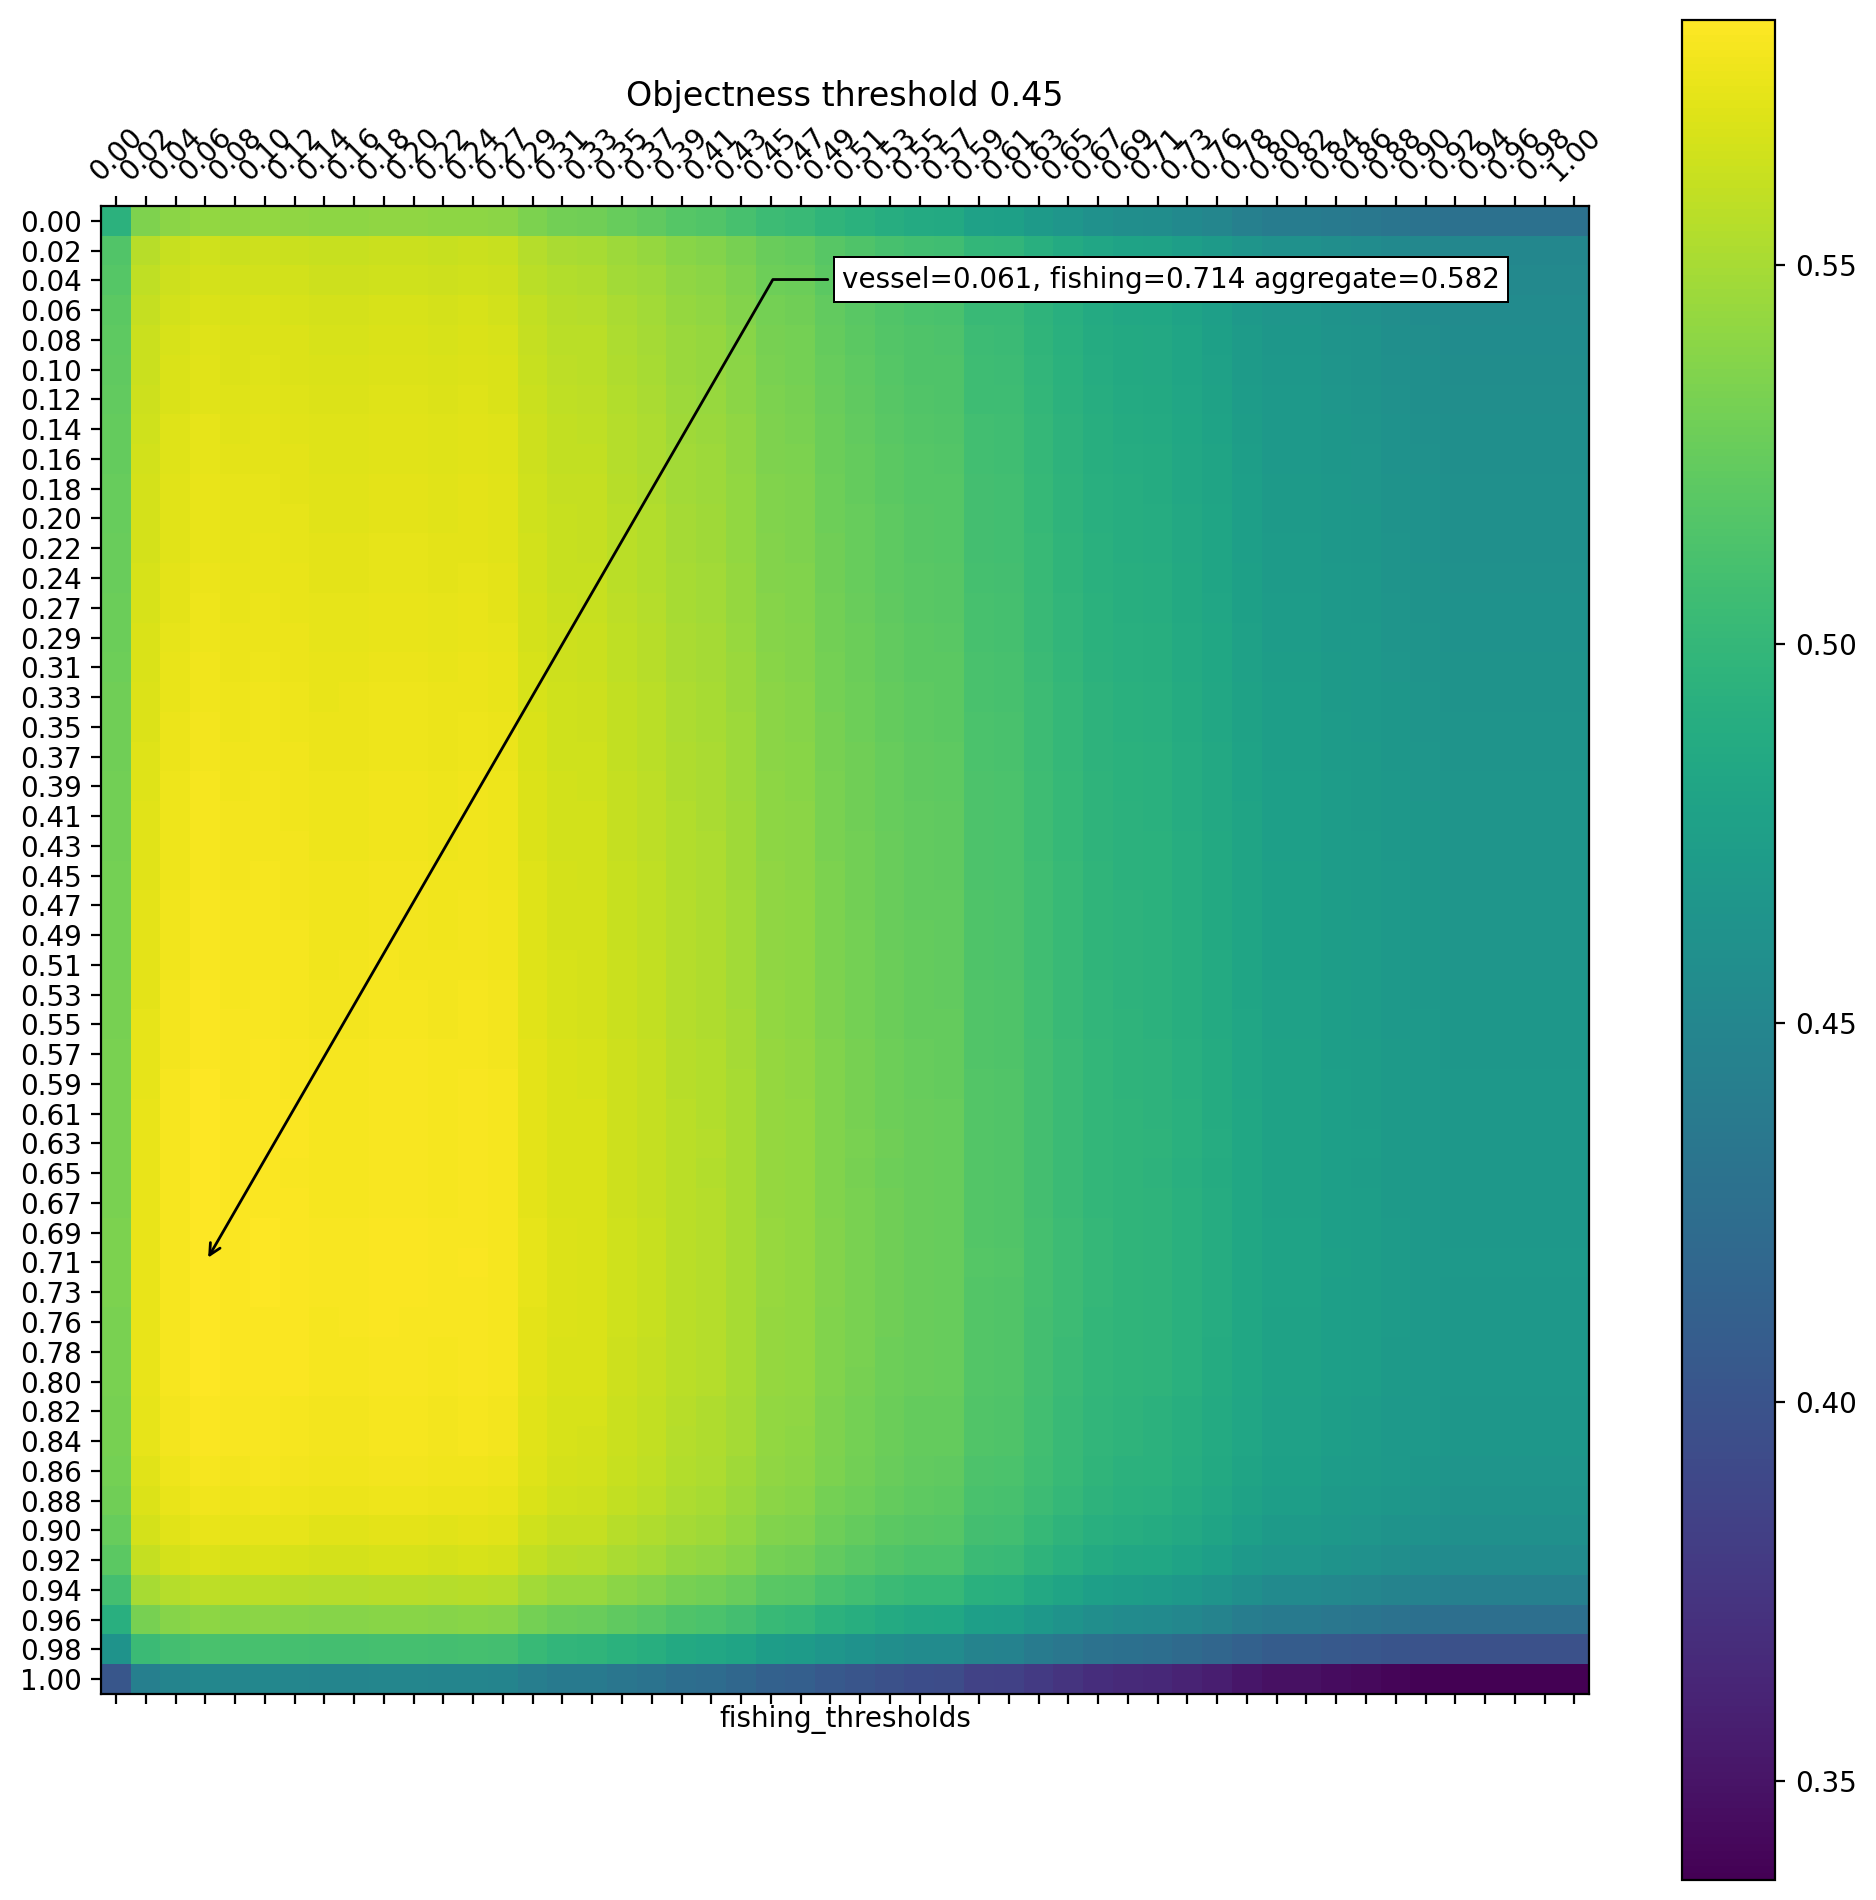

<ipython-input-20-488284eb5ea1>:70: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



<Figure size 3600x3600 with 0 Axes>

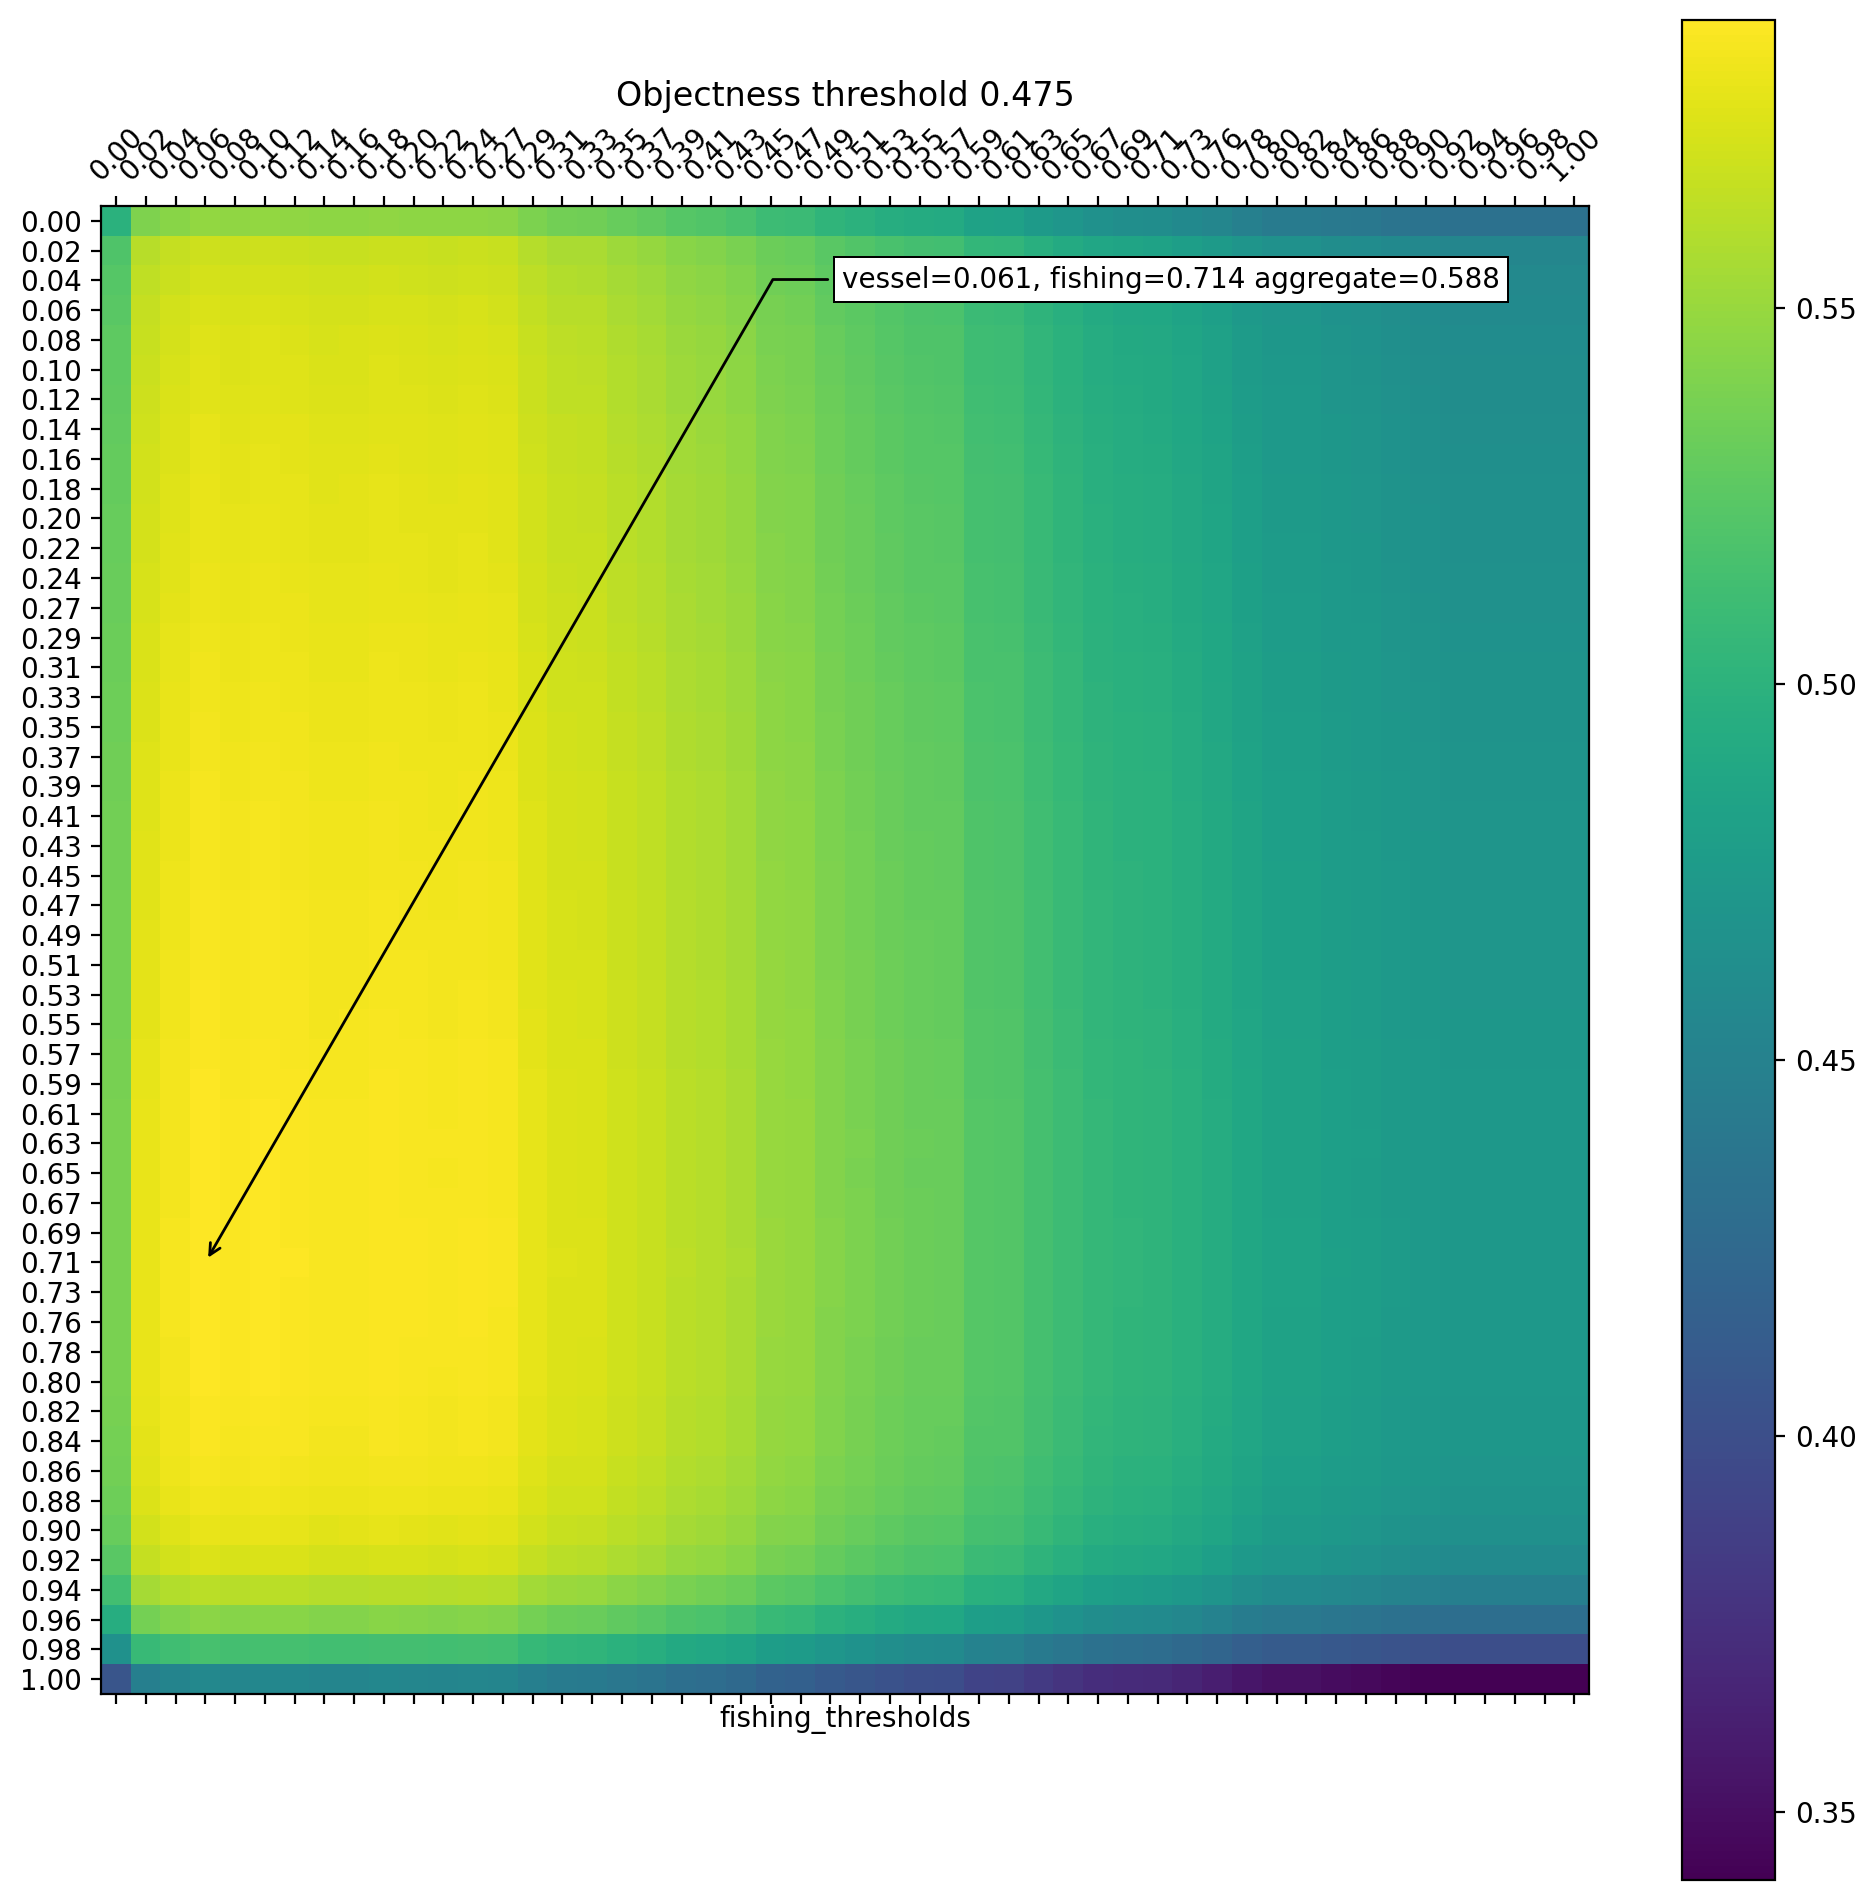

<ipython-input-20-488284eb5ea1>:70: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



<Figure size 3600x3600 with 0 Axes>

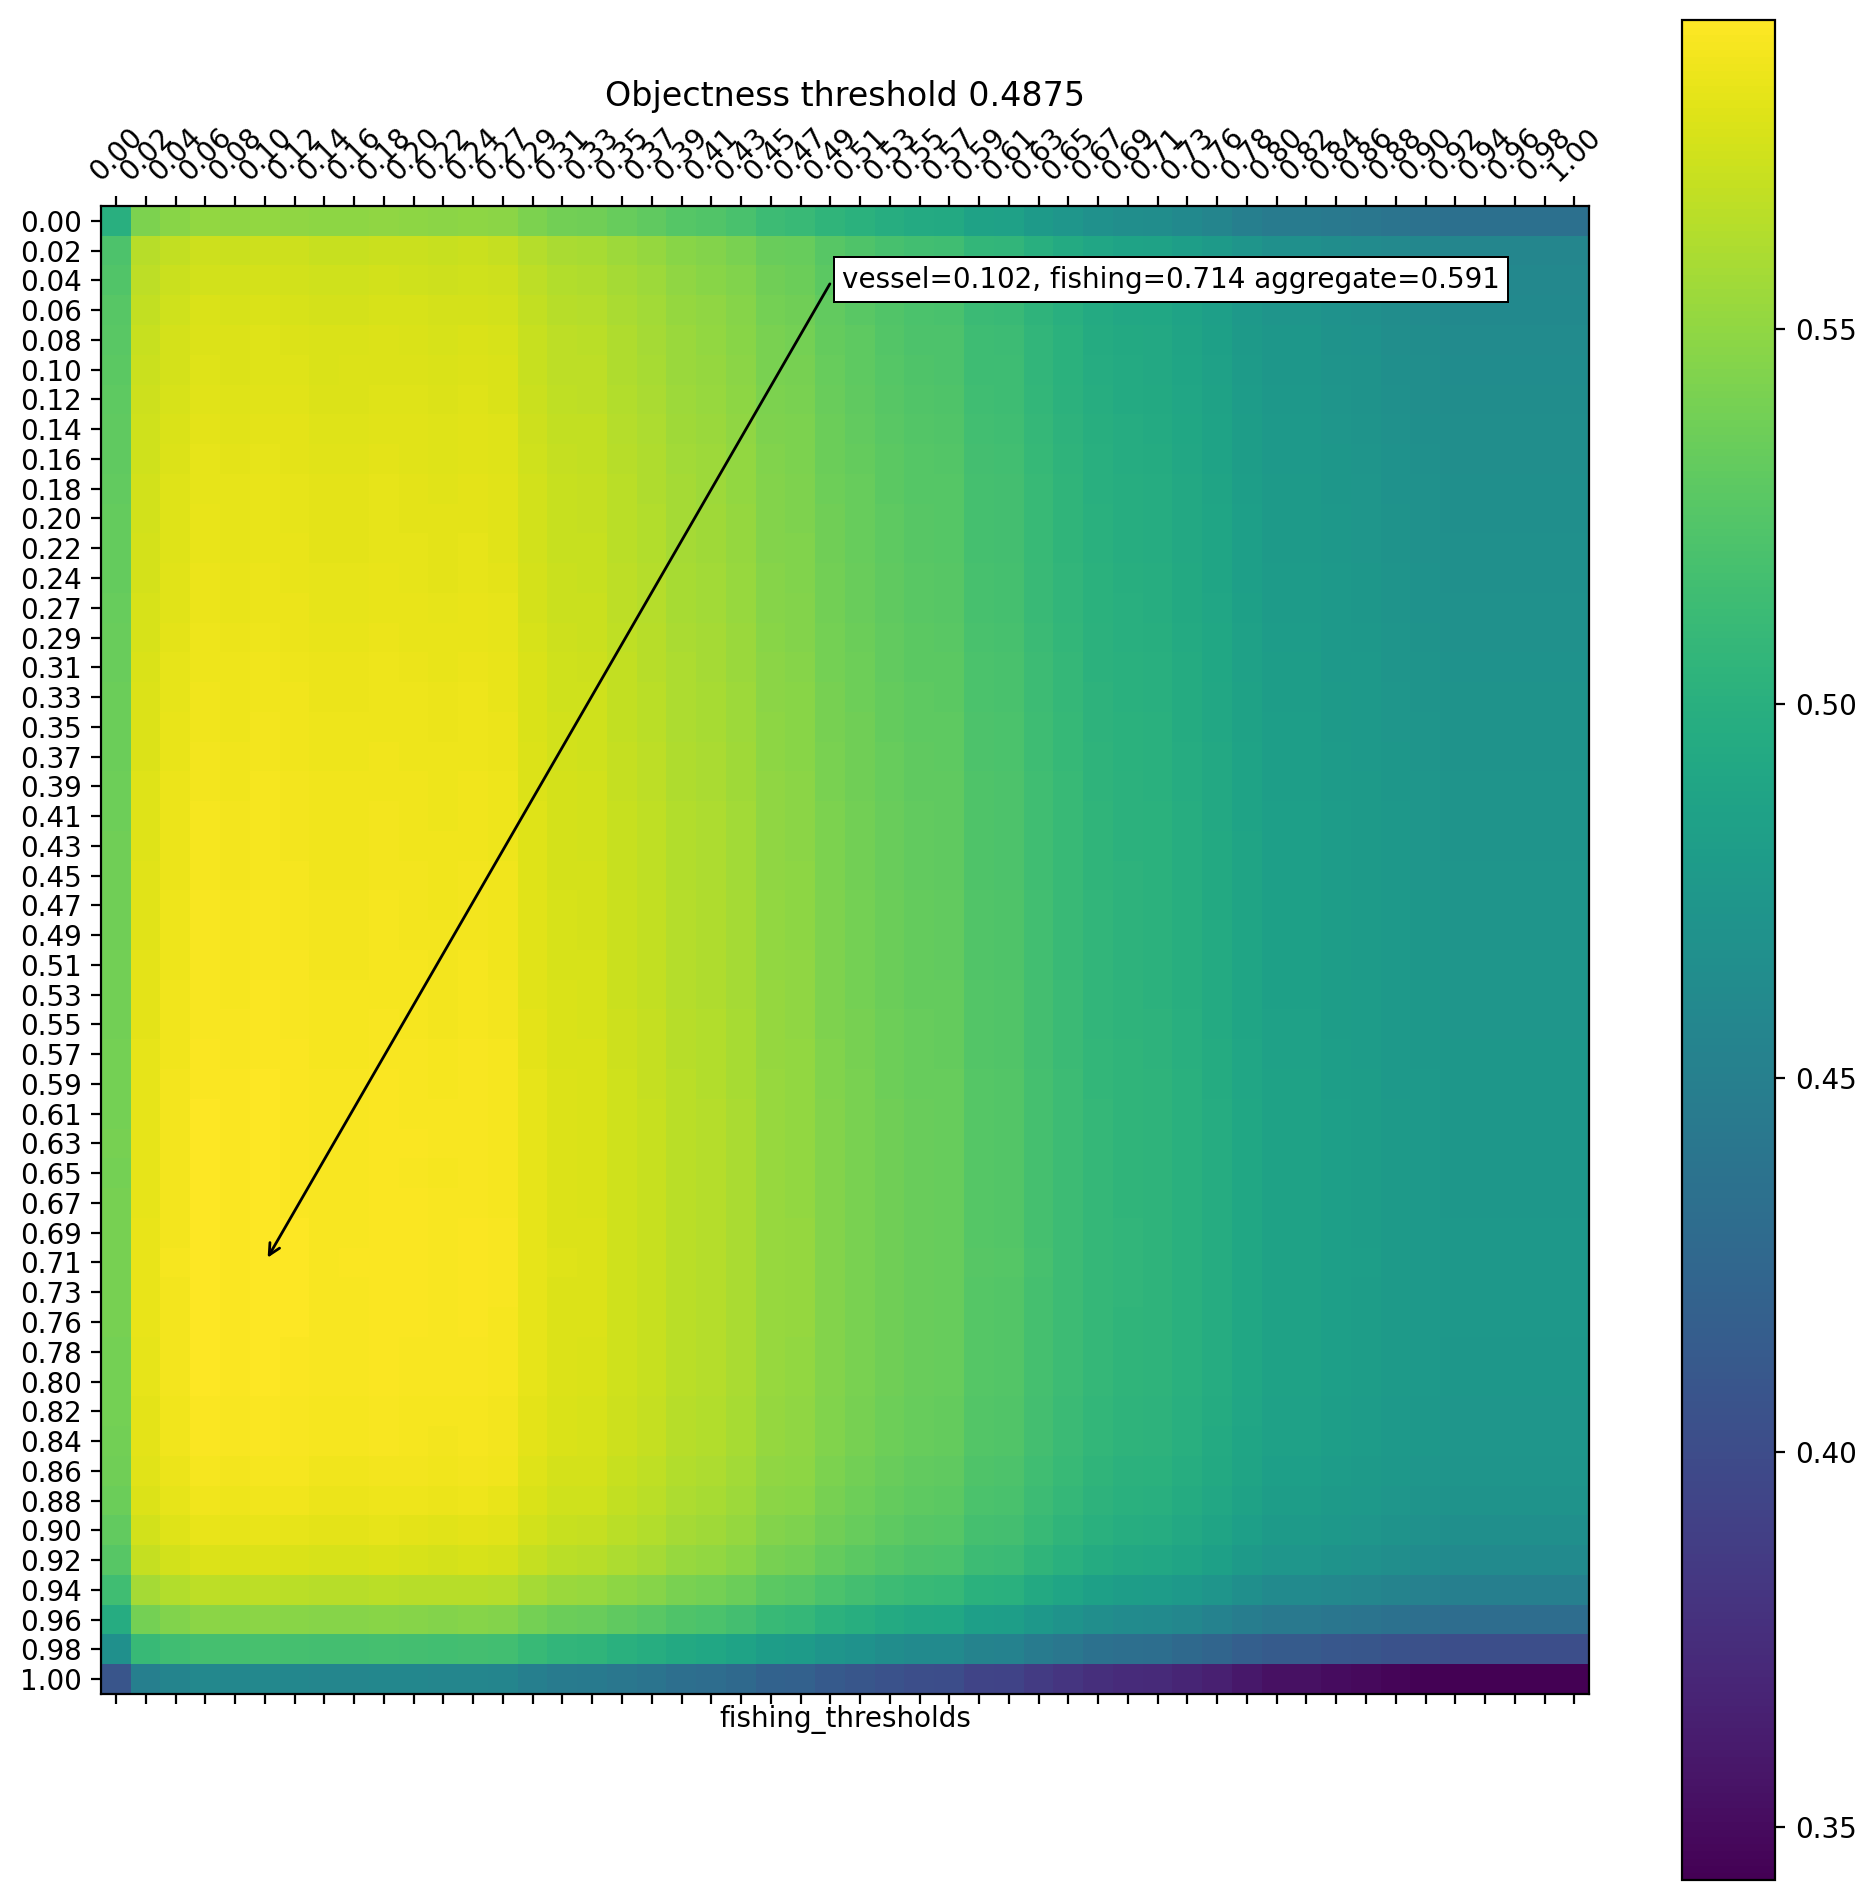

<ipython-input-20-488284eb5ea1>:70: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



<Figure size 3600x3600 with 0 Axes>

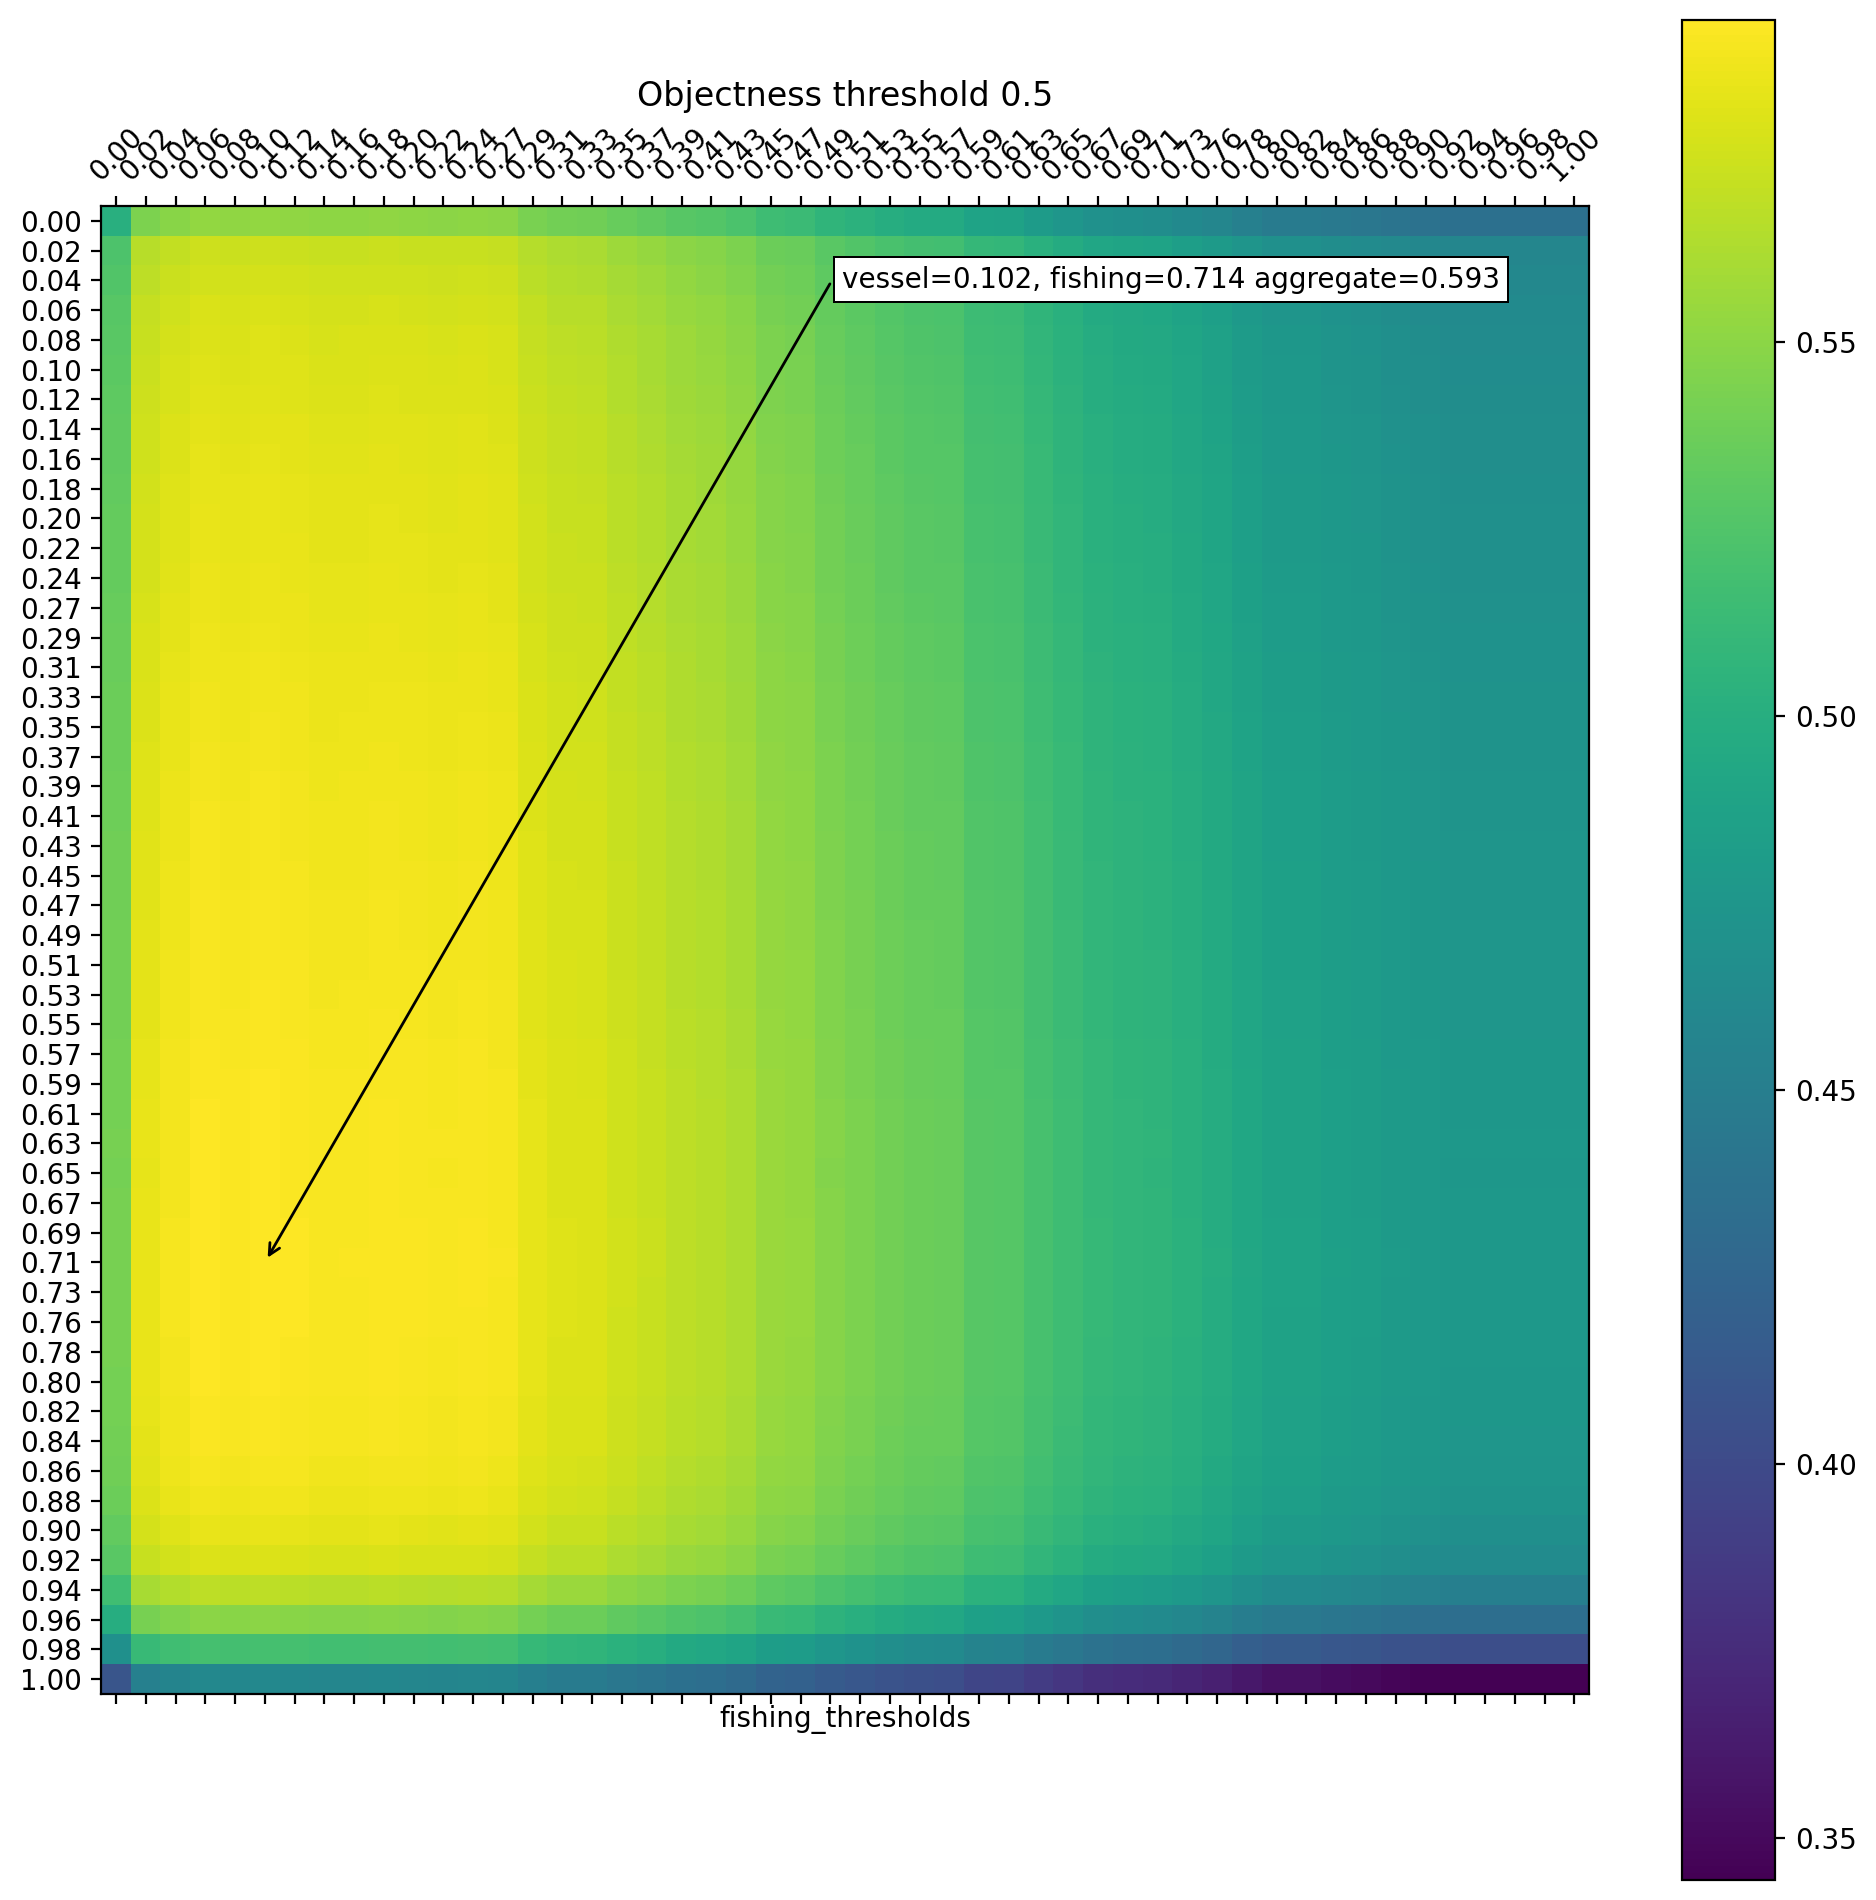

<ipython-input-20-488284eb5ea1>:70: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



<Figure size 3600x3600 with 0 Axes>

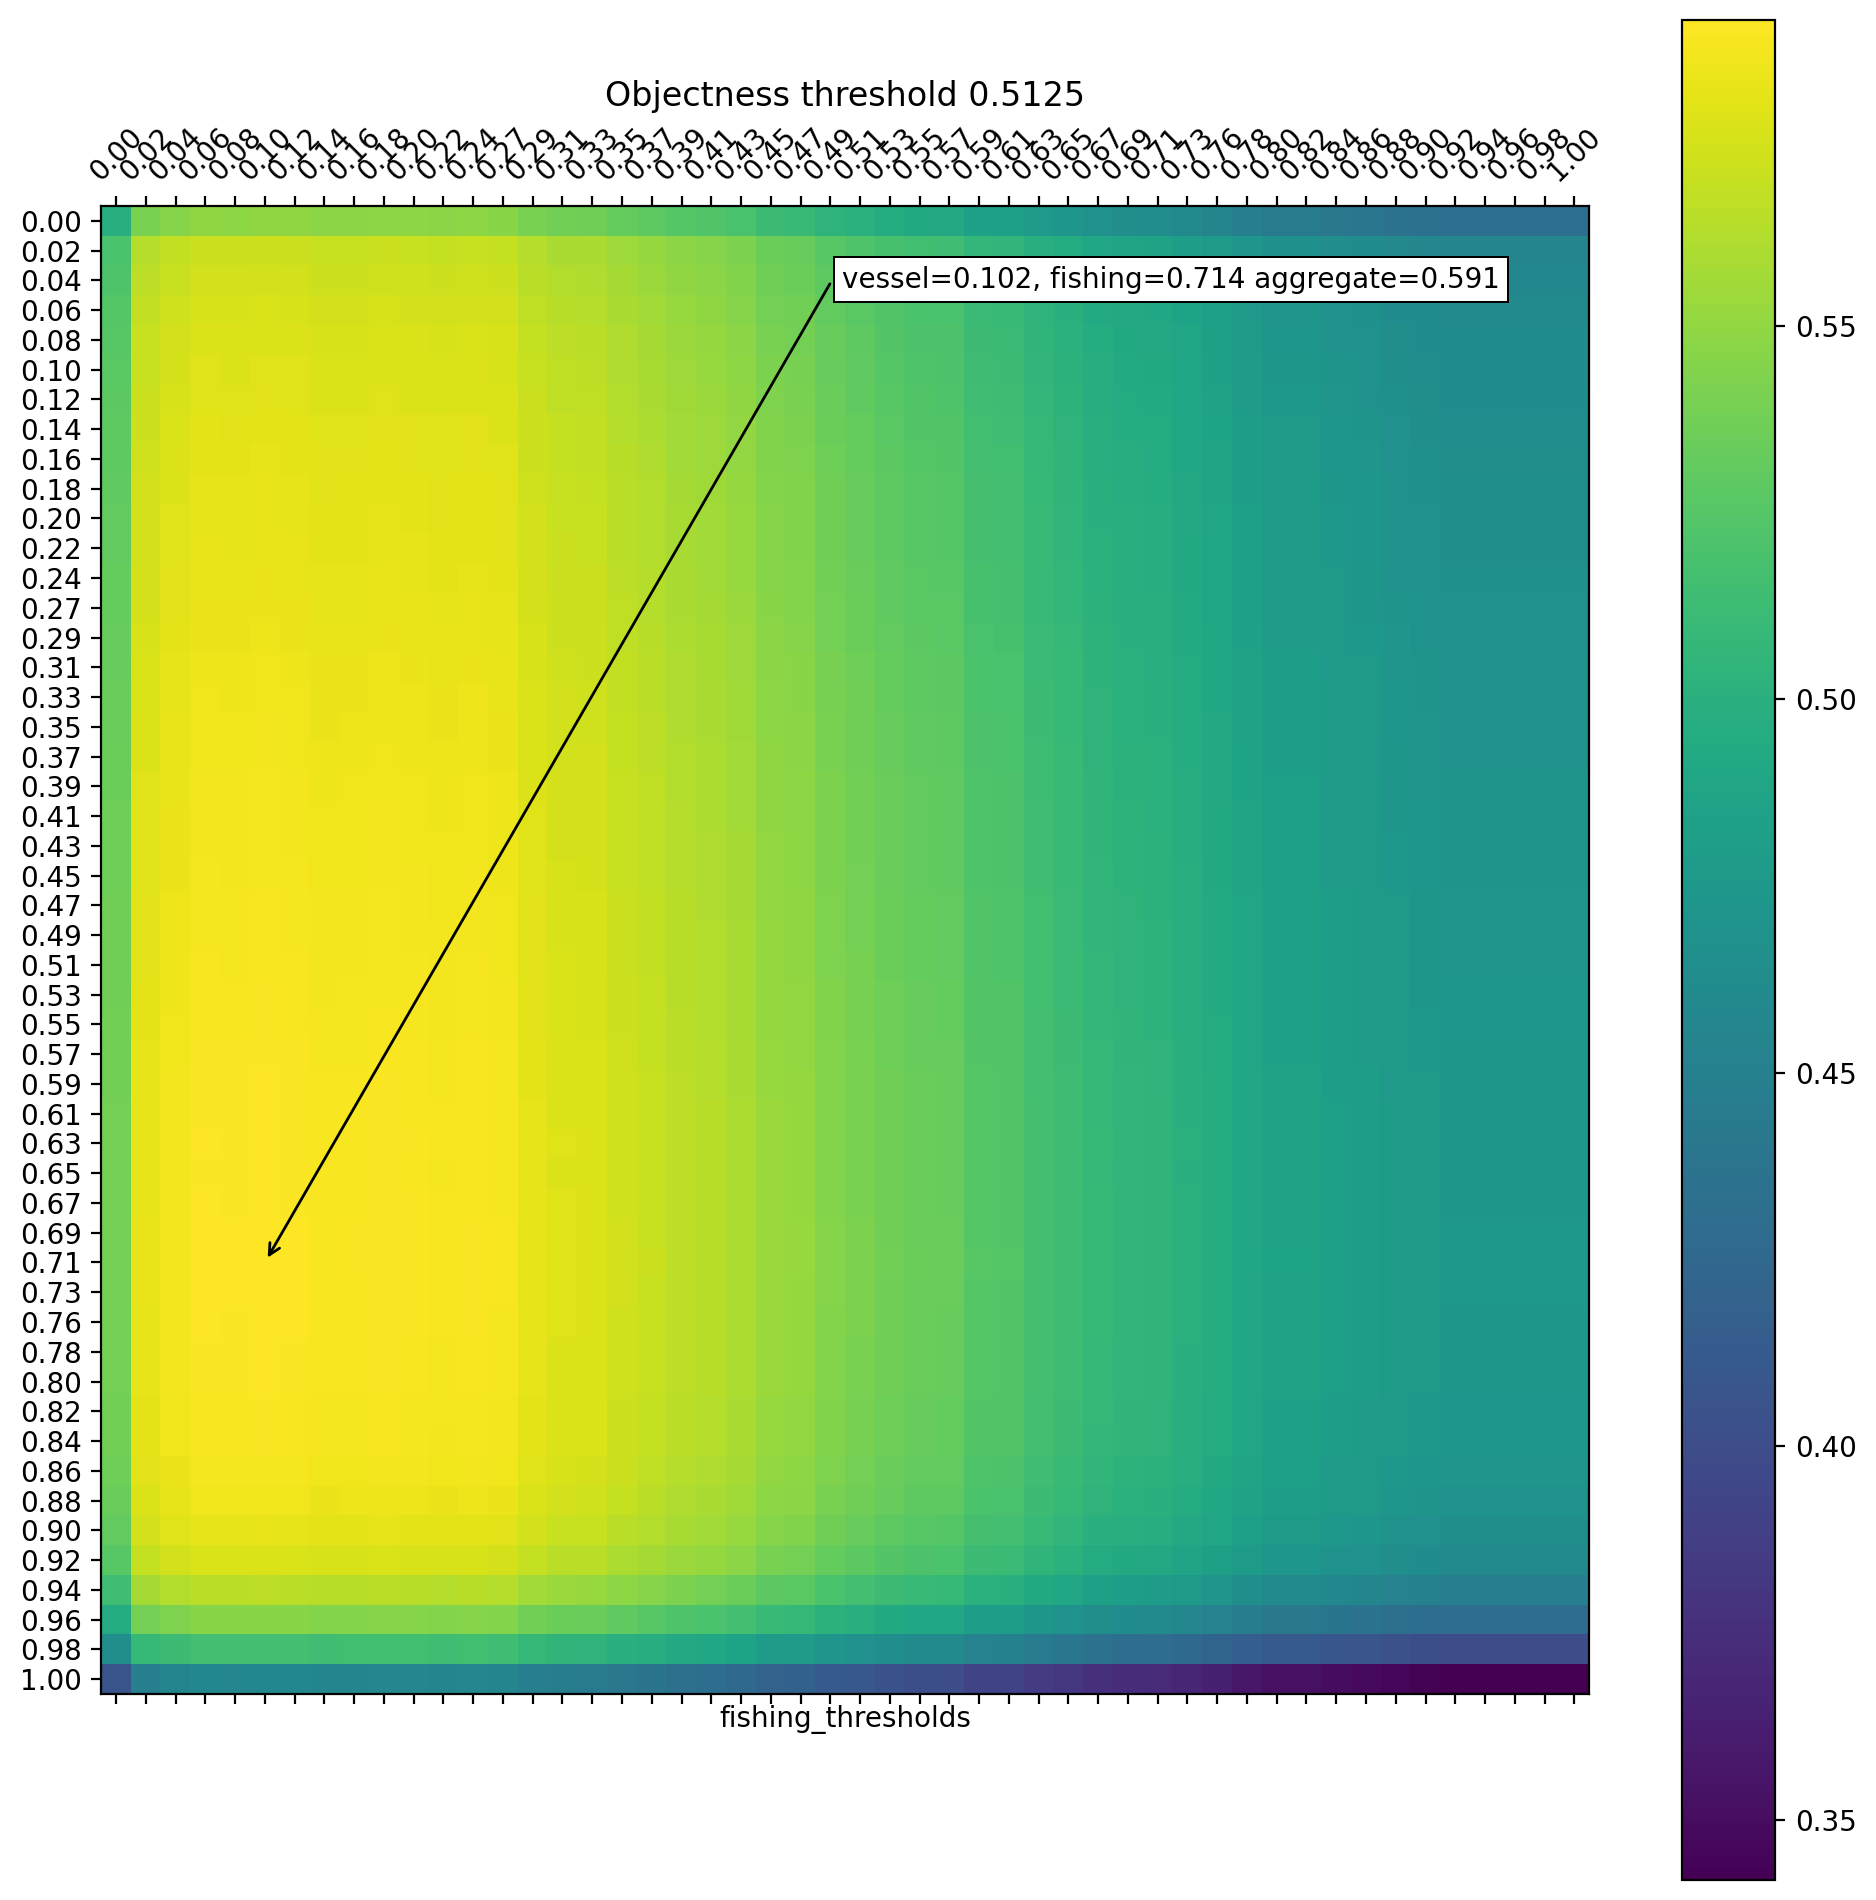

<ipython-input-20-488284eb5ea1>:70: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



<Figure size 3600x3600 with 0 Axes>

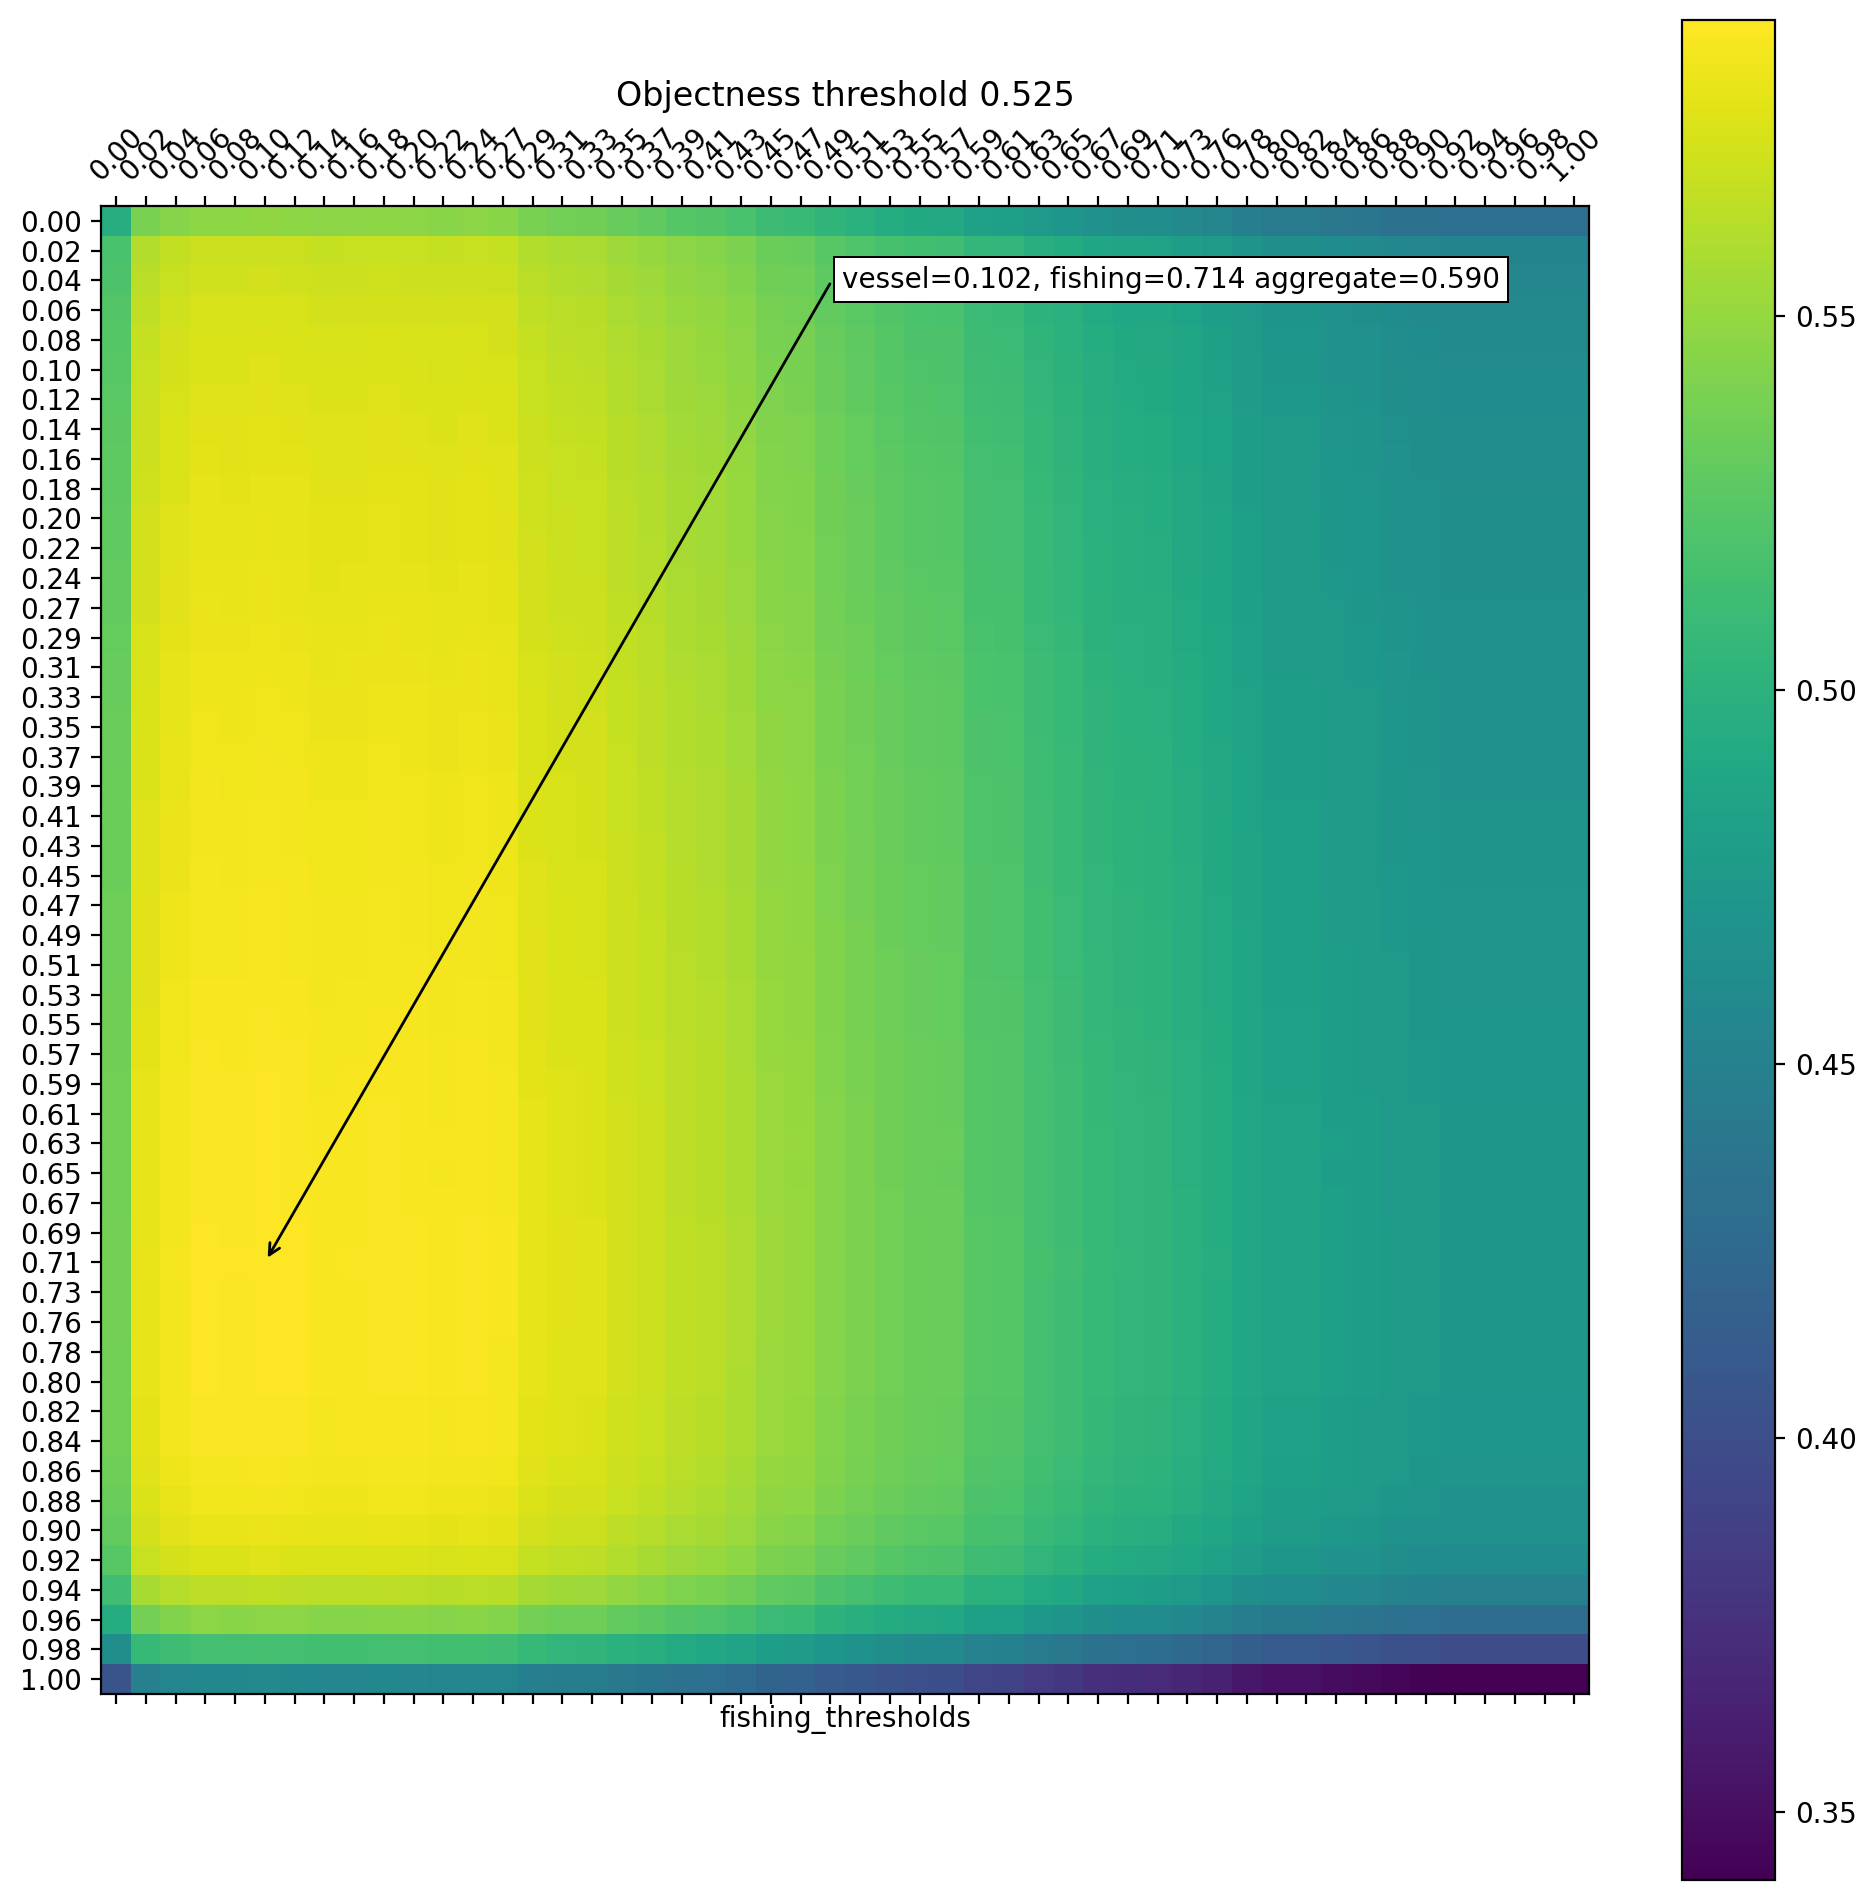

<ipython-input-20-488284eb5ea1>:70: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



<Figure size 3600x3600 with 0 Axes>

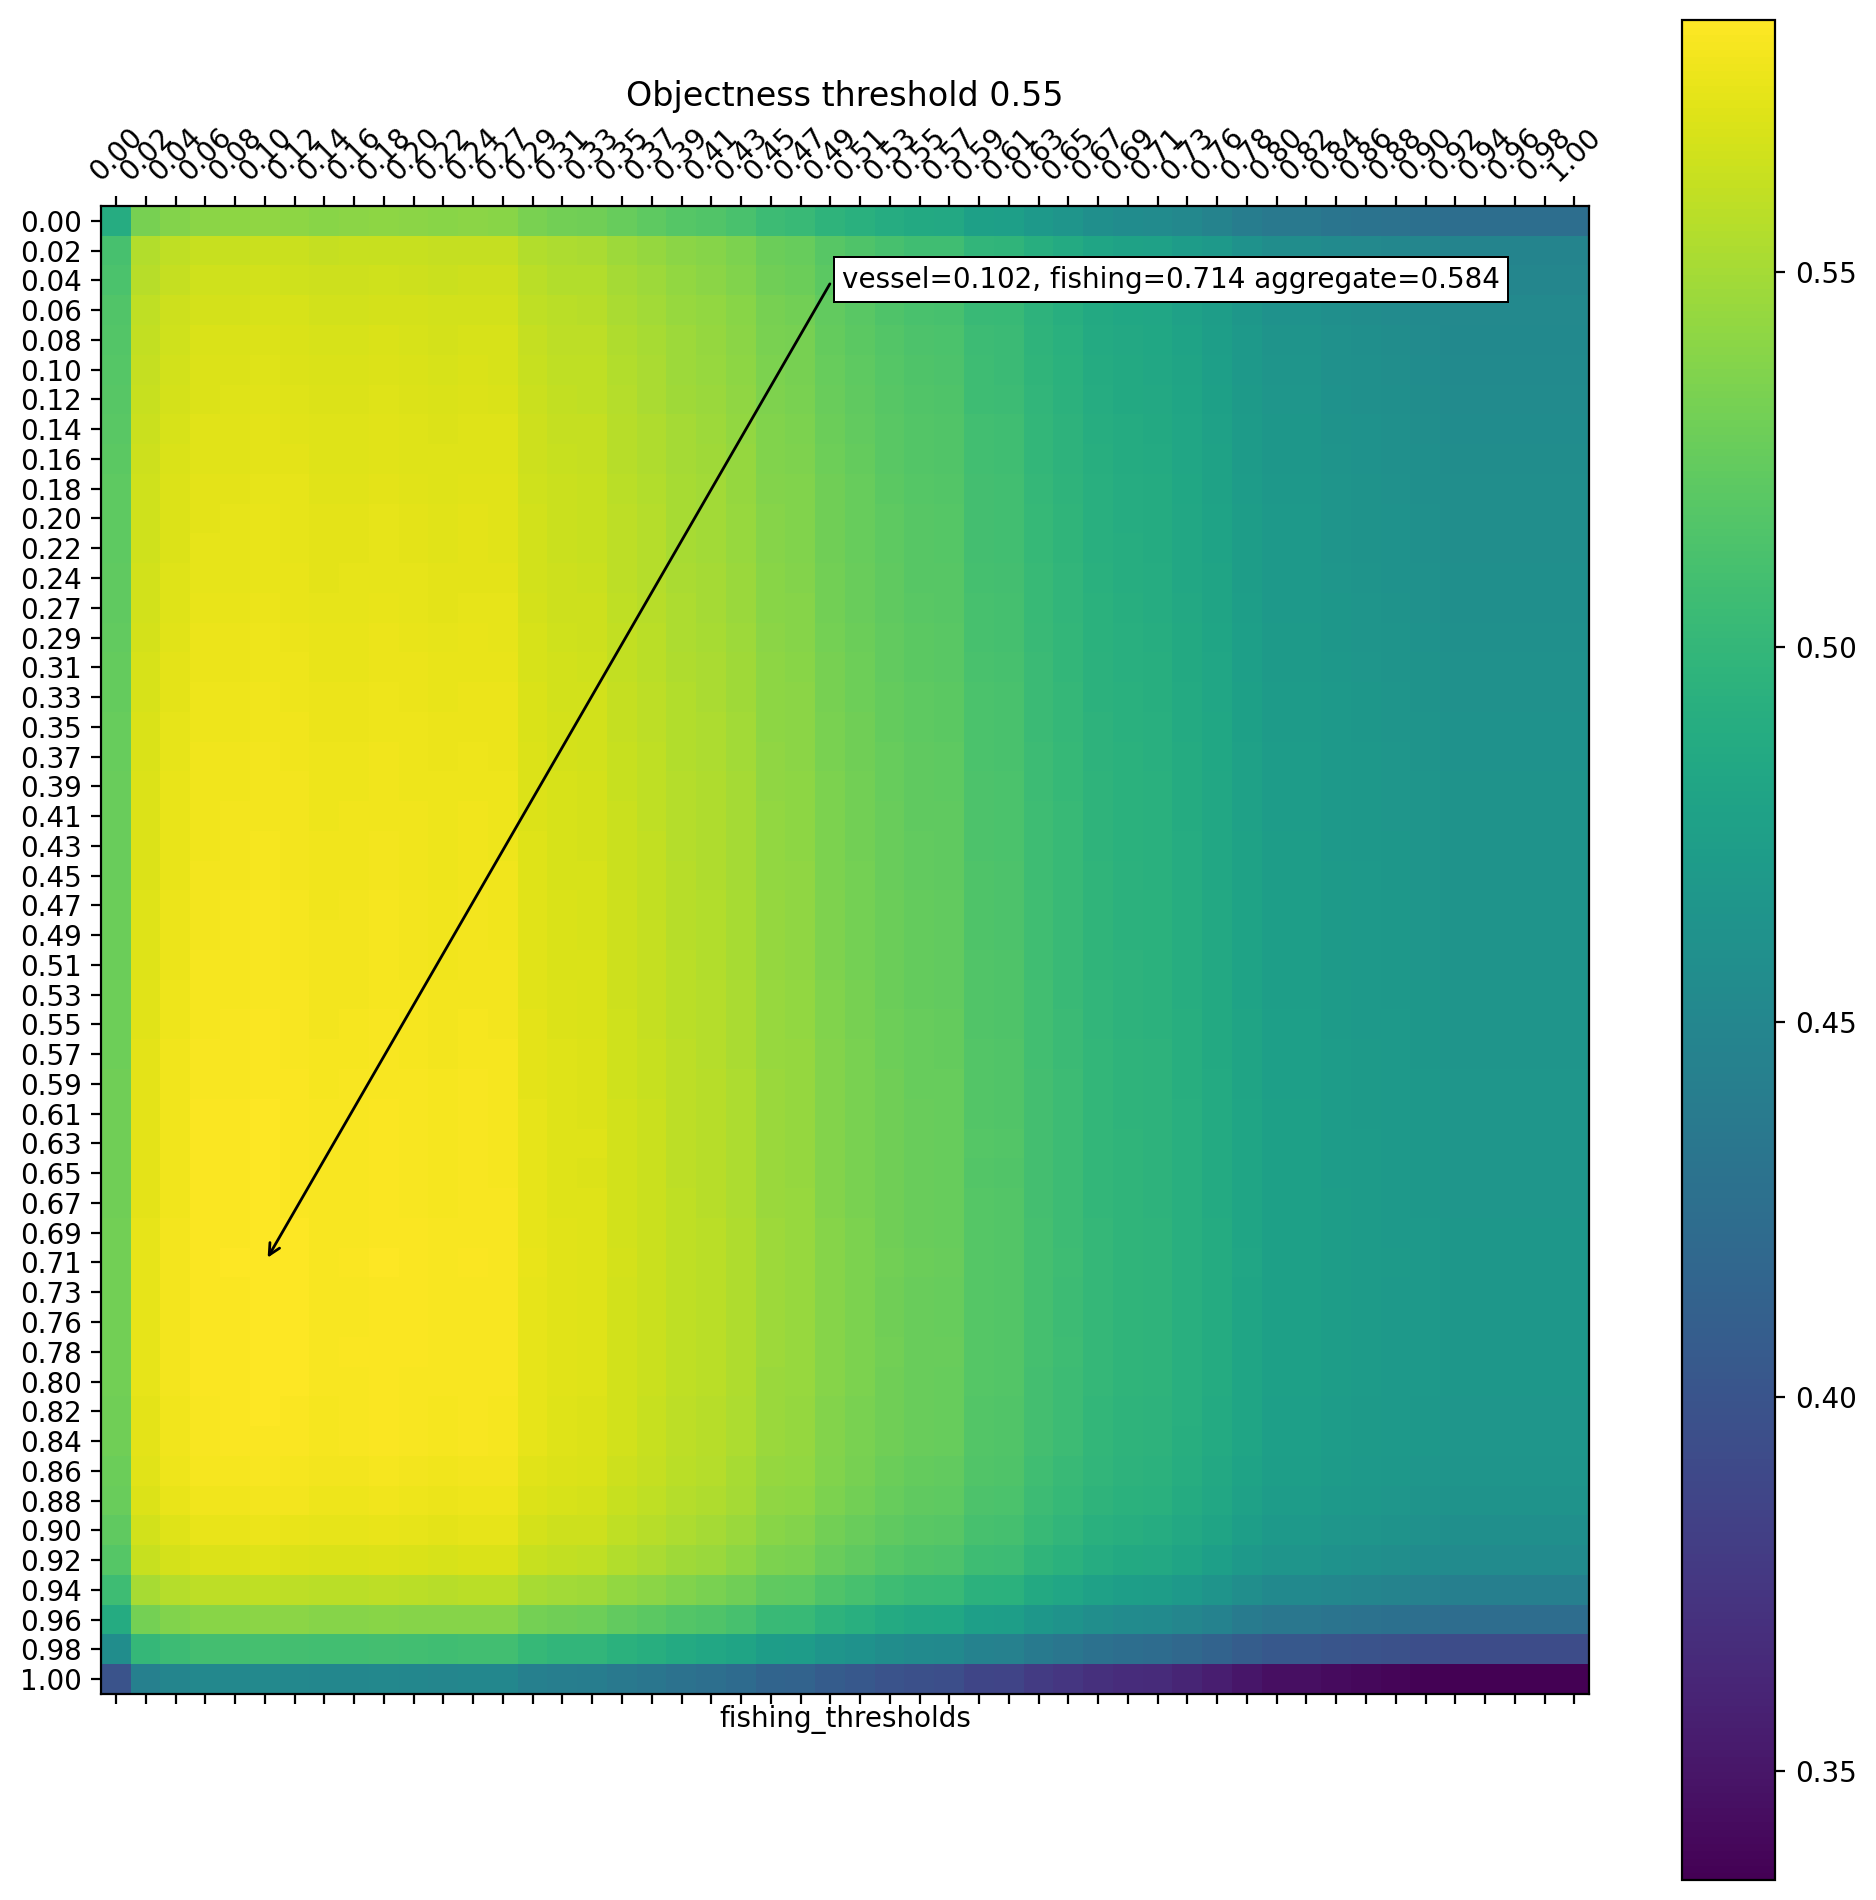

loc_fscore  loc_fscore_shore  vessel_fscore  fishing_fscore  length_acc  \
1755    0.799654          0.471729       0.880184        0.725389     0.63118   
1705    0.799654          0.471729       0.879422        0.725389     0.63118   
1805    0.799654          0.471729       0.879350        0.725389     0.63118   
1753    0.799654          0.471729       0.880184        0.723898     0.63118   
1855    0.799654          0.471729       0.878563        0.725389     0.63118   
1703    0.799654          0.471729       0.879422        0.723898     0.63118   
1803    0.799654          0.471729       0.879350        0.723898     0.63118   
1555    0.799654          0.471729       0.877376        0.725389     0.63118   
1655    0.799654          0.471729       0.877312        0.725389     0.63118   
1853    0.799654          0.471729       0.878563        0.723898     0.63118   
1905    0.799654          0.471729       0.876972        0.725389     0.63118   
1955    0.799654          0.471729       0.876745        0.725389     0.63118   
1505    0.799654          0.471729       0.876621        0.725389     0.63118   
1605    0.799654          0.471729       0.876455        0.725389     0.63118   
1756    0.799654          0.471729       0.880184        0.721485     0.63118   
1553    0.799654          0.471729       0.877376        0.723898     0.63118   
1653    0.799654          0.471729       0.877312        0.723898     0.63118   
1706    0.799654          0.471729       0.879422        0.721485     0.63118   
1903    0.799654          0.471729       0.876972        0.723898     0.63118   
1806    0.799654          0.471729       0.879350        0.721485     0.63118   

      aggregate  is_vessel_threshold  is_fishing_threshold  \
1755   0.593101             0.714286              0.102041   
1705   0.592979             0.693878              0.102041   
1805   0.592967             0.734694              0.102041   
1753   0.592862             0.714286              0.061224   
1855   0.592841             0.755102              0.102041   
1703   0.592740             0.693878              0.061224   
1803   0.592729             0.734694              0.061224   
1555   0.592652             0.632653              0.102041   
1655   0.592641             0.673469              0.102041   
1853   0.592603             0.755102              0.061224   
1905   0.592587             0.775510              0.102041   
1955   0.592551             0.795918              0.102041   
1505   0.592531             0.612245              0.102041   
1605   0.592504             0.653061              0.102041   
1756   0.592476             0.714286              0.122449   
1553   0.592413             0.632653              0.061224   
1653   0.592403             0.673469              0.061224   
1706   0.592355             0.693878              0.122449   
1903   0.592348             0.775510              0.061224   
1806   0.592343             0.734694              0.122449   

      objectness_threshold  
1755                   0.5  
1705                   0.5  
1805                   0.5  
1753                   0.5  
1855                   0.5  
1703                   0.5  
1803                   0.5  
1555                   0.5  
1655                   0.5  
1853                   0.5  
1905                   0.5  
1955                   0.5  
1505                   0.5  
1605                   0.5  
1756                   0.5  
1553                   0.5  
1653                   0.5  
1706                   0.5  
1903                   0.5  
1806                   0.5

In [23]:
plot_visualizations(centernet_heatmap_nms_ks_3)
centernet_heatmap_nms_ks_3.head(20)

Computing optimal vessel & fishing thresholds:   0%|          | 0/7 [00:00<?, ?it/s]

Computing optimal thresholds
objectness_thresholds [0.45   0.475  0.4875 0.5    0.5125 0.525  0.55  ]


Computing optimal vessel & fishing thresholds: 100%|██████████| 7/7 [04:33<00:00, 39.12s/it] 
<ipython-input-20-488284eb5ea1>:70: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



<Figure size 3600x3600 with 0 Axes>

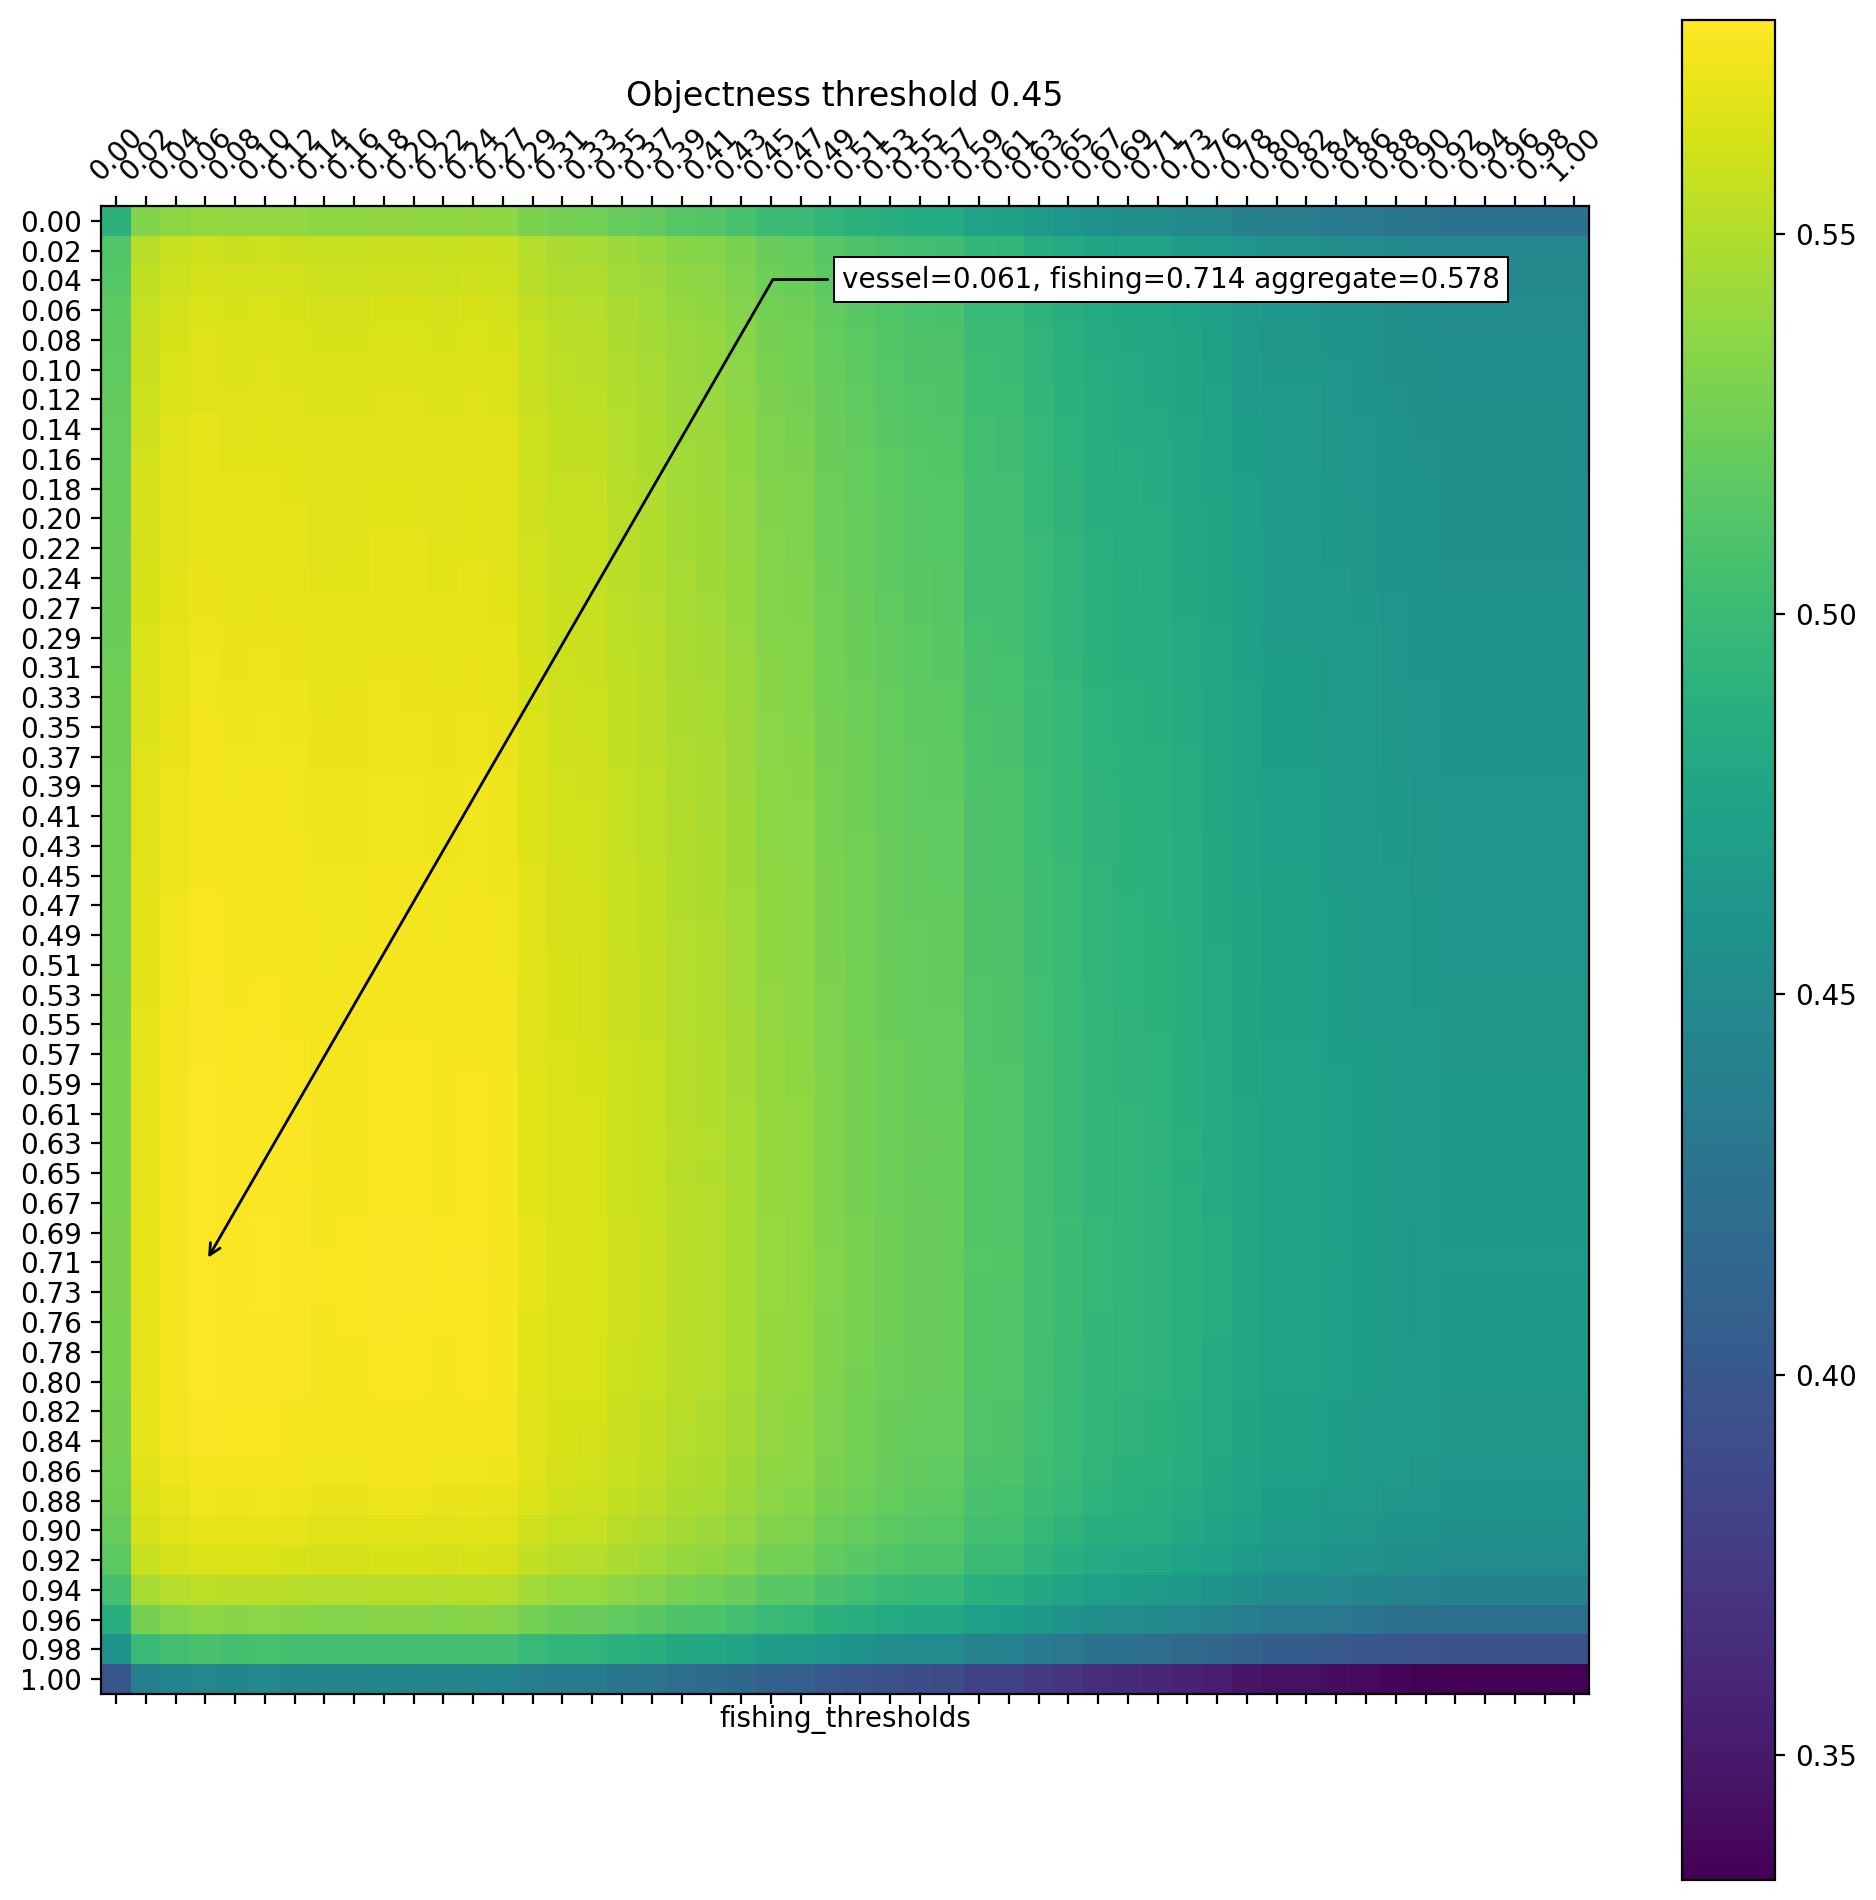

<ipython-input-20-488284eb5ea1>:70: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



<Figure size 3600x3600 with 0 Axes>

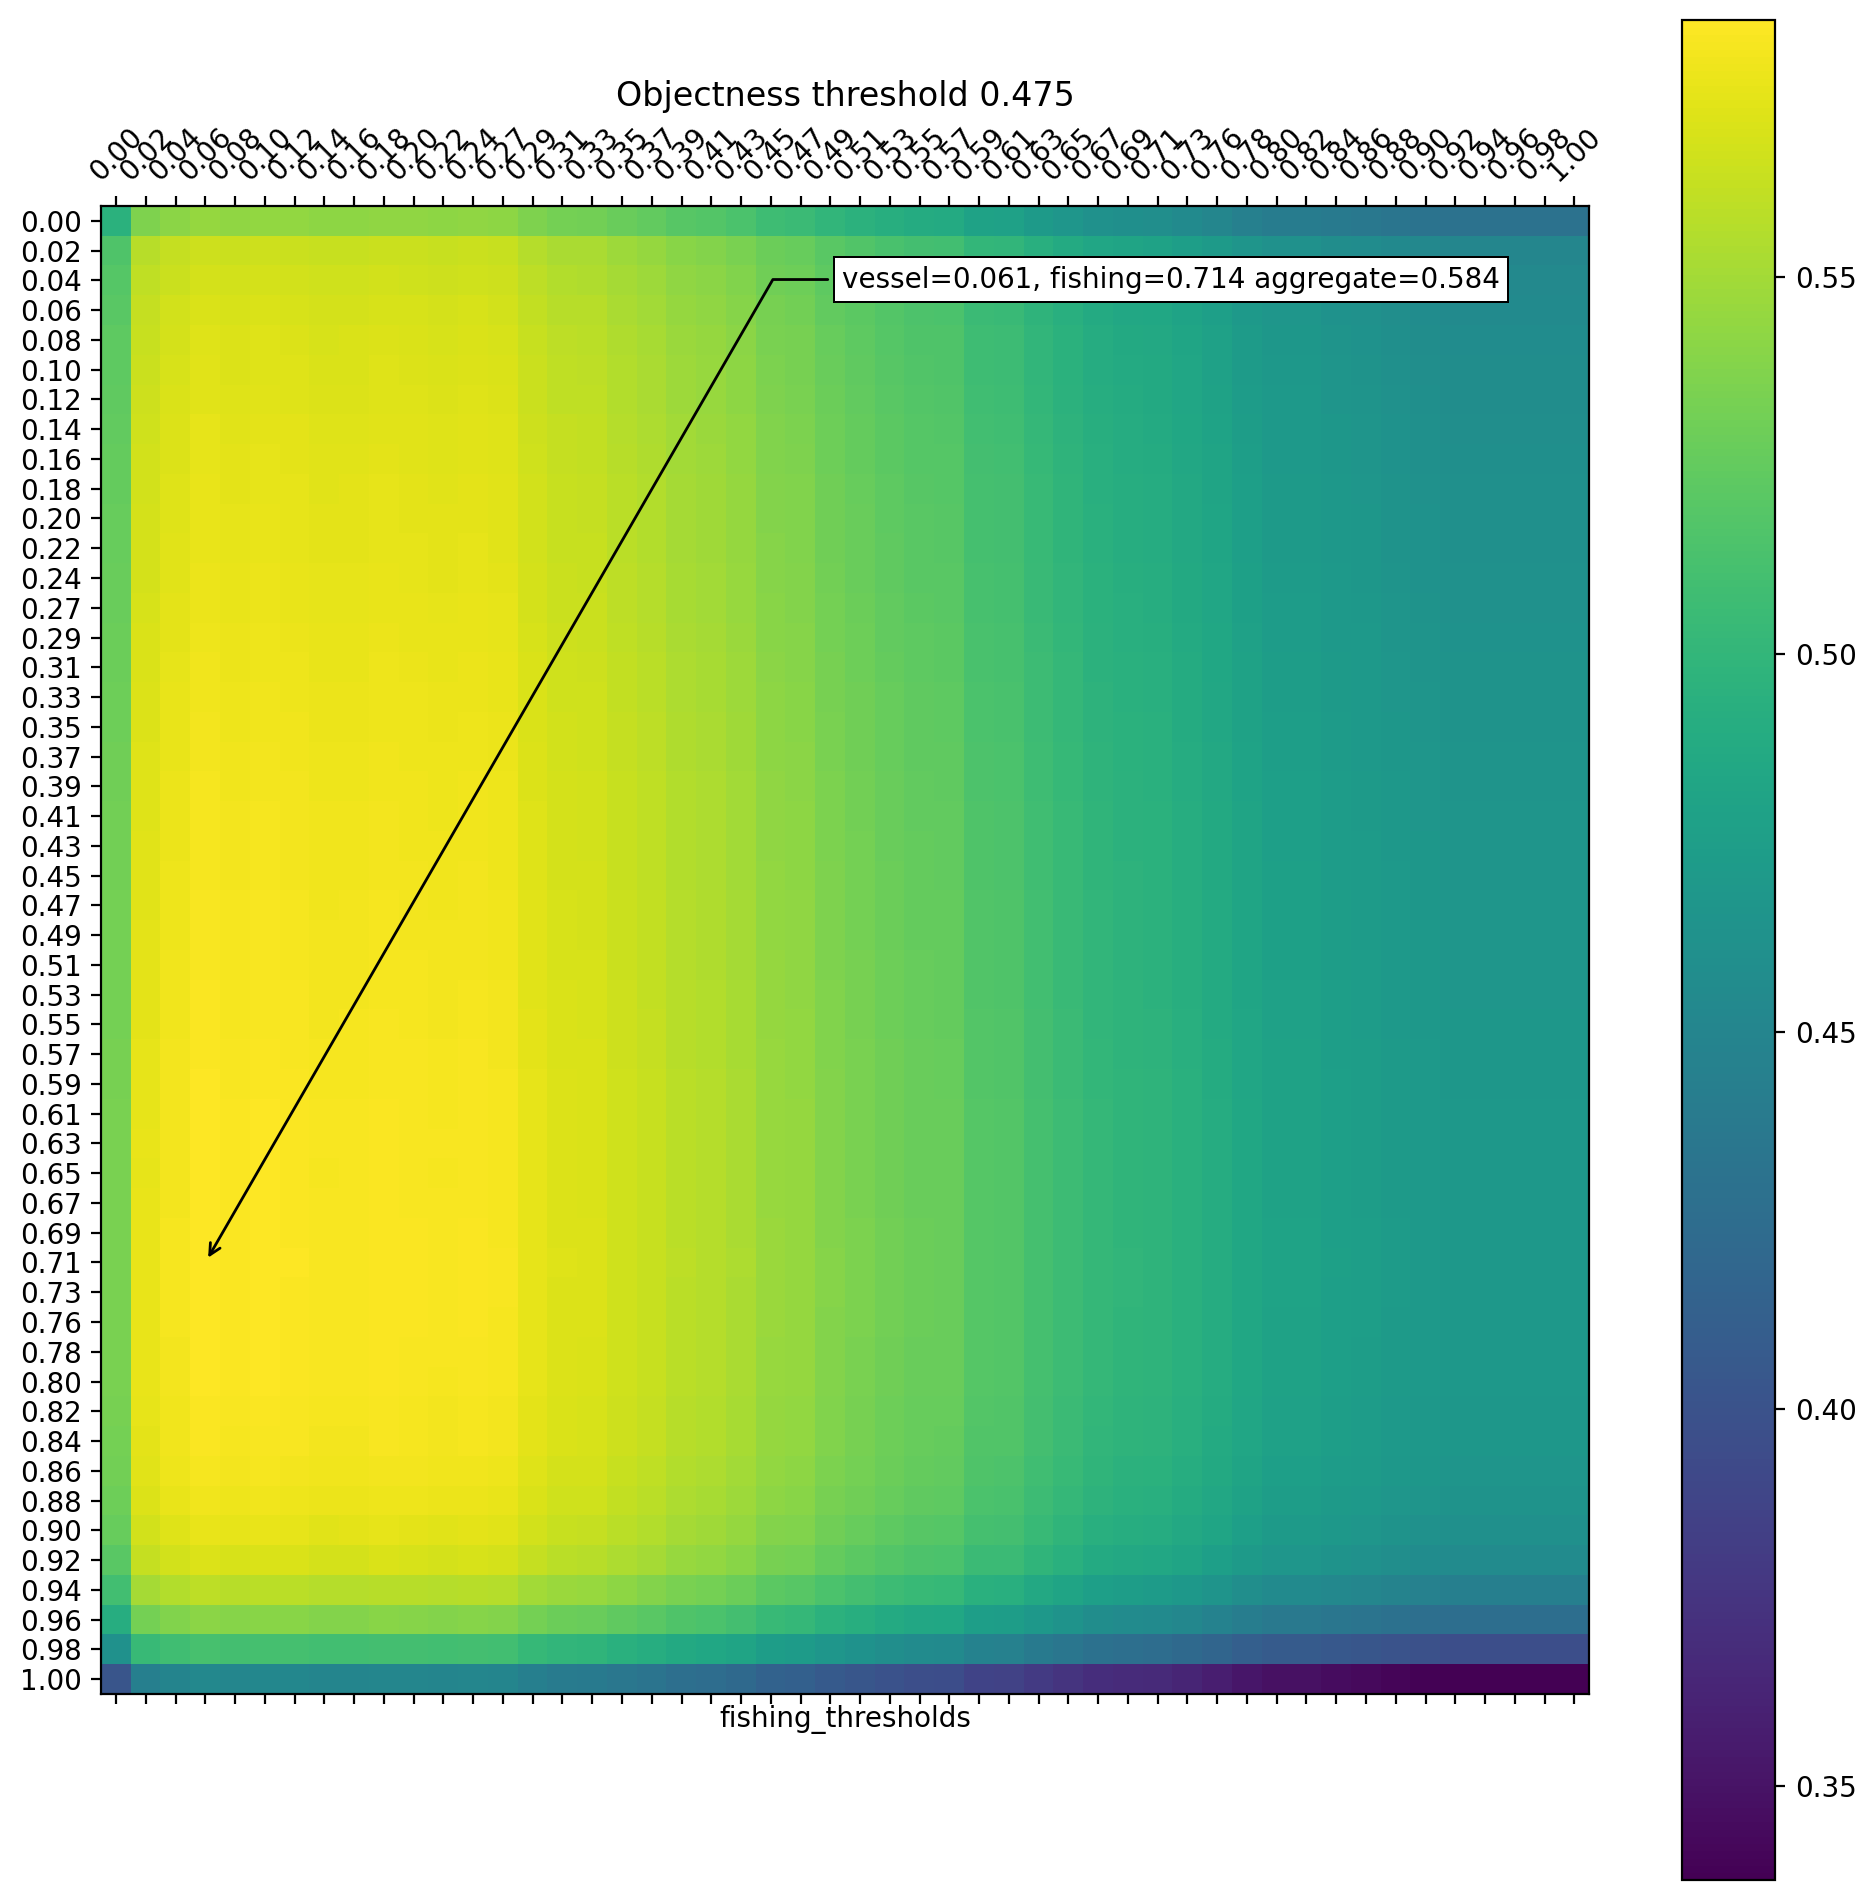

<ipython-input-20-488284eb5ea1>:70: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



<Figure size 3600x3600 with 0 Axes>

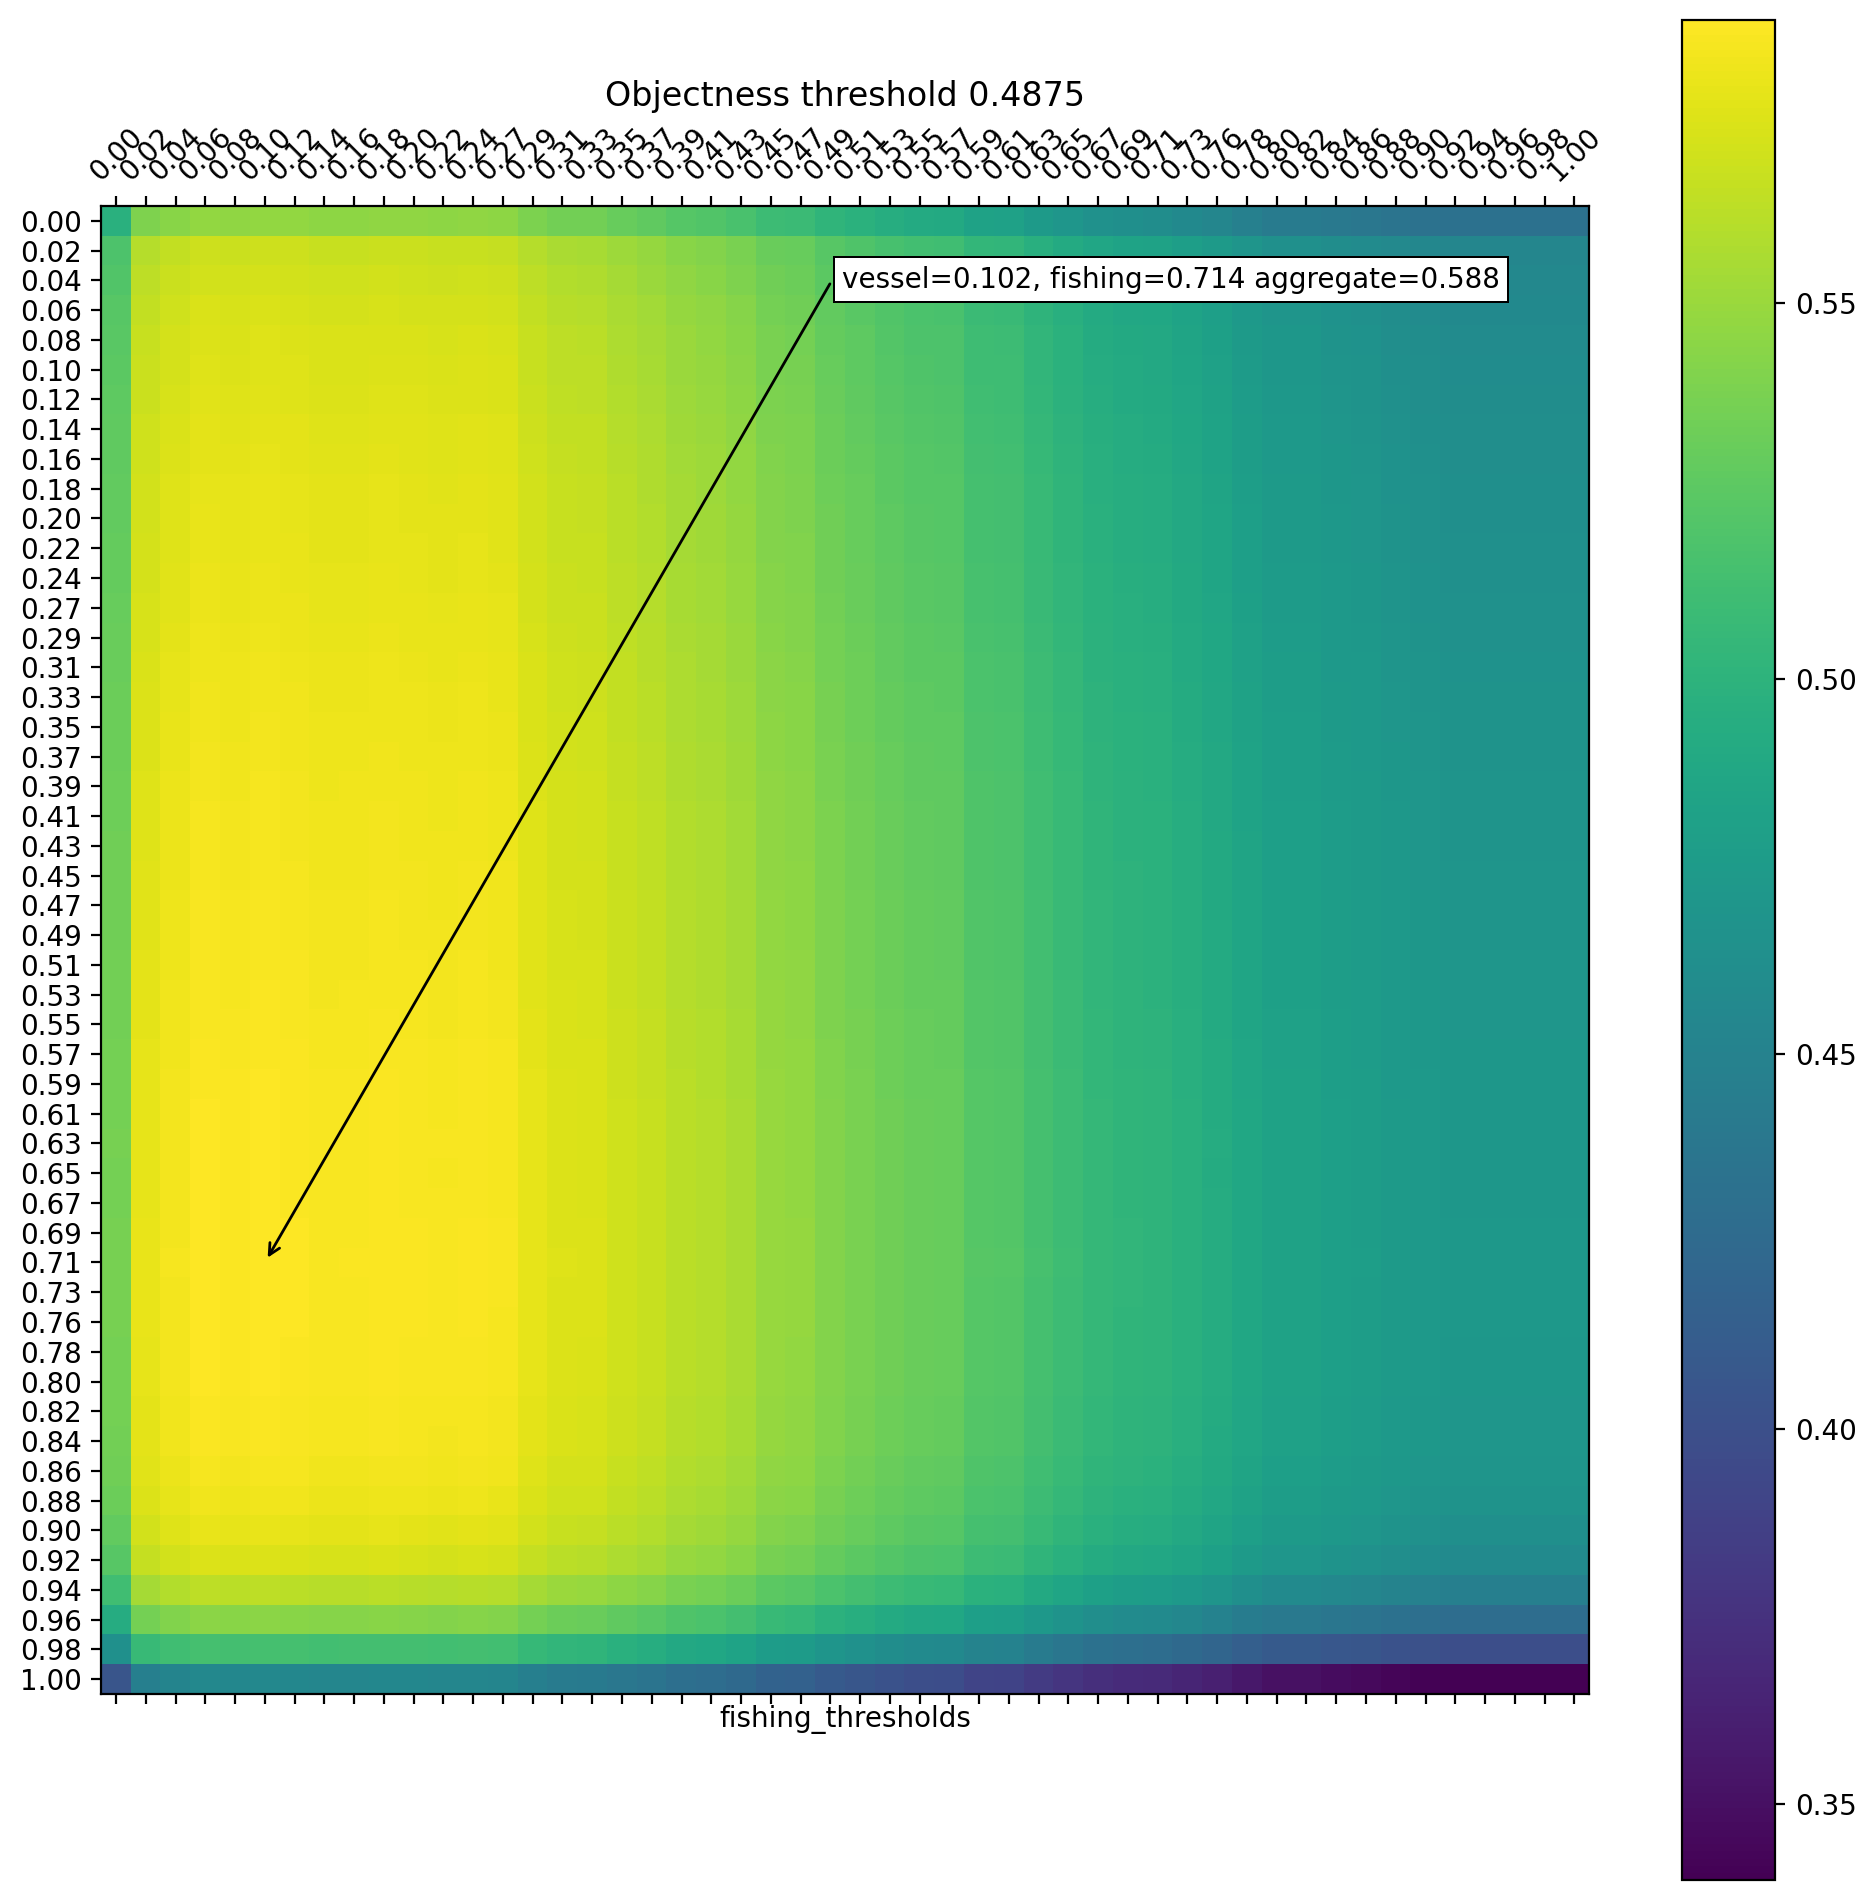

<ipython-input-20-488284eb5ea1>:70: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



<Figure size 3600x3600 with 0 Axes>

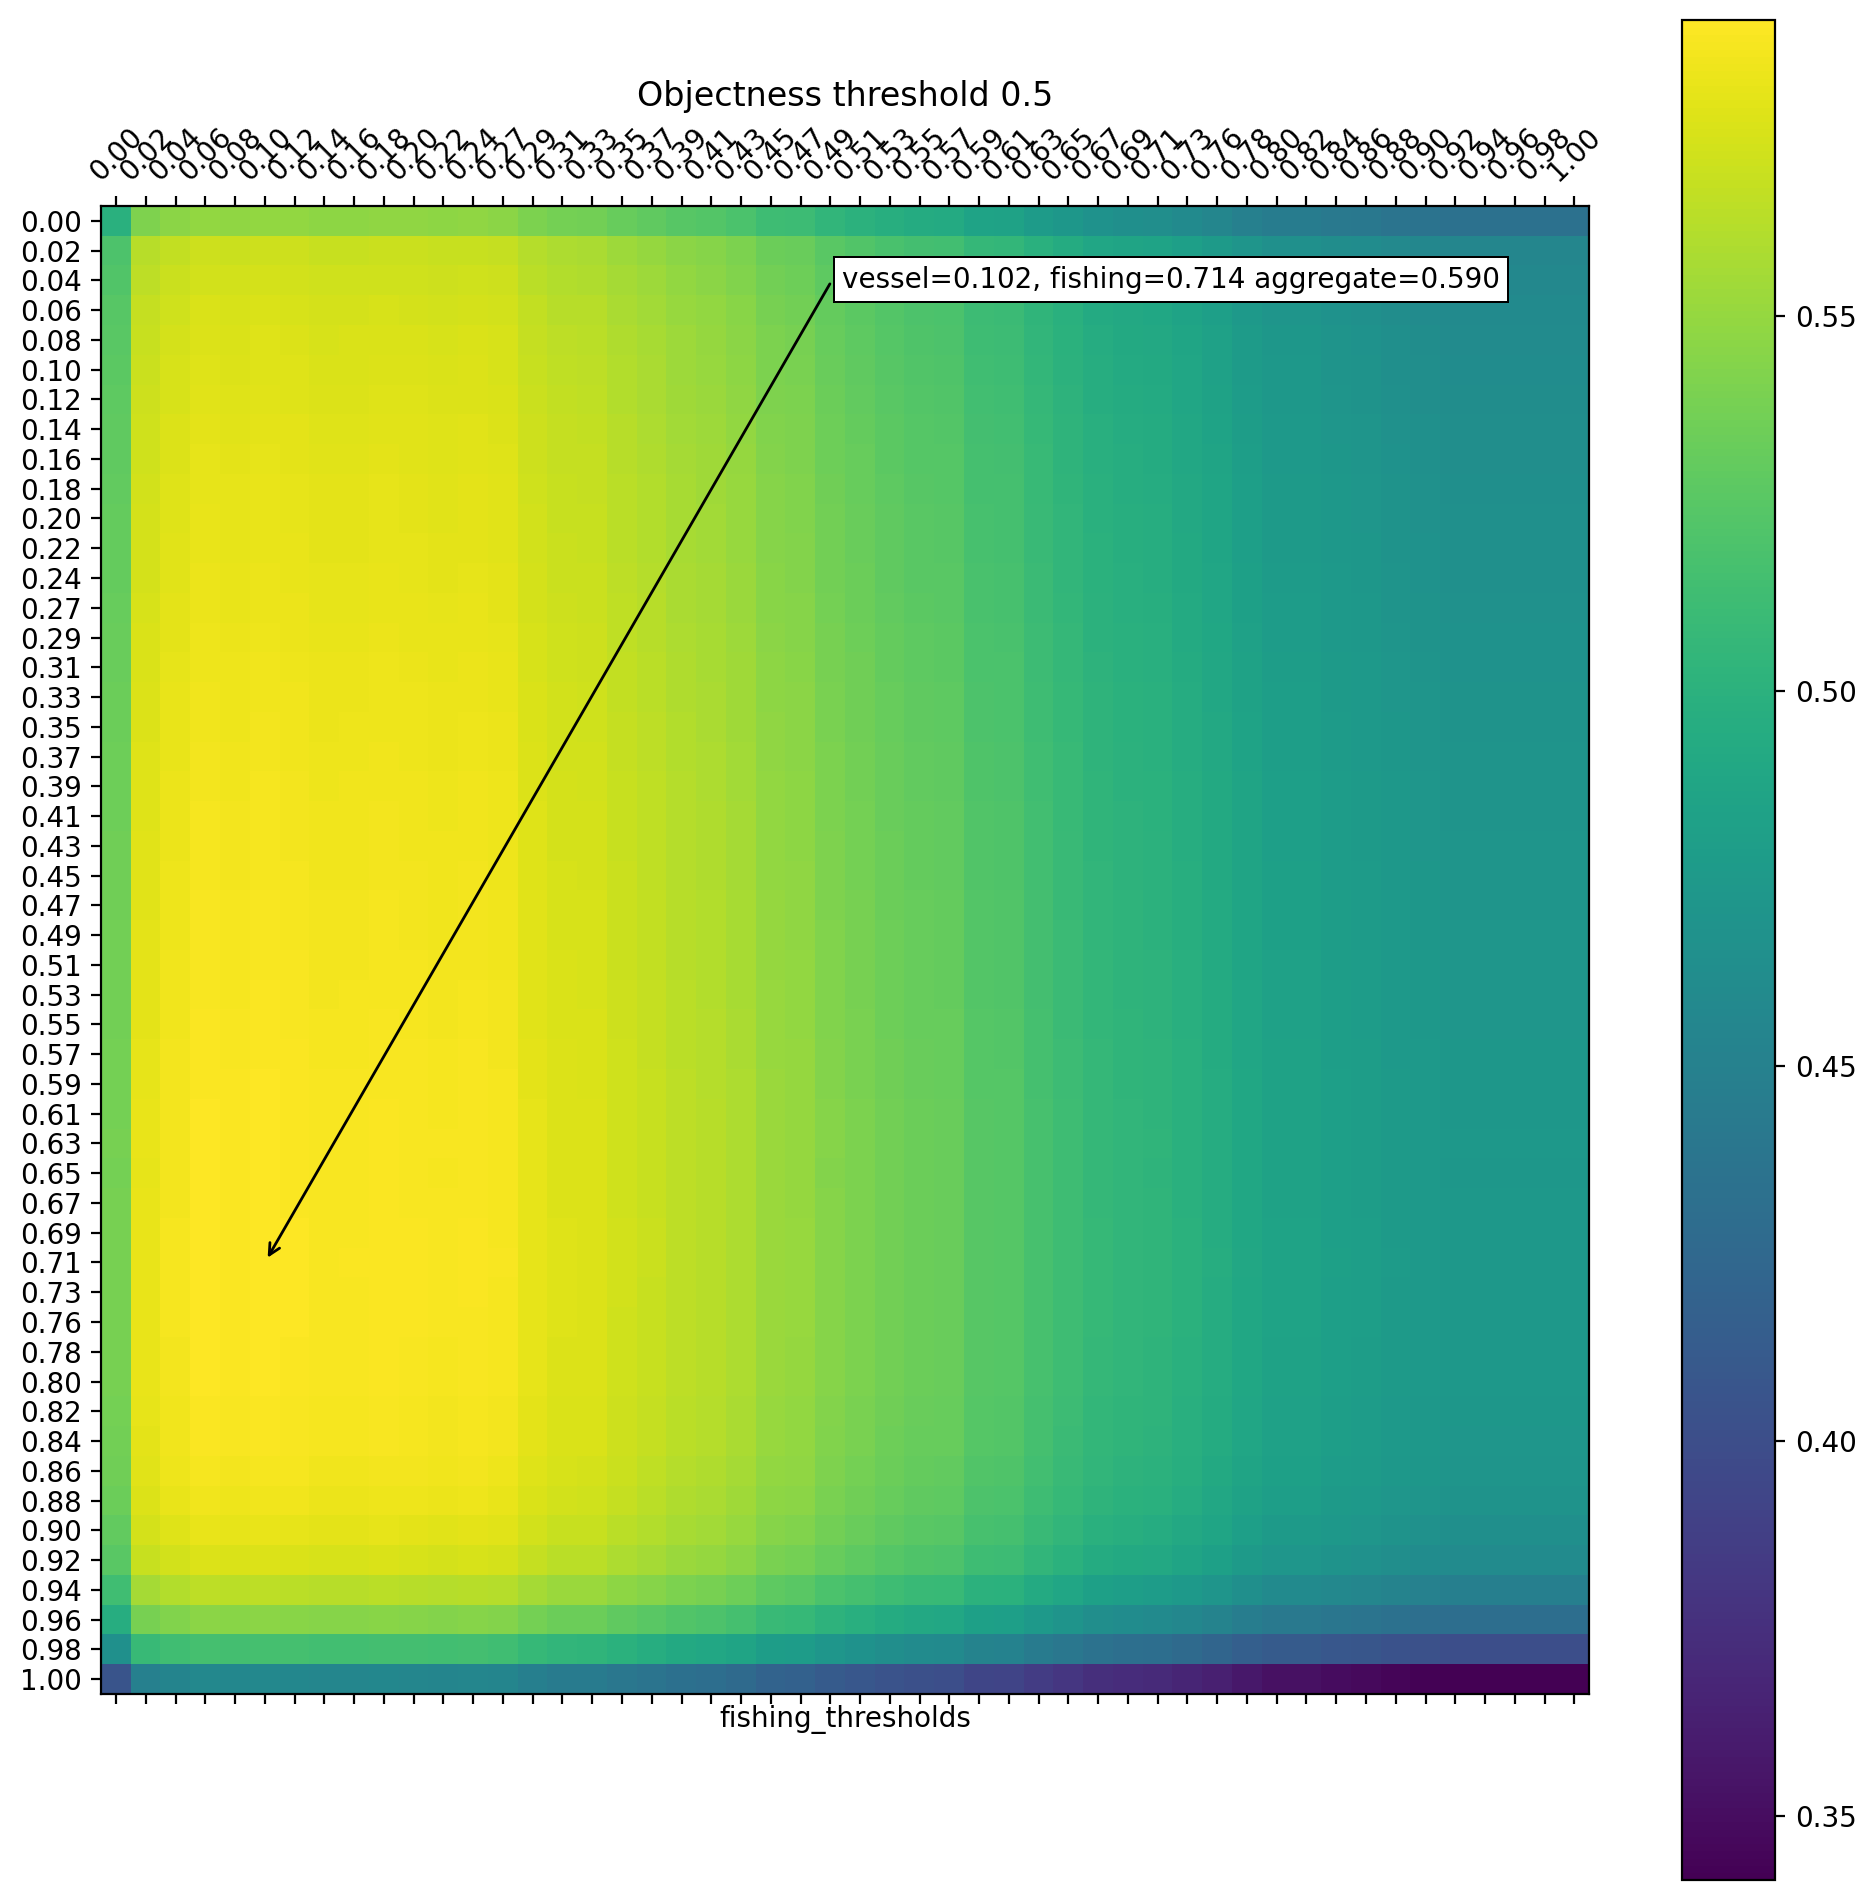

<ipython-input-20-488284eb5ea1>:70: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



<Figure size 3600x3600 with 0 Axes>

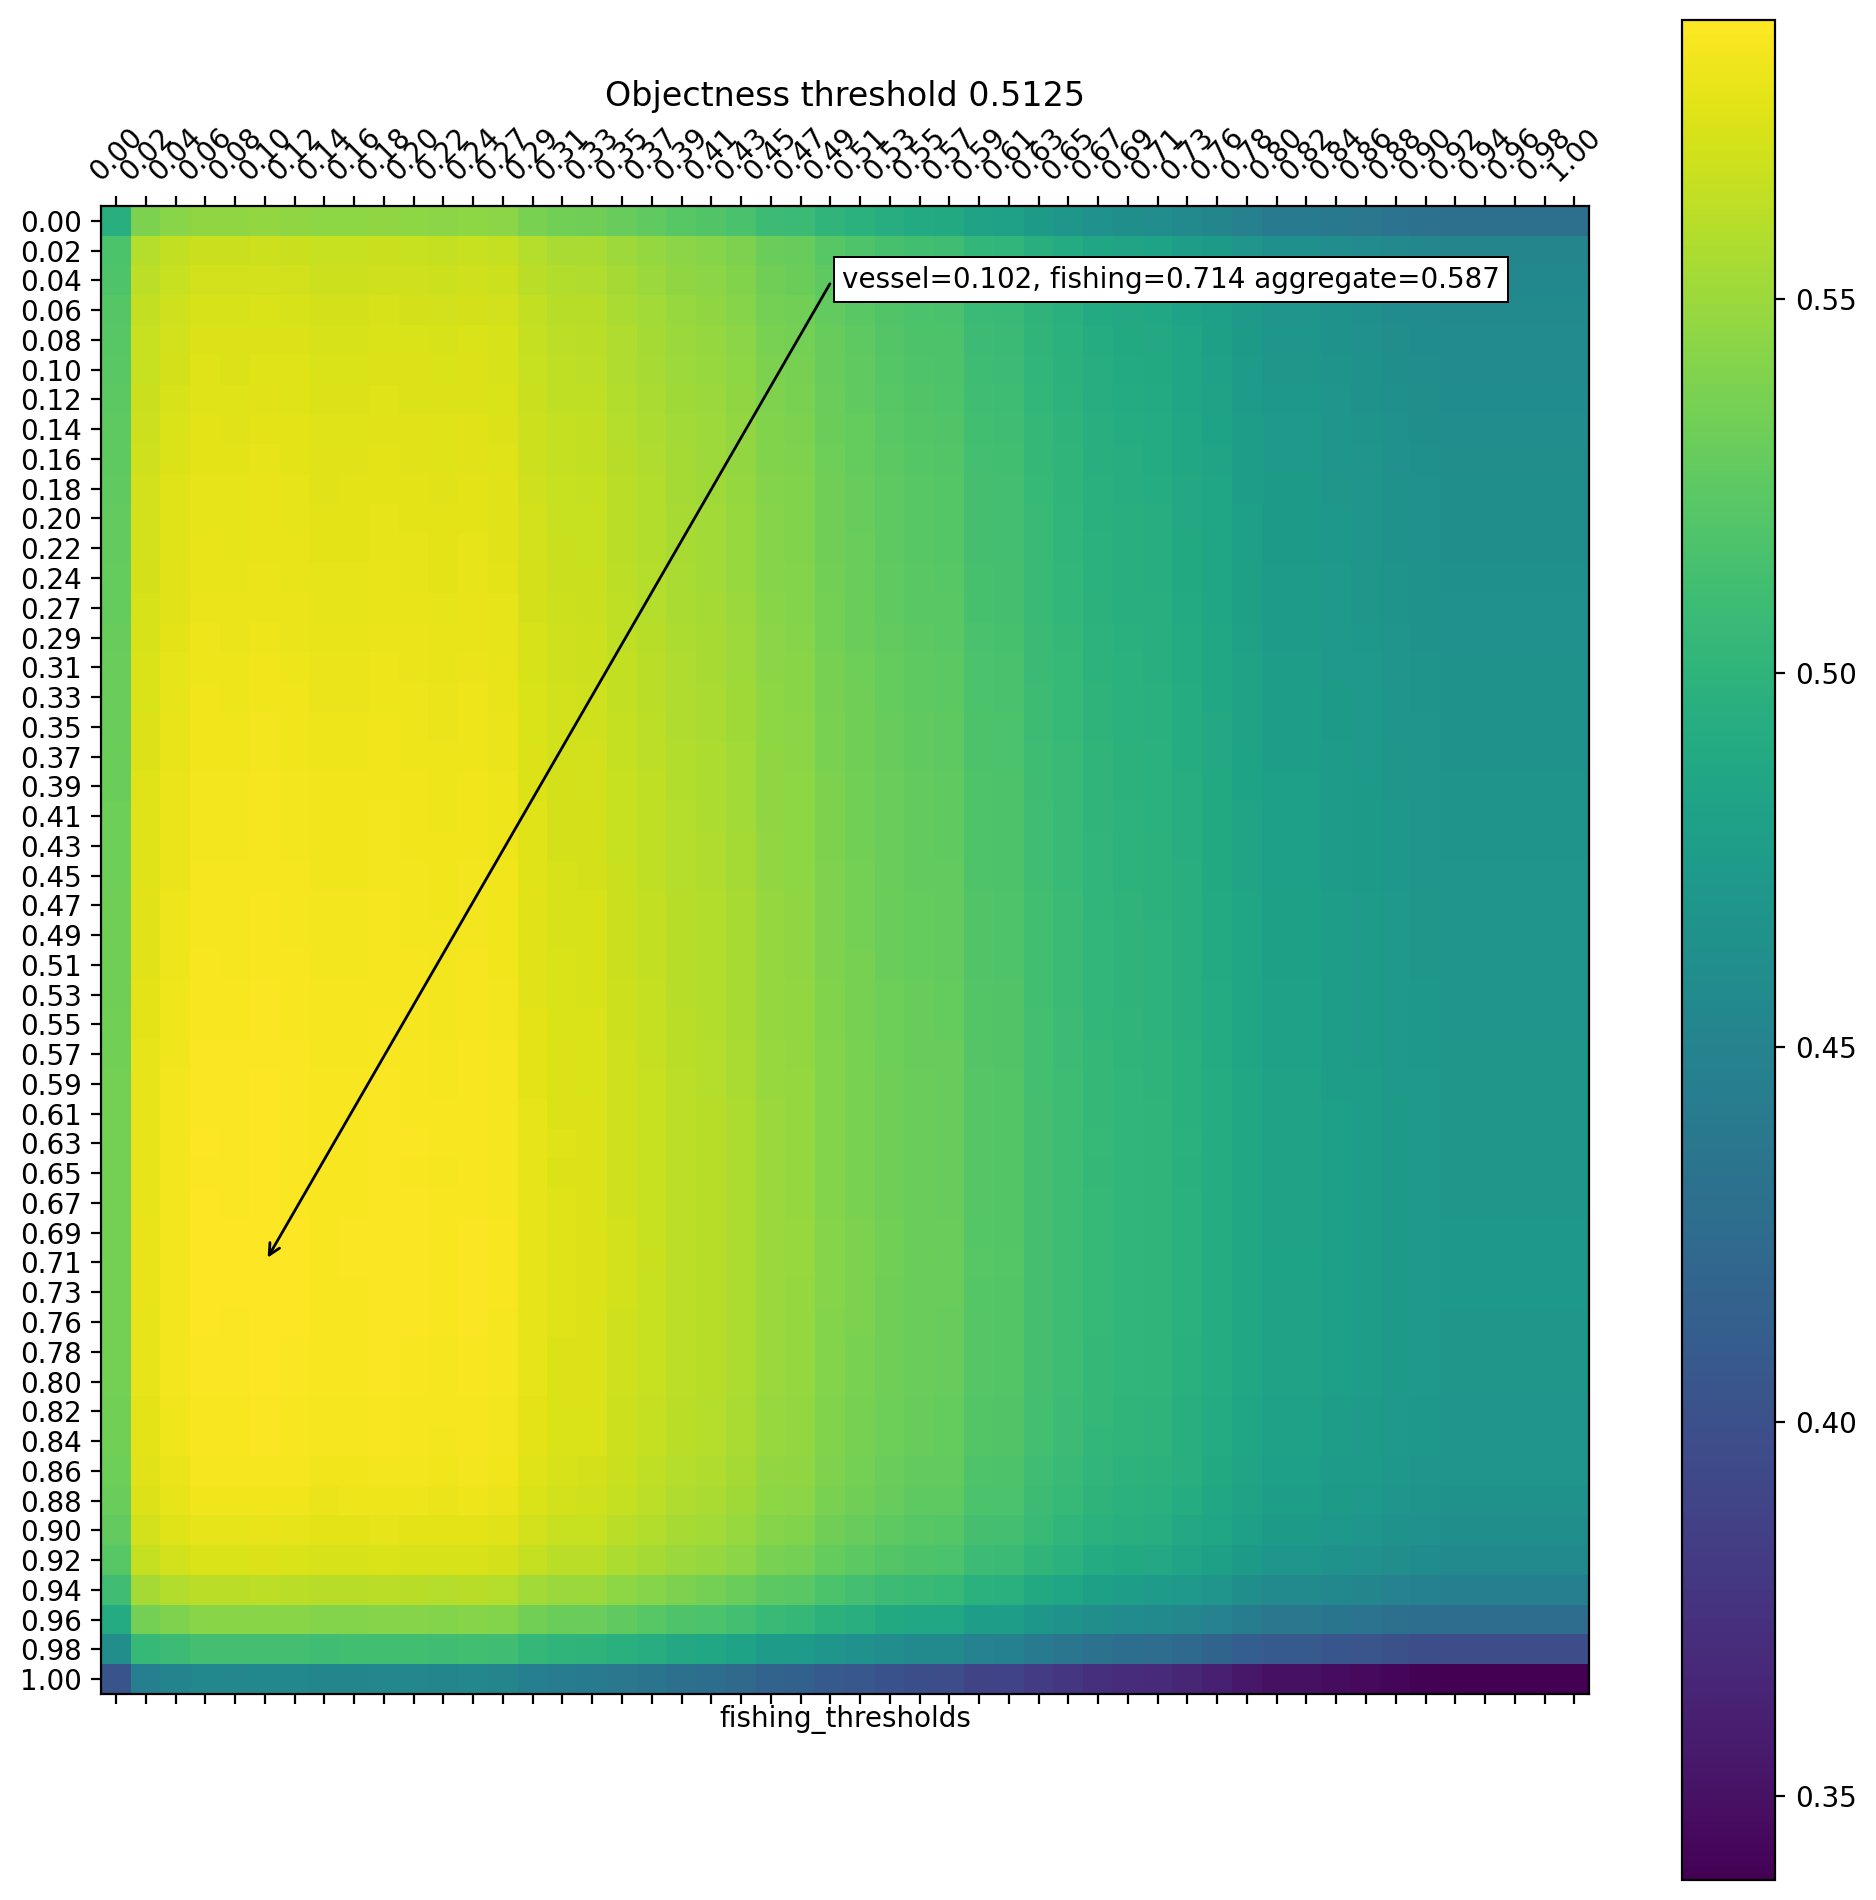

<ipython-input-20-488284eb5ea1>:70: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



<Figure size 3600x3600 with 0 Axes>

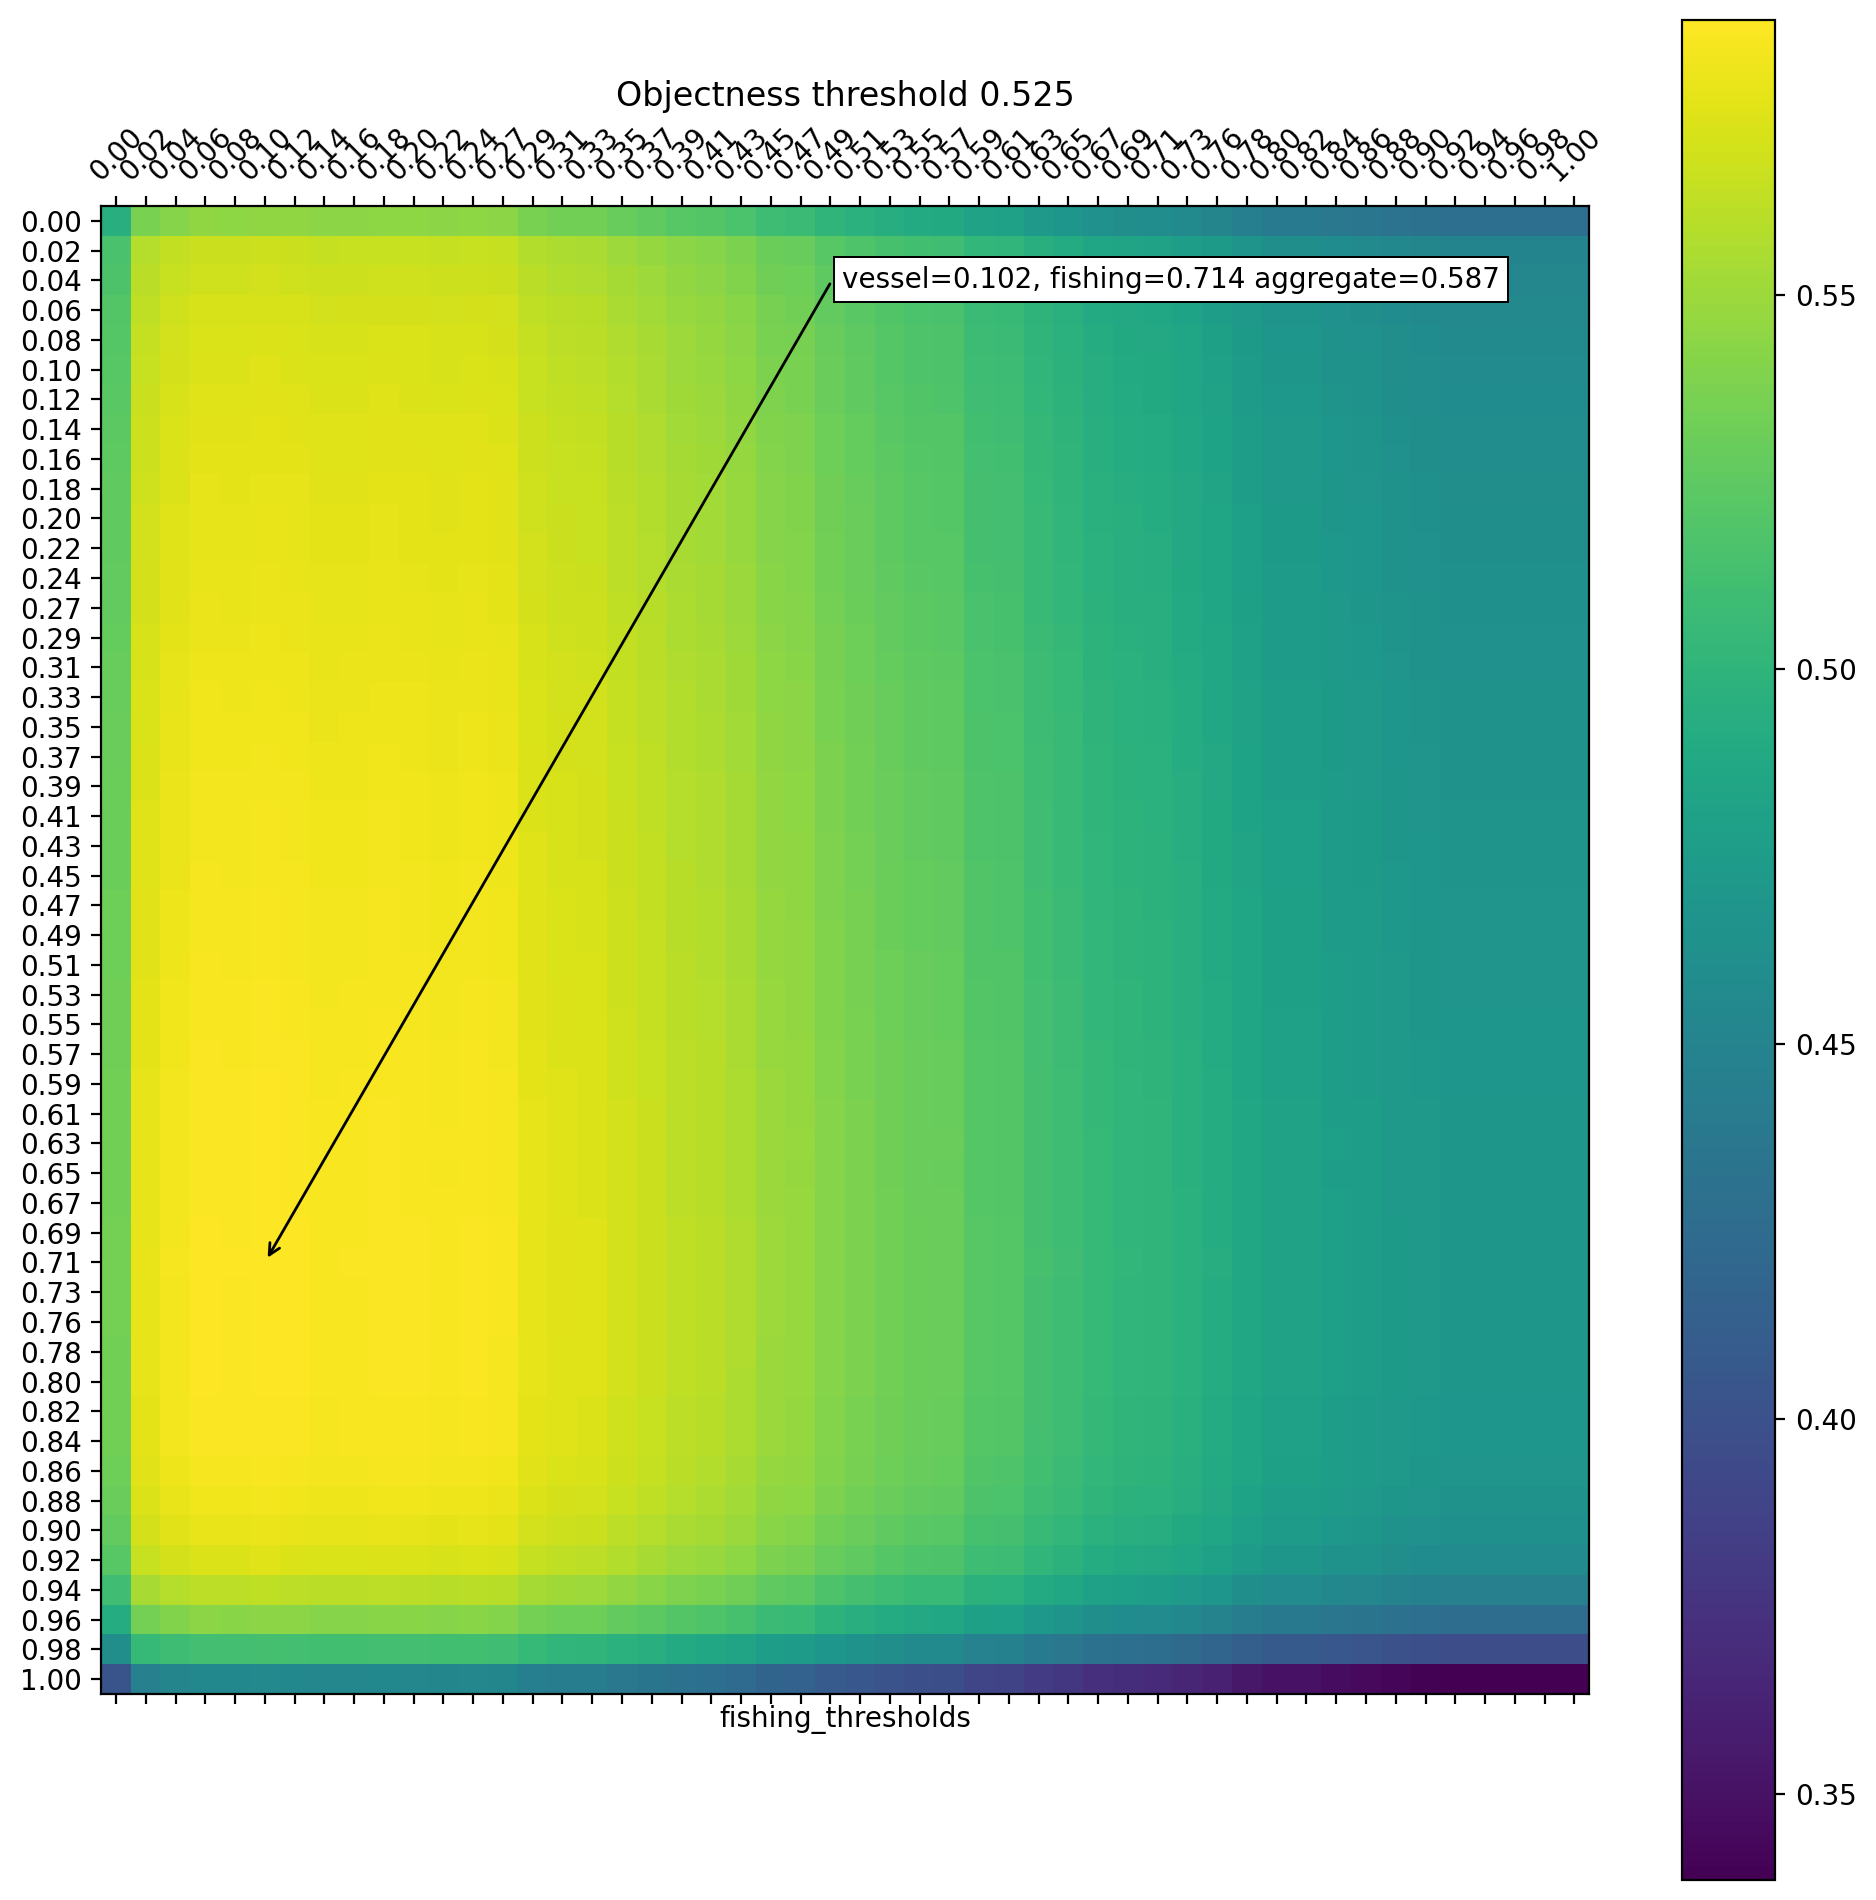

<ipython-input-20-488284eb5ea1>:70: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



<Figure size 3600x3600 with 0 Axes>

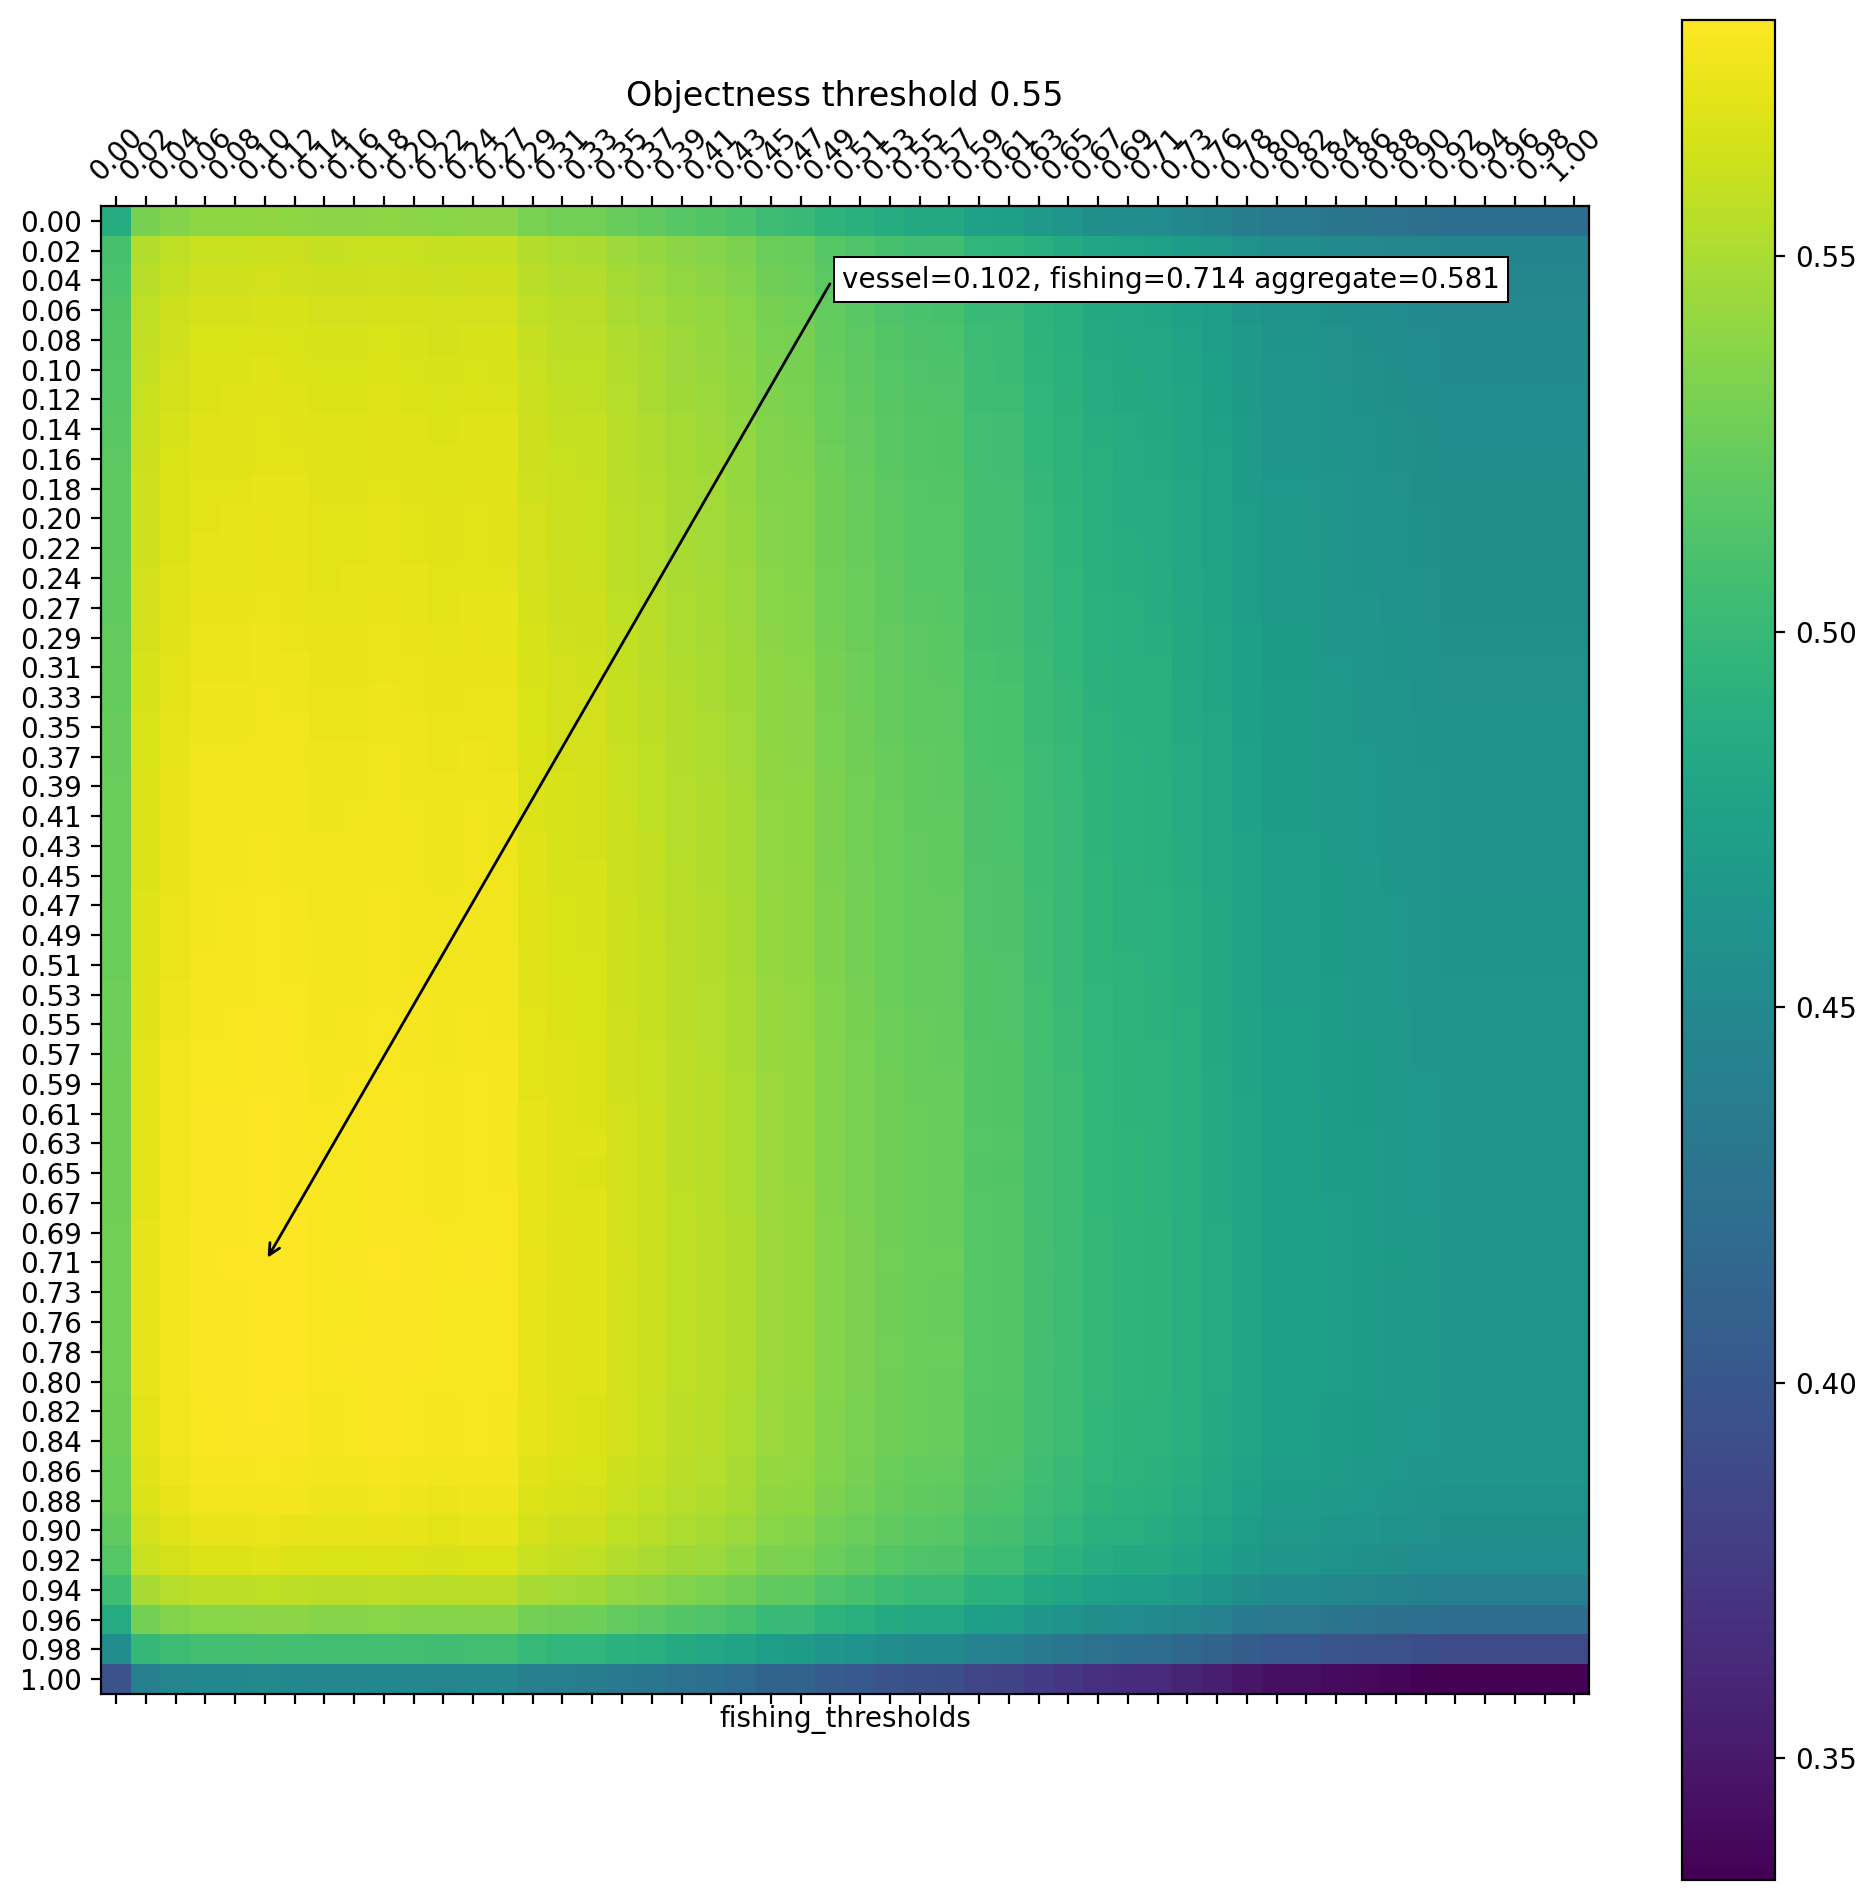

loc_fscore  loc_fscore_shore  vessel_fscore  fishing_fscore  length_acc  \
1755    0.797854          0.457613       0.880431        0.725389    0.631185   
1705    0.797854          0.457613       0.879665        0.725389    0.631185   
1805    0.797854          0.457613       0.879597        0.725389    0.631185   
1753    0.797854          0.457613       0.880431        0.723898    0.631185   
1855    0.797854          0.457613       0.878812        0.725389    0.631185   
1703    0.797854          0.457613       0.879665        0.723898    0.631185   
1803    0.797854          0.457613       0.879597        0.723898    0.631185   
1555    0.797854          0.457613       0.877612        0.725389    0.631185   
1655    0.797854          0.457613       0.877551        0.725389    0.631185   
1853    0.797854          0.457613       0.878812        0.723898    0.631185   
1905    0.797854          0.457613       0.877221        0.725389    0.631185   
1955    0.797854          0.457613       0.876997        0.725389    0.631185   
1505    0.797854          0.457613       0.876855        0.725389    0.631185   
1605    0.797854          0.457613       0.876692        0.725389    0.631185   
1756    0.797854          0.457613       0.880431        0.721485    0.631185   
1553    0.797854          0.457613       0.877612        0.723898    0.631185   
1653    0.797854          0.457613       0.877551        0.723898    0.631185   
1706    0.797854          0.457613       0.879665        0.721485    0.631185   
1903    0.797854          0.457613       0.877221        0.723898    0.631185   
1806    0.797854          0.457613       0.879597        0.721485    0.631185   

      aggregate  is_vessel_threshold  is_fishing_threshold  \
1755   0.589553             0.714286              0.102041   
1705   0.589431             0.693878              0.102041   
1805   0.589420             0.734694              0.102041   
1753   0.589315             0.714286              0.061224   
1855   0.589295             0.755102              0.102041   
1703   0.589193             0.693878              0.061224   
1803   0.589182             0.734694              0.061224   
1555   0.589103             0.632653              0.102041   
1655   0.589093             0.673469              0.102041   
1853   0.589057             0.755102              0.061224   
1905   0.589041             0.775510              0.102041   
1955   0.589005             0.795918              0.102041   
1505   0.588982             0.612245              0.102041   
1605   0.588956             0.653061              0.102041   
1756   0.588930             0.714286              0.122449   
1553   0.588865             0.632653              0.061224   
1653   0.588856             0.673469              0.061224   
1706   0.588808             0.693878              0.122449   
1903   0.588803             0.775510              0.061224   
1806   0.588797             0.734694              0.122449   

      objectness_threshold  
1755                   0.5  
1705                   0.5  
1805                   0.5  
1753                   0.5  
1855                   0.5  
1703                   0.5  
1803                   0.5  
1555                   0.5  
1655                   0.5  
1853                   0.5  
1905                   0.5  
1955                   0.5  
1505                   0.5  
1605                   0.5  
1756                   0.5  
1553                   0.5  
1653                   0.5  
1706                   0.5  
1903                   0.5  
1806                   0.5

In [24]:
vanilla_box_coder = MultilabelCircleNetCoder(
    (2048,2048), output_stride=4, max_objects=2048, heatmap_encoding="umich", labels_encoding="circle", ignore_value=IGNORE_LABEL,
    fixed_radius=3,
    labels_radius=3,
    nms_method=centernet_heatmap_nms,
    nms_kernel_size=5)

vanilla_predictions = decode_predictions(predicted_scenes_paths, vanilla_box_coder)
centernet_heatmap_nms_ks_5 = compute_optimal_thresholds(
    predictions=vanilla_predictions,
    groundtruths=groundtruth,
    shore_root=shore_root,
    objectness_thresholds=objectness_thresholds,
)
centernet_heatmap_nms_ks_5.to_csv("centernet_heatmap_nms_ks_5", index=False)
plot_visualizations(centernet_heatmap_nms_ks_5)
centernet_heatmap_nms_ks_5.head(20)


Computing optimal vessel & fishing thresholds:   0%|          | 0/7 [00:00<?, ?it/s]

Computing optimal thresholds
objectness_thresholds [0.45   0.475  0.4875 0.5    0.5125 0.525  0.55  ]


Computing optimal vessel & fishing thresholds: 100%|██████████| 7/7 [04:32<00:00, 38.90s/it] 
<ipython-input-20-488284eb5ea1>:70: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



<Figure size 3600x3600 with 0 Axes>

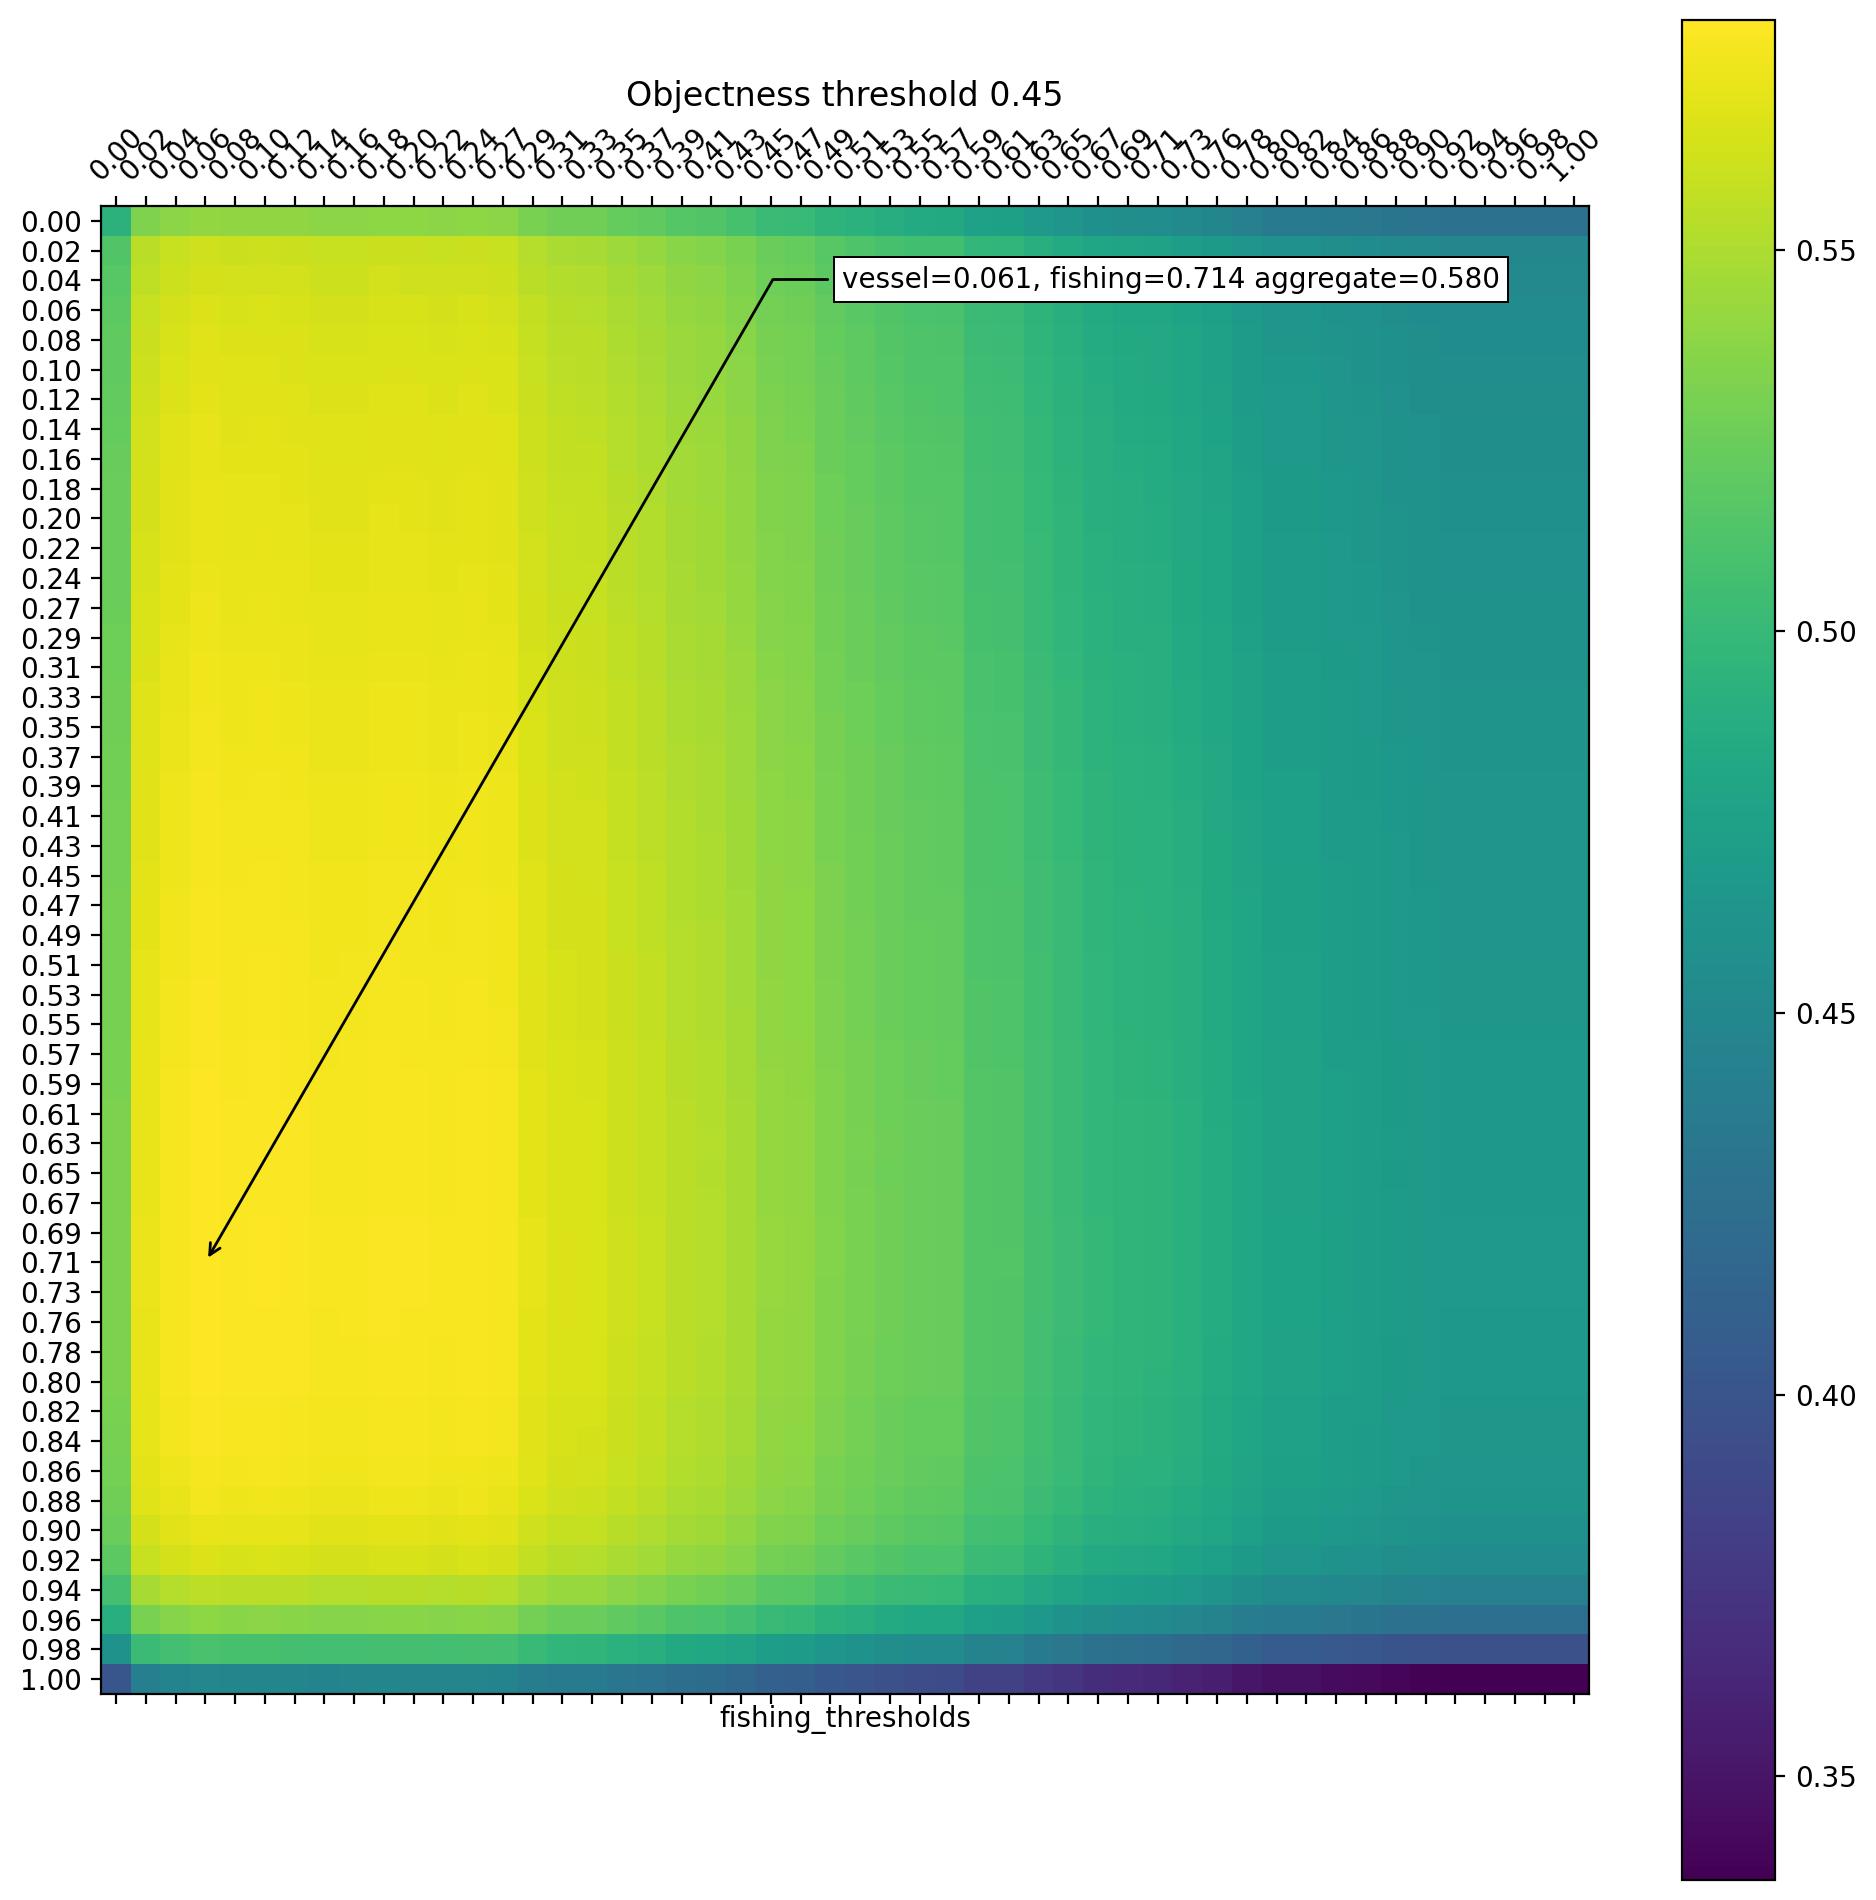

<ipython-input-20-488284eb5ea1>:70: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



<Figure size 3600x3600 with 0 Axes>

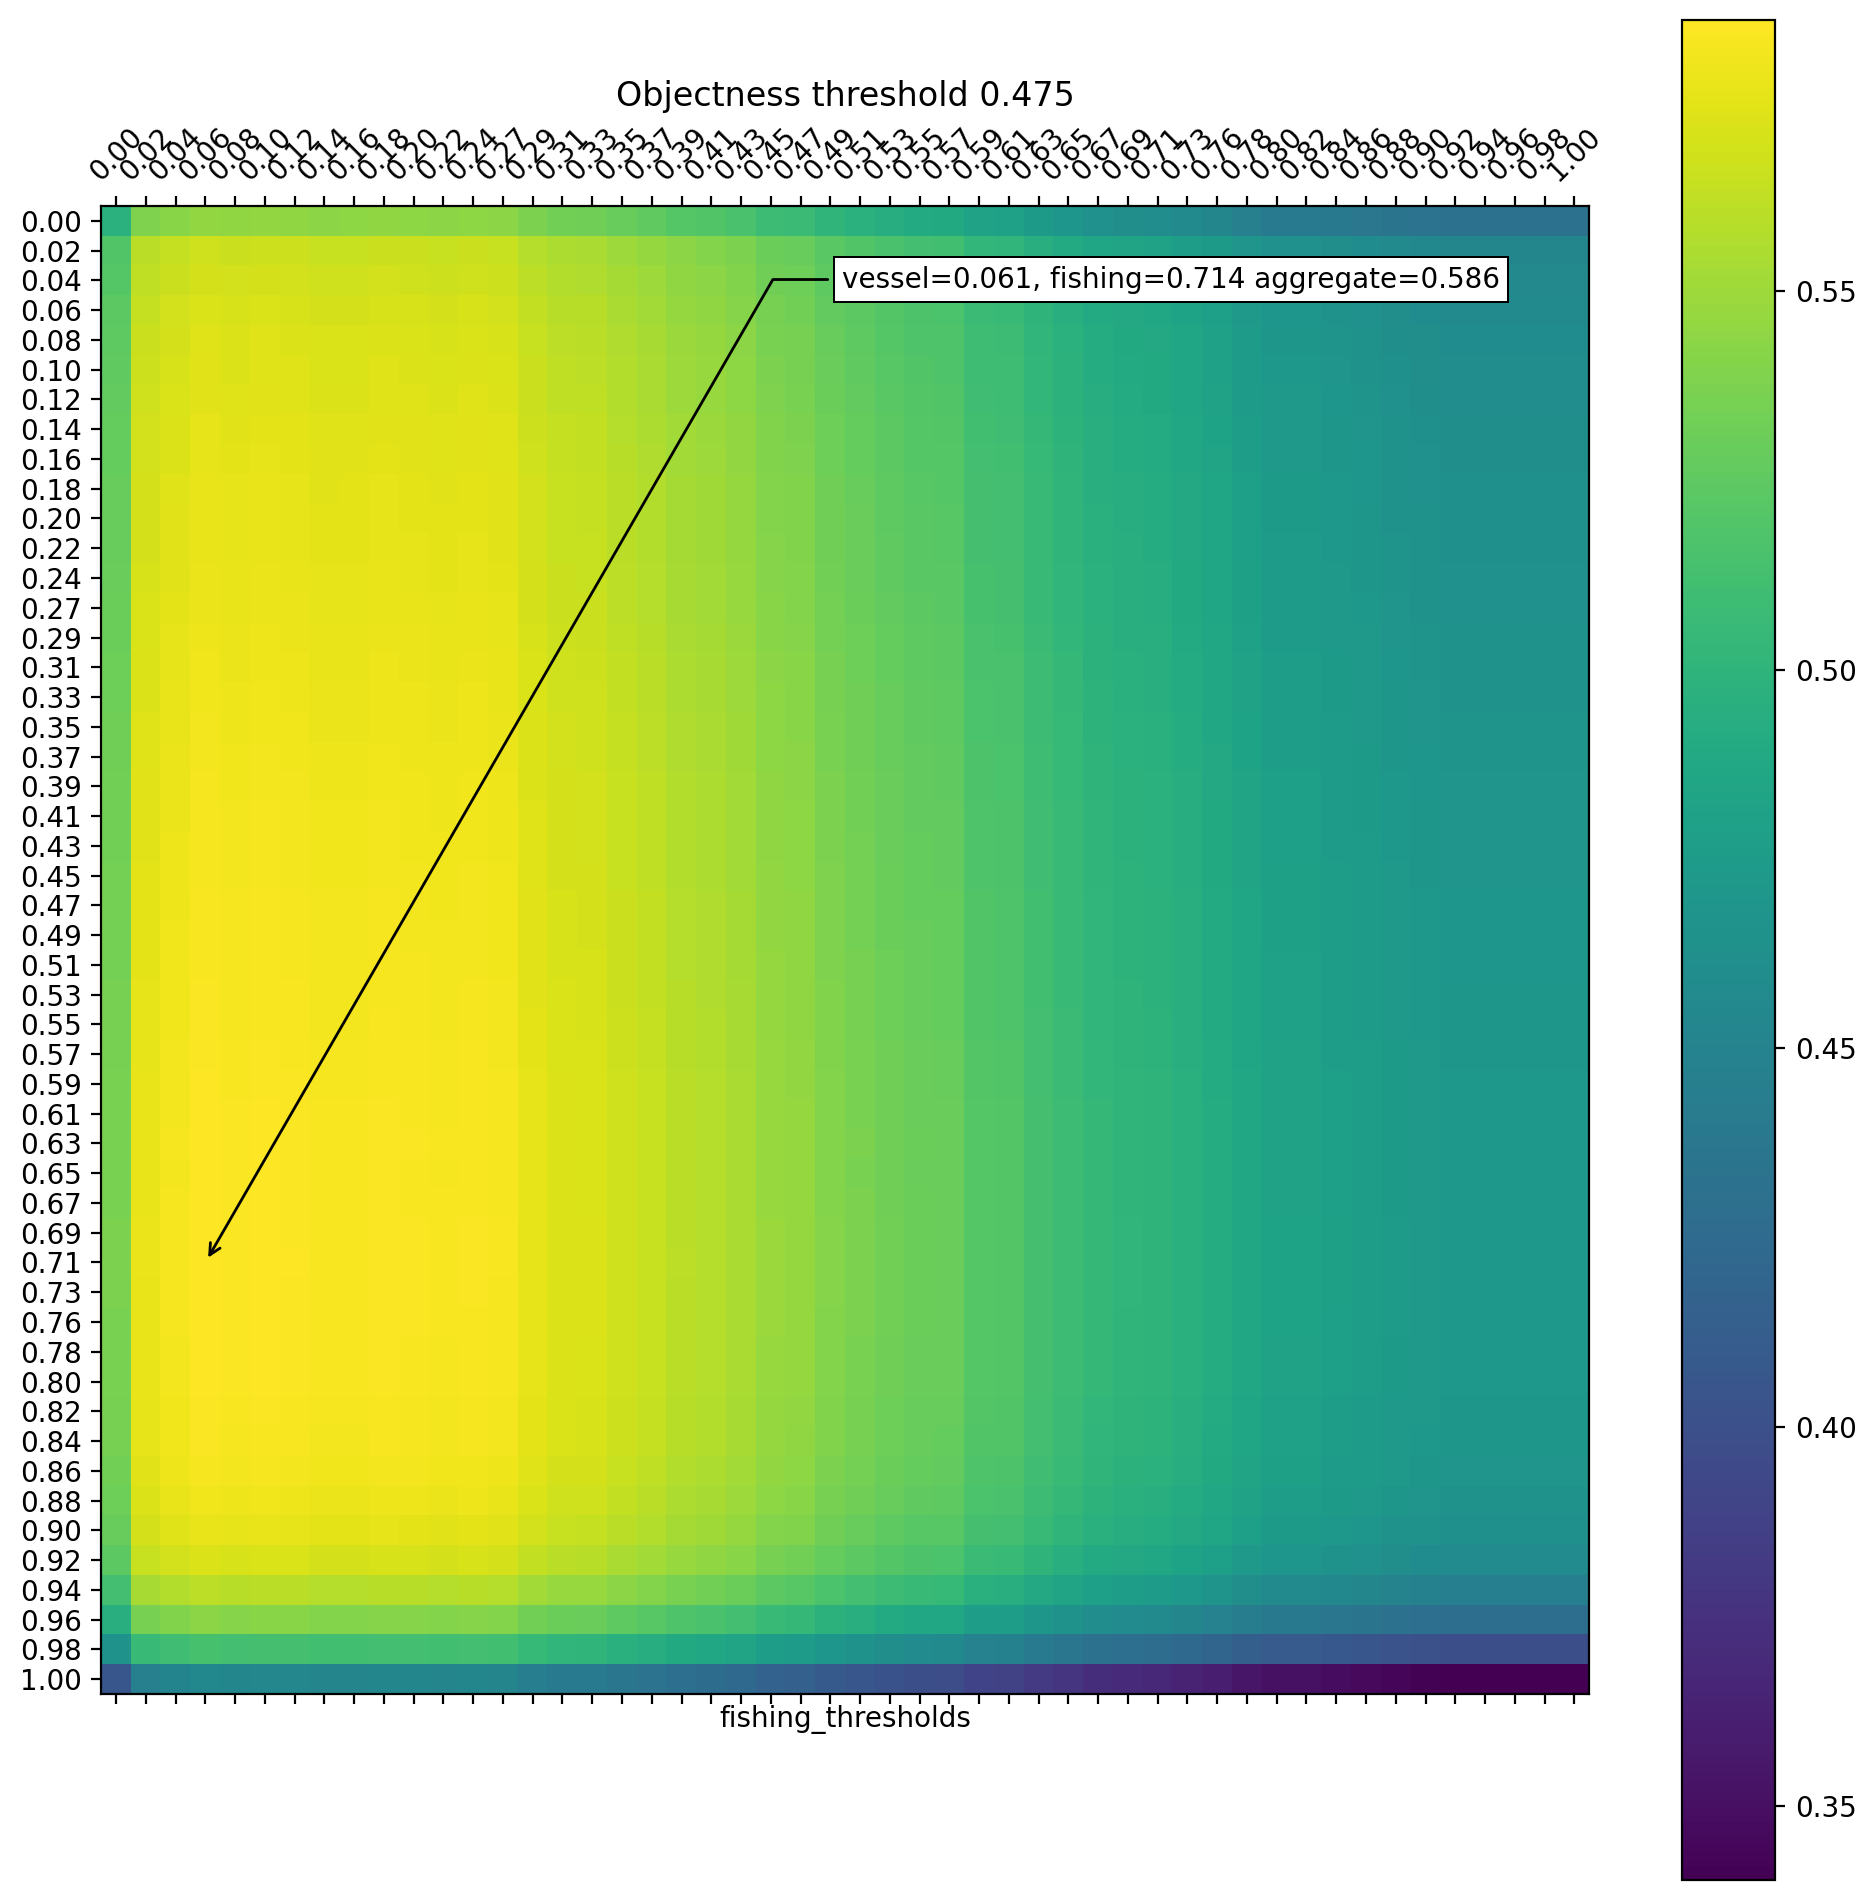

<ipython-input-20-488284eb5ea1>:70: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



<Figure size 3600x3600 with 0 Axes>

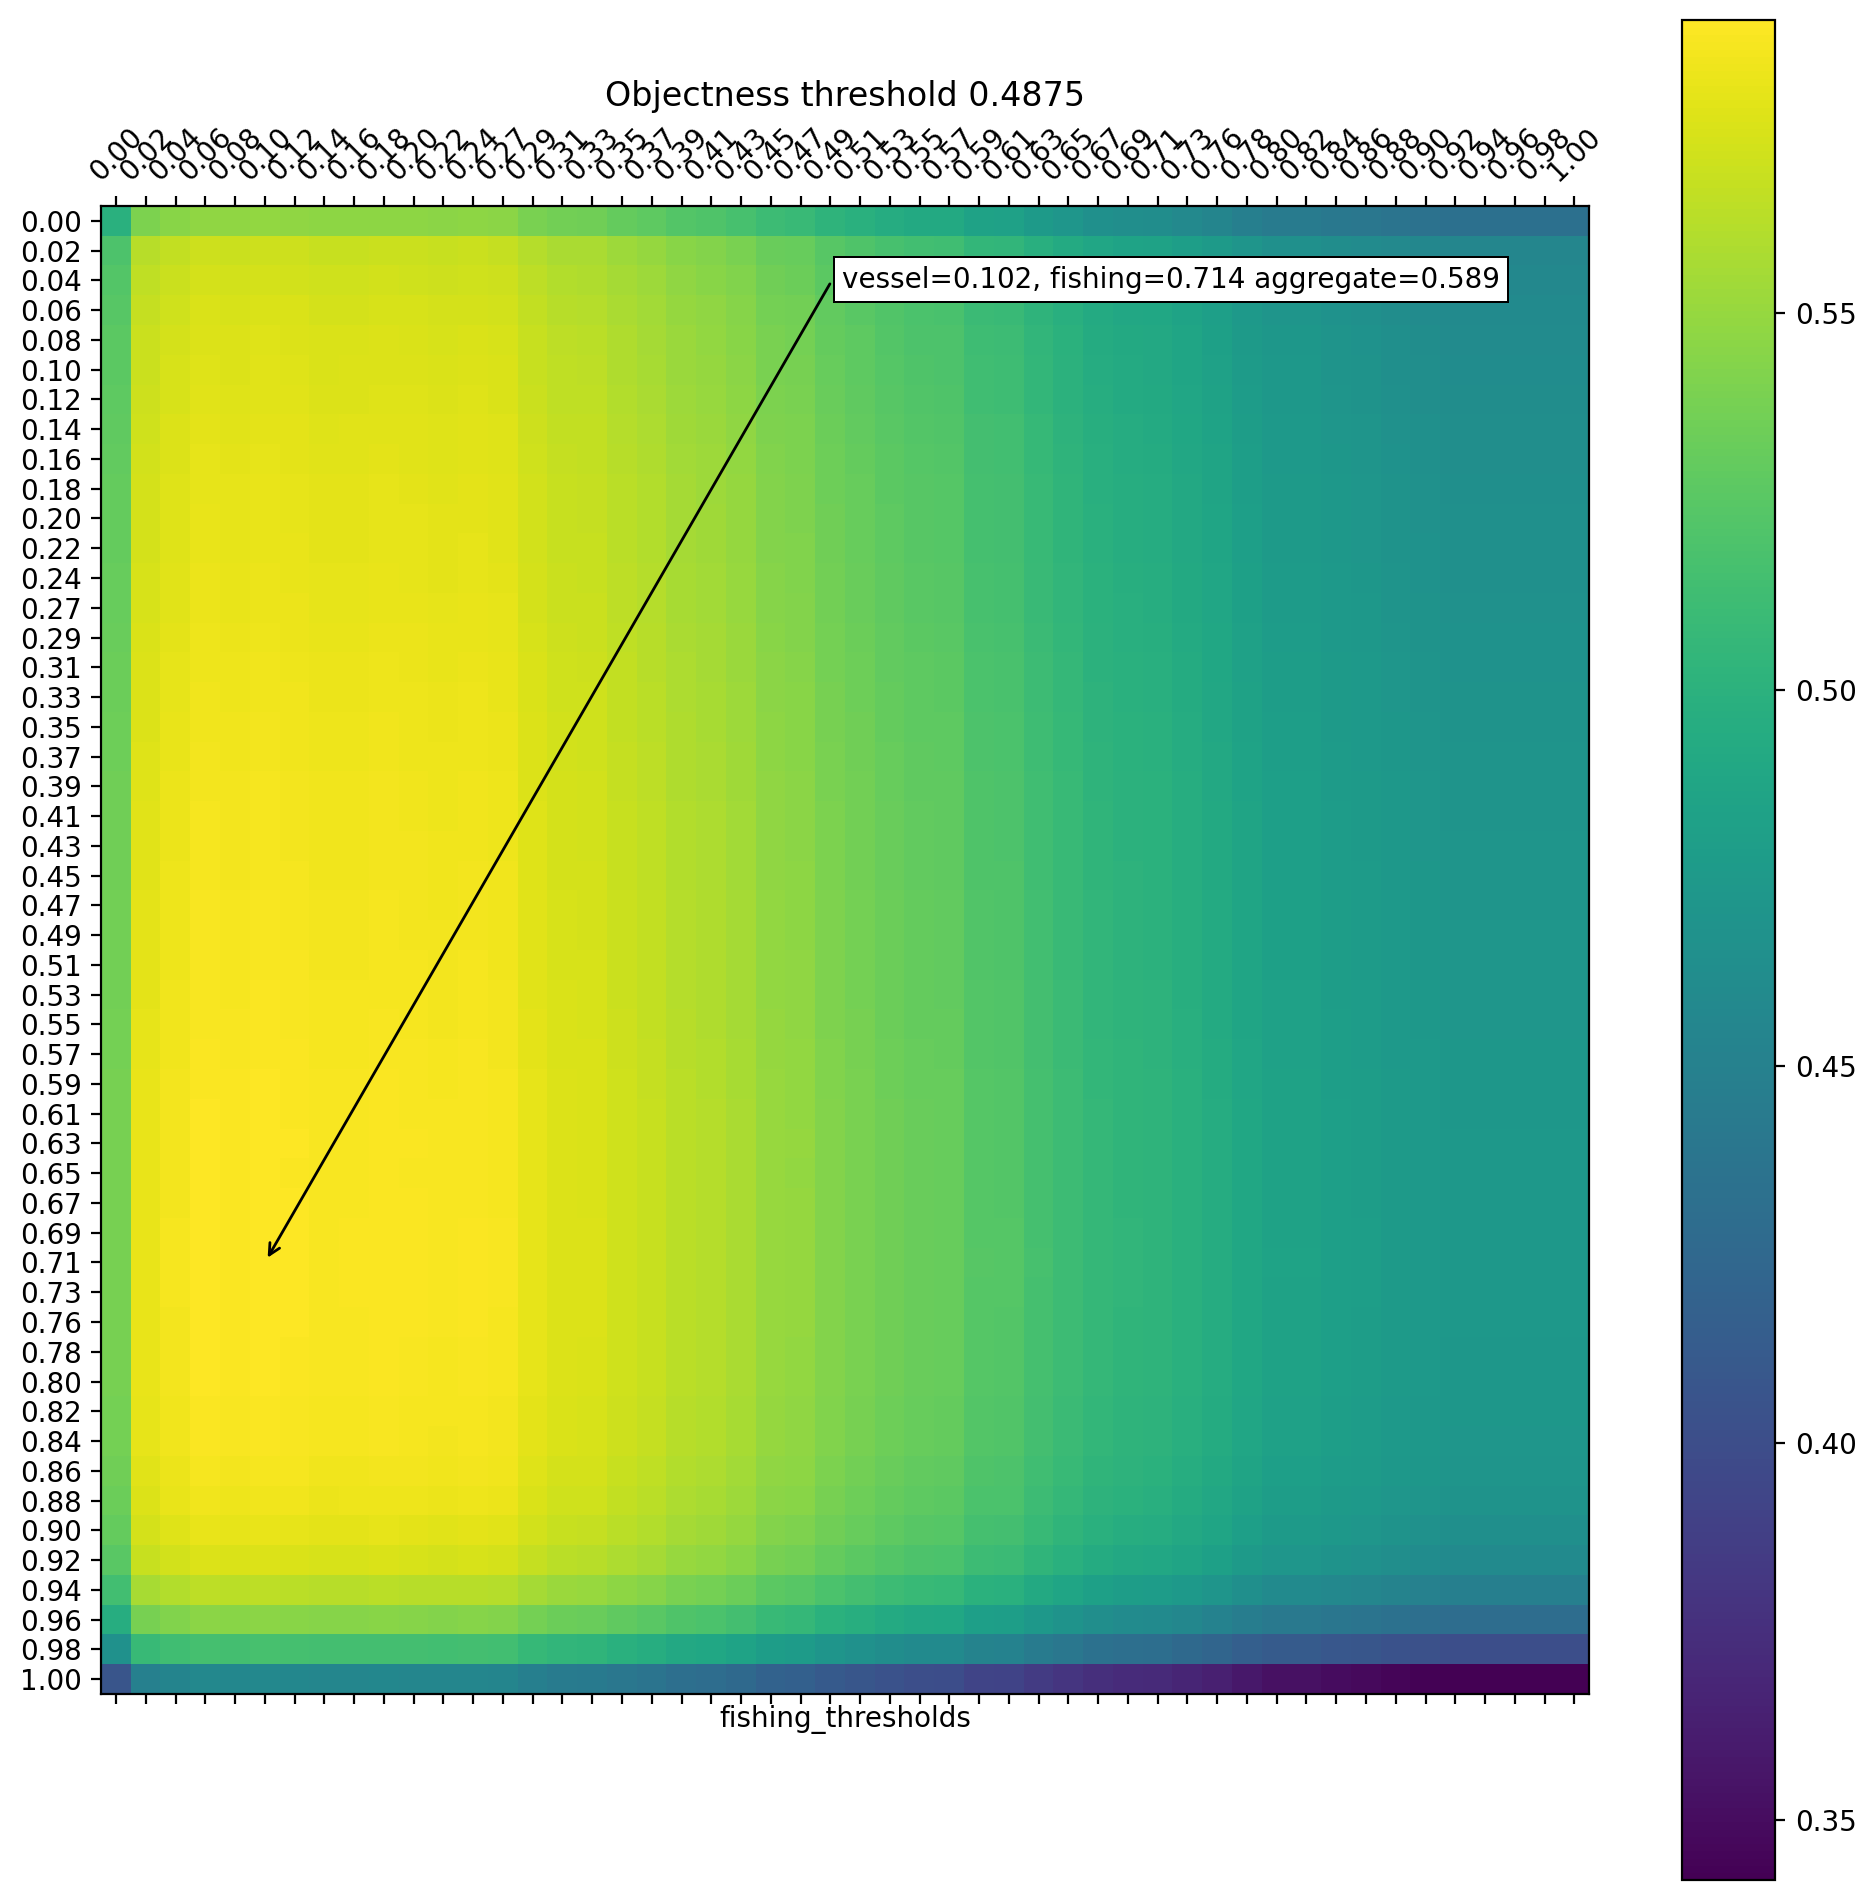

<ipython-input-20-488284eb5ea1>:70: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



<Figure size 3600x3600 with 0 Axes>

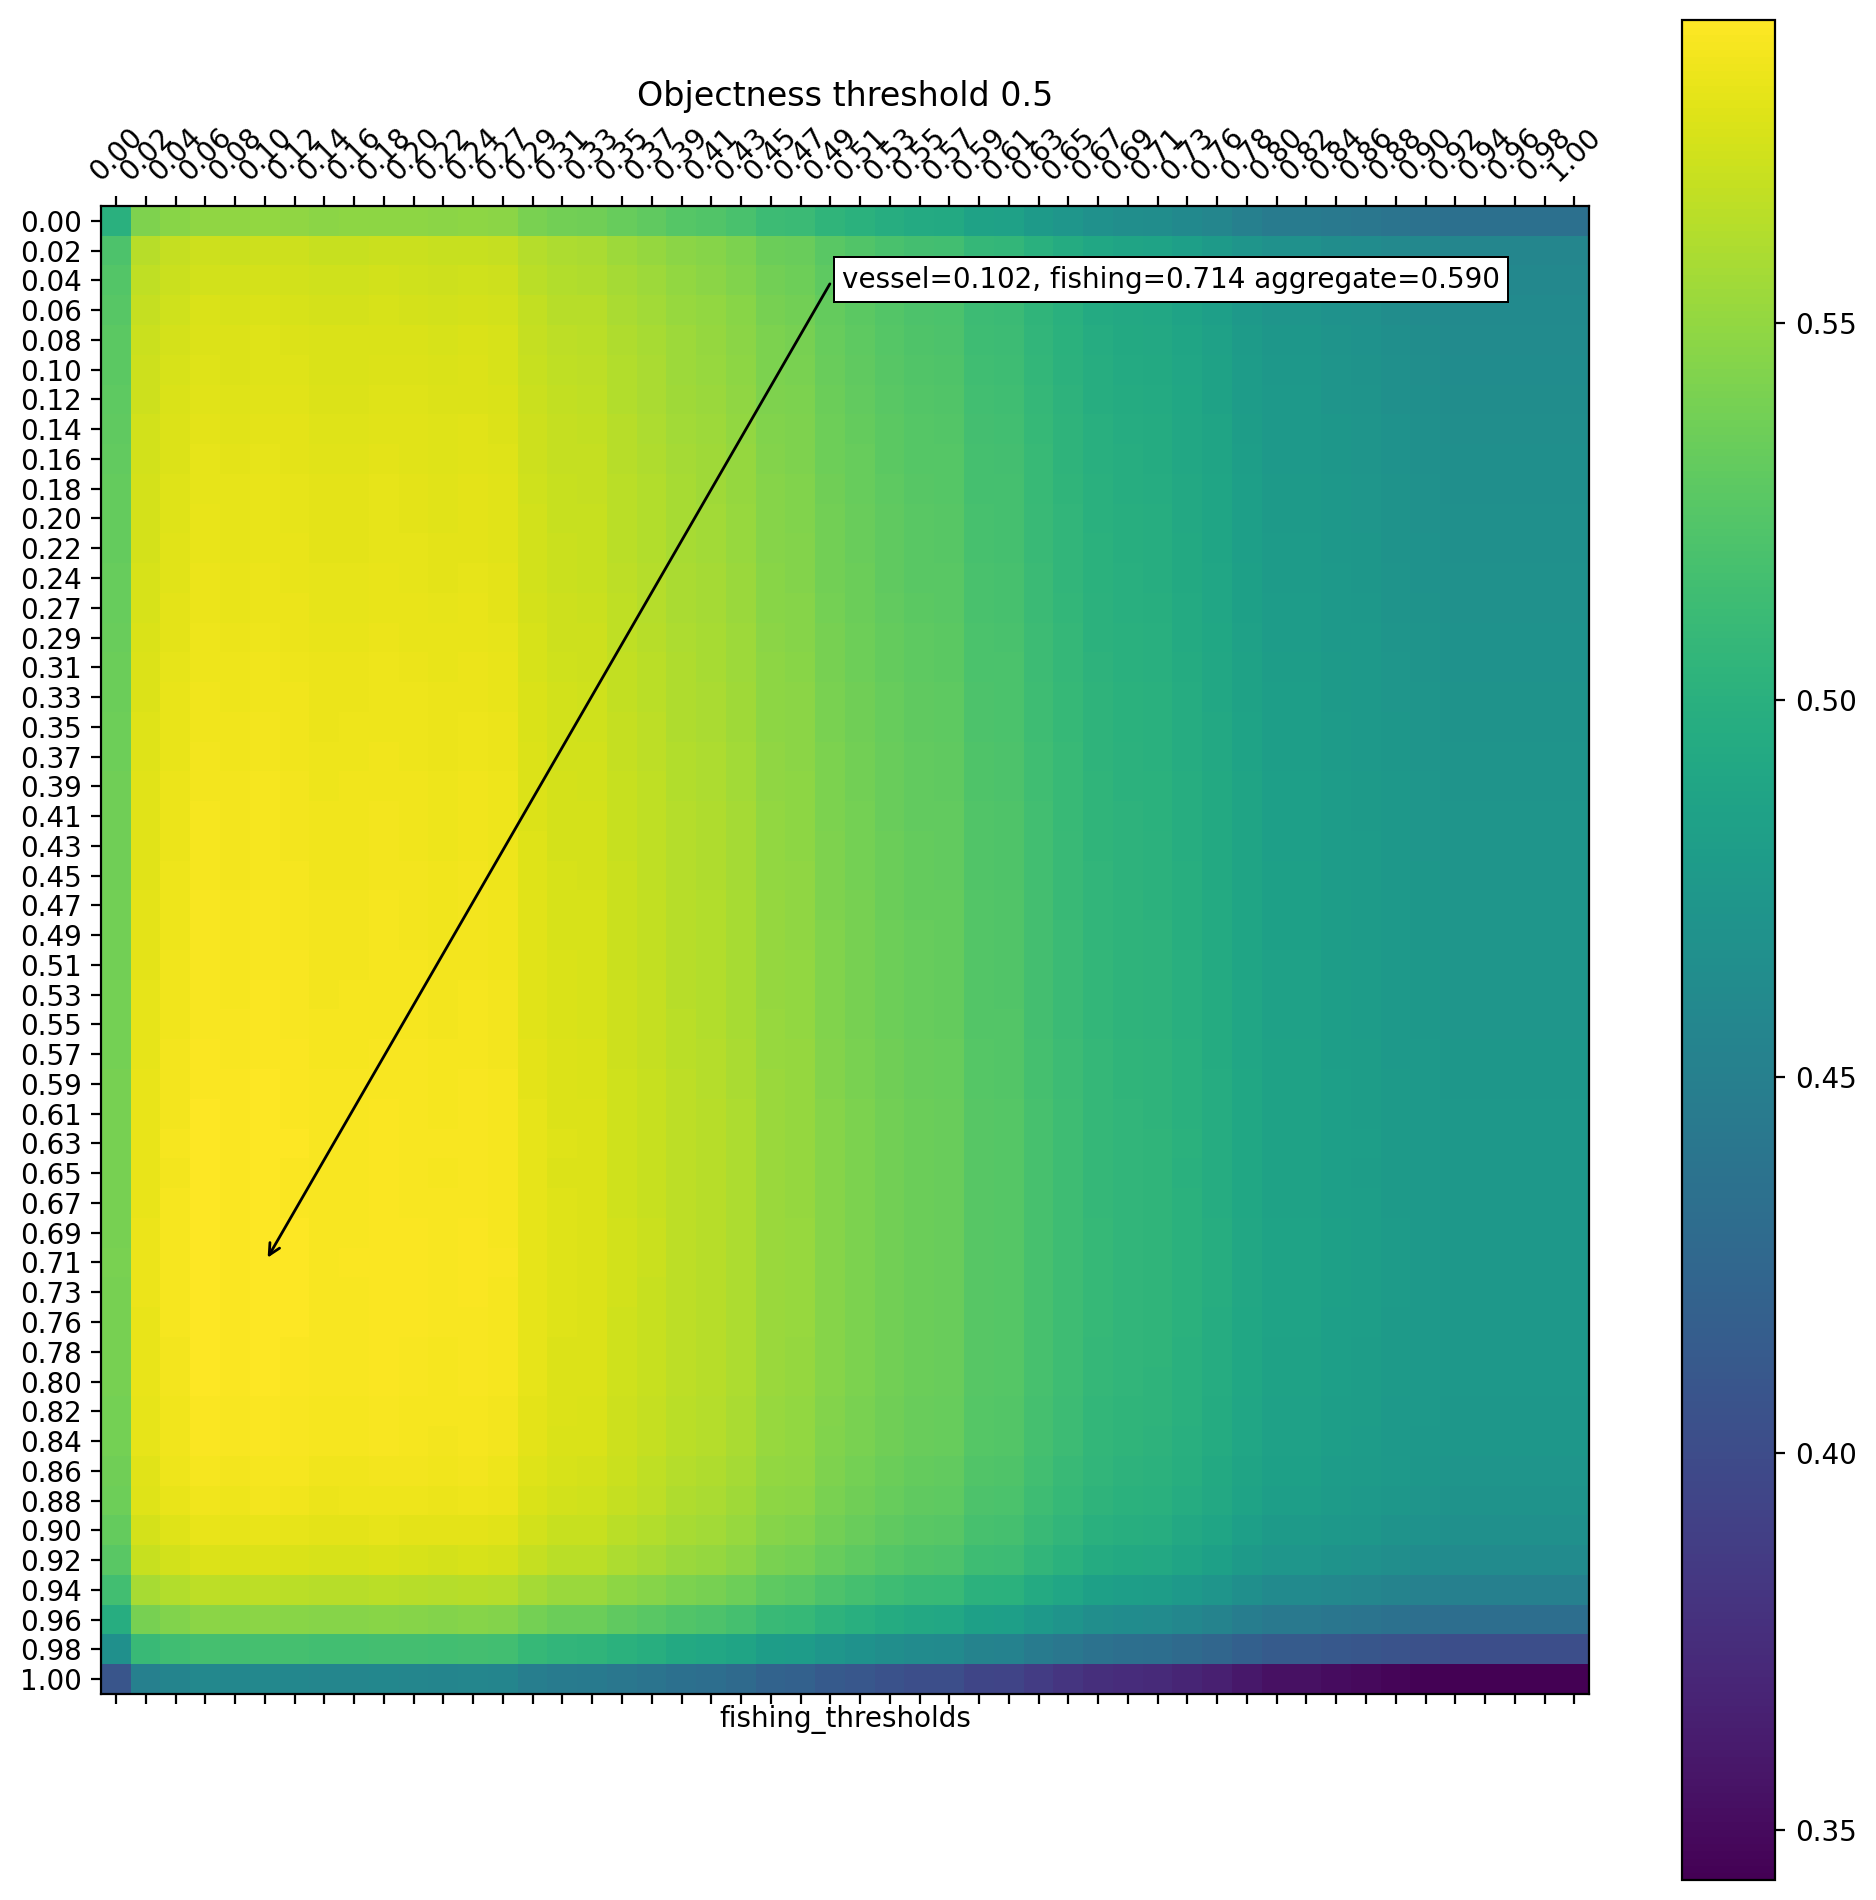

<ipython-input-20-488284eb5ea1>:70: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



<Figure size 3600x3600 with 0 Axes>

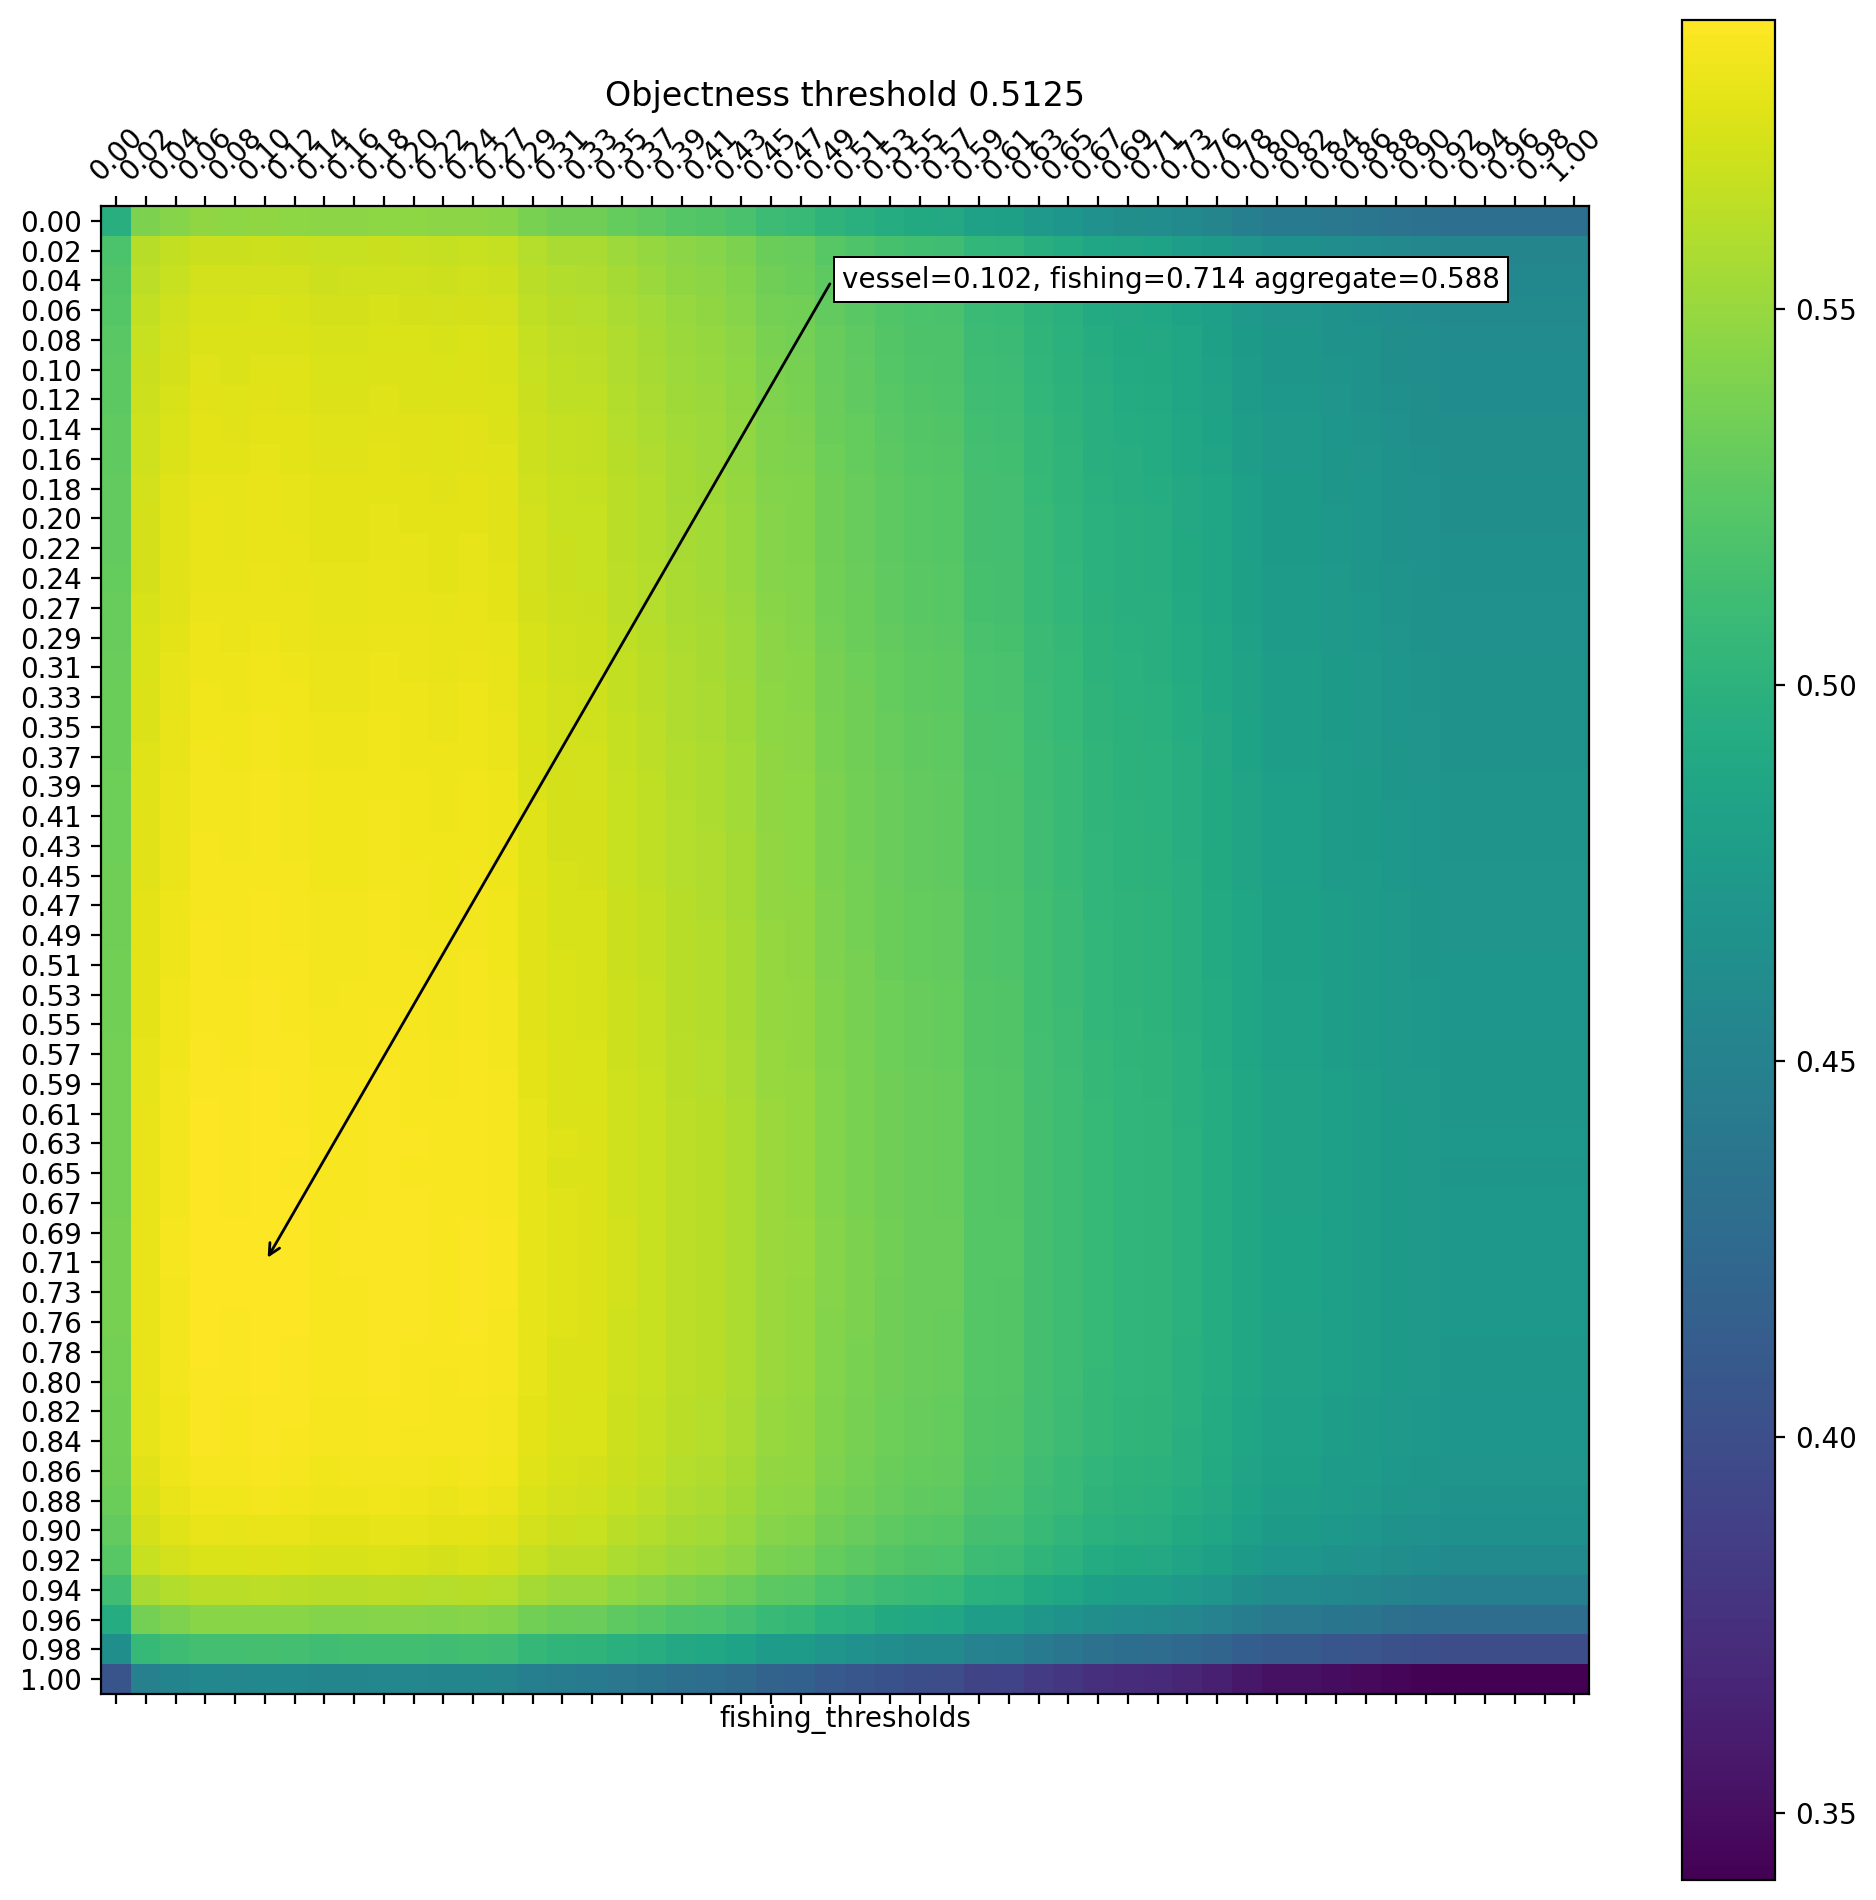

<ipython-input-20-488284eb5ea1>:70: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



<Figure size 3600x3600 with 0 Axes>

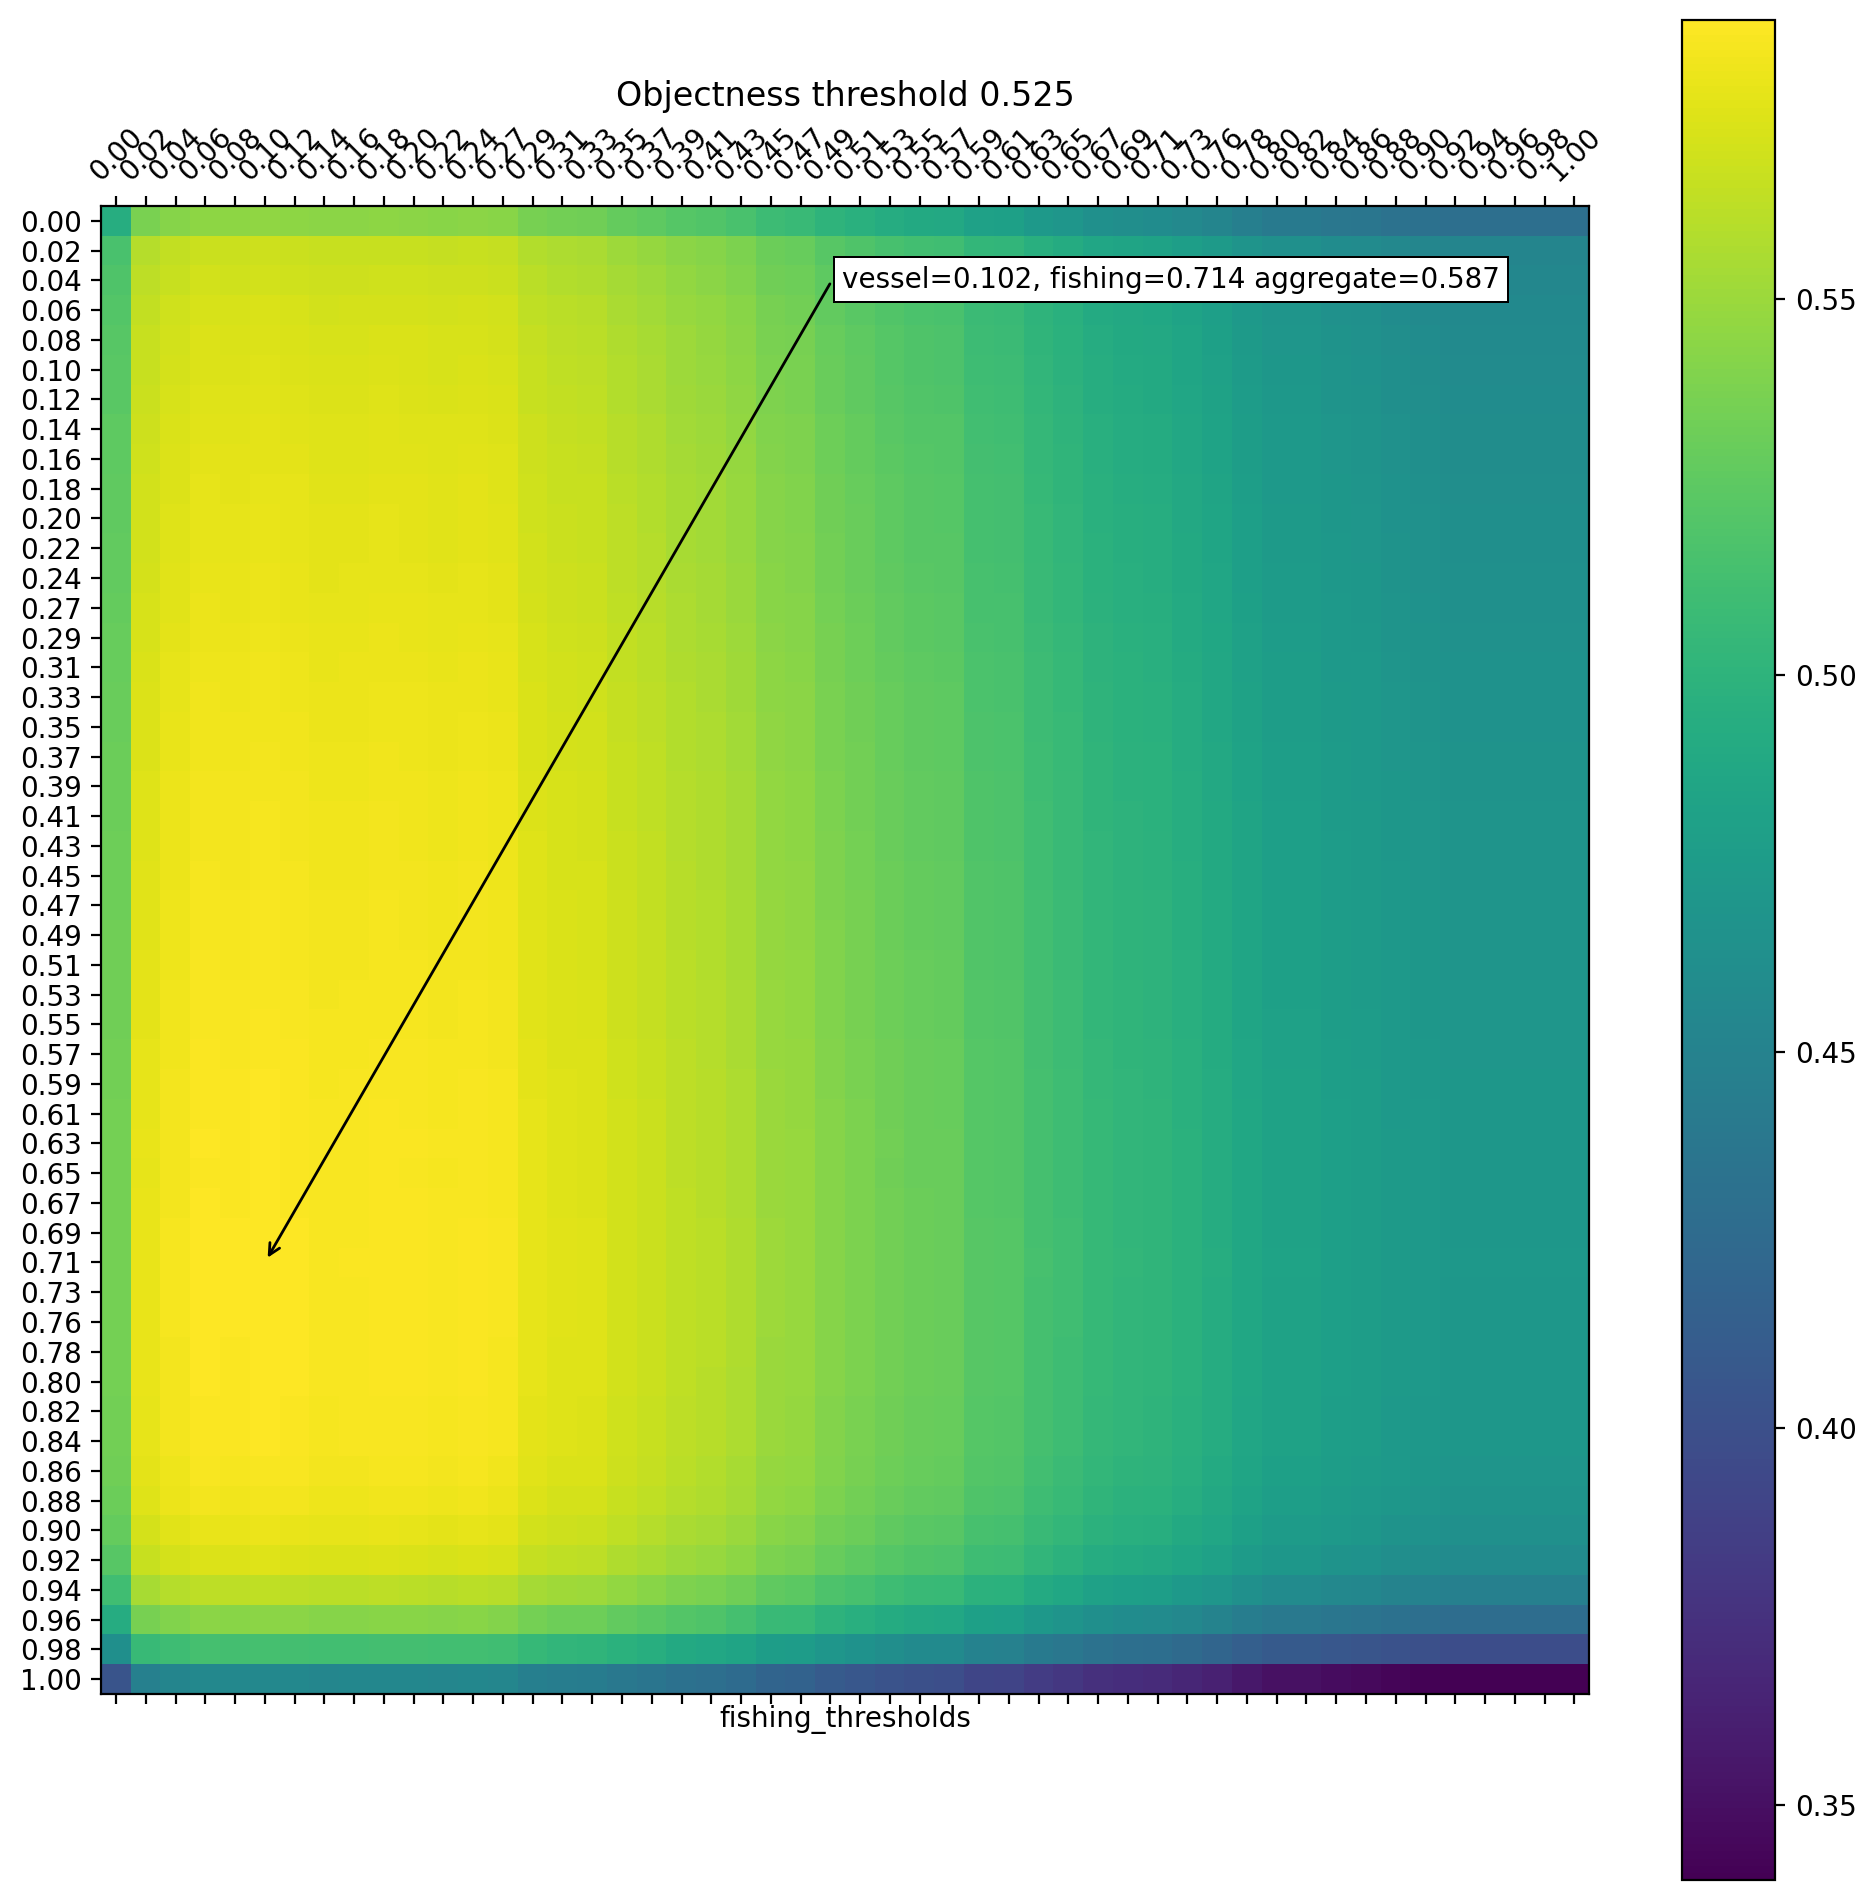

<ipython-input-20-488284eb5ea1>:70: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



<Figure size 3600x3600 with 0 Axes>

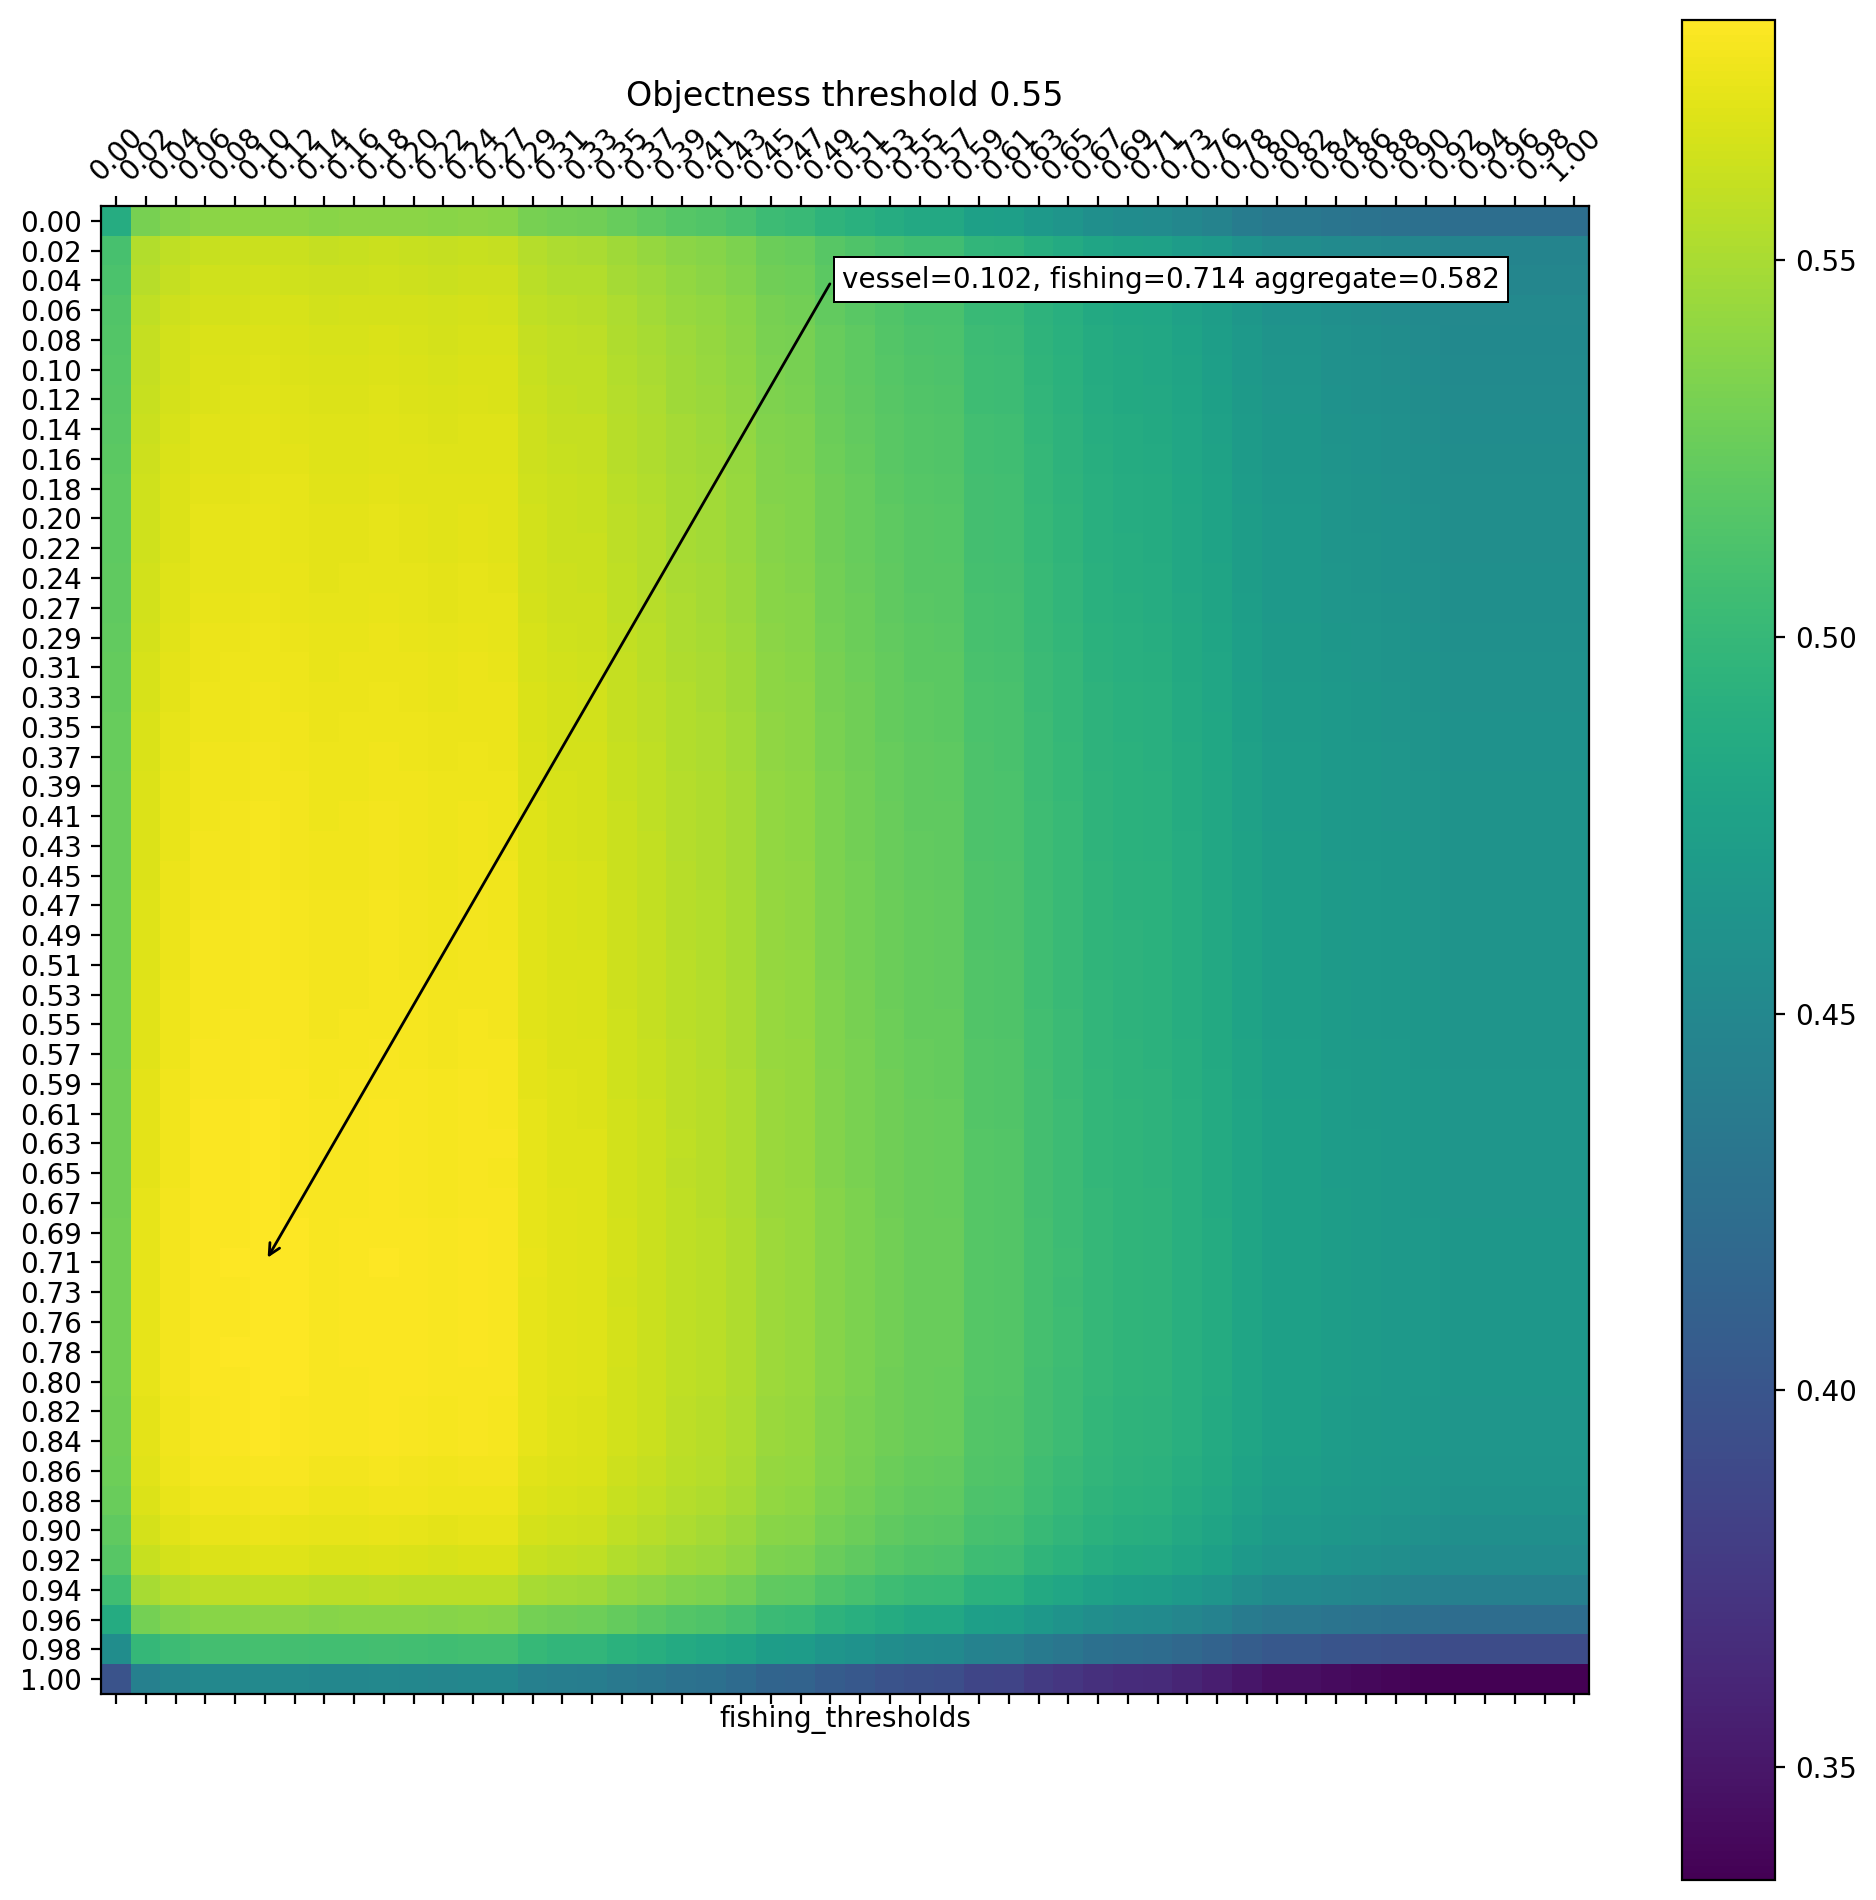

loc_fscore  loc_fscore_shore  vessel_fscore  fishing_fscore  length_acc  \
1755     0.79516          0.477541       0.879449        0.723514    0.630893   
1705     0.79516          0.477541       0.879029        0.723514    0.630893   
1805     0.79516          0.477541       0.878951        0.723514    0.630893   
1855     0.79516          0.477541       0.878163        0.723514    0.630893   
1753     0.79516          0.477541       0.879449        0.722222    0.630893   
1703     0.79516          0.477541       0.879029        0.722222    0.630893   
1803     0.79516          0.477541       0.878951        0.722222    0.630893   
1555     0.79516          0.477541       0.877323        0.723514    0.630893   
1655     0.79516          0.477541       0.877259        0.723514    0.630893   
1853     0.79516          0.477541       0.878163        0.722222    0.630893   
1905     0.79516          0.477541       0.876572        0.723514    0.630893   
1605     0.79516          0.477541       0.876404        0.723514    0.630893   
1955     0.79516          0.477541       0.876342        0.723514    0.630893   
1505     0.79516          0.477541       0.876247        0.723514    0.630893   
1553     0.79516          0.477541       0.877323        0.722222    0.630893   
1653     0.79516          0.477541       0.877259        0.722222    0.630893   
1756     0.79516          0.477541       0.879449        0.719577    0.630893   
1903     0.79516          0.477541       0.876572        0.722222    0.630893   
1603     0.79516          0.477541       0.876404        0.722222    0.630893   
1706     0.79516          0.477541       0.879029        0.719577    0.630893   

      aggregate  is_vessel_threshold  is_fishing_threshold  \
1755   0.590231             0.714286              0.102041   
1705   0.590164             0.693878              0.102041   
1805   0.590152             0.734694              0.102041   
1855   0.590027             0.755102              0.102041   
1753   0.590026             0.714286              0.061224   
1703   0.589959             0.693878              0.061224   
1803   0.589947             0.734694              0.061224   
1555   0.589893             0.632653              0.102041   
1655   0.589883             0.673469              0.102041   
1853   0.589821             0.755102              0.061224   
1905   0.589774             0.775510              0.102041   
1605   0.589747             0.653061              0.102041   
1955   0.589737             0.795918              0.102041   
1505   0.589722             0.612245              0.102041   
1553   0.589688             0.632653              0.061224   
1653   0.589677             0.673469              0.061224   
1756   0.589605             0.714286              0.122449   
1903   0.589568             0.775510              0.061224   
1603   0.589541             0.653061              0.061224   
1706   0.589538             0.693878              0.122449   

      objectness_threshold  
1755                   0.5  
1705                   0.5  
1805                   0.5  
1855                   0.5  
1753                   0.5  
1703                   0.5  
1803                   0.5  
1555                   0.5  
1655                   0.5  
1853                   0.5  
1905                   0.5  
1605                   0.5  
1955                   0.5  
1505                   0.5  
1553                   0.5  
1653                   0.5  
1756                   0.5  
1903                   0.5  
1603                   0.5  
1706                   0.5

In [25]:
vanilla_box_coder = MultilabelCircleNetCoder(
    (2048,2048), output_stride=4, max_objects=2048, heatmap_encoding="umich", labels_encoding="circle", ignore_value=IGNORE_LABEL,
    fixed_radius=3,
    labels_radius=3,
    nms_method=centernet_tight_heatmap_nms,
    nms_kernel_size=3)

vanilla_predictions = decode_predictions(predicted_scenes_paths, vanilla_box_coder)
centernet_tight_heatmap_nms_ks_3 = compute_optimal_thresholds(
    predictions=vanilla_predictions,
    groundtruths=groundtruth,
    shore_root=shore_root,
    objectness_thresholds=objectness_thresholds,
)
centernet_tight_heatmap_nms_ks_3.to_csv("centernet_tight_heatmap_nms_ks_3", index=False)
plot_visualizations(centernet_tight_heatmap_nms_ks_3)
centernet_tight_heatmap_nms_ks_3.head(20)

Computing optimal vessel & fishing thresholds:   0%|          | 0/7 [00:00<?, ?it/s]

Computing optimal thresholds
objectness_thresholds [0.45   0.475  0.4875 0.5    0.5125 0.525  0.55  ]


Computing optimal vessel & fishing thresholds: 100%|██████████| 7/7 [04:35<00:00, 39.38s/it] 
<ipython-input-20-488284eb5ea1>:70: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



<Figure size 3600x3600 with 0 Axes>

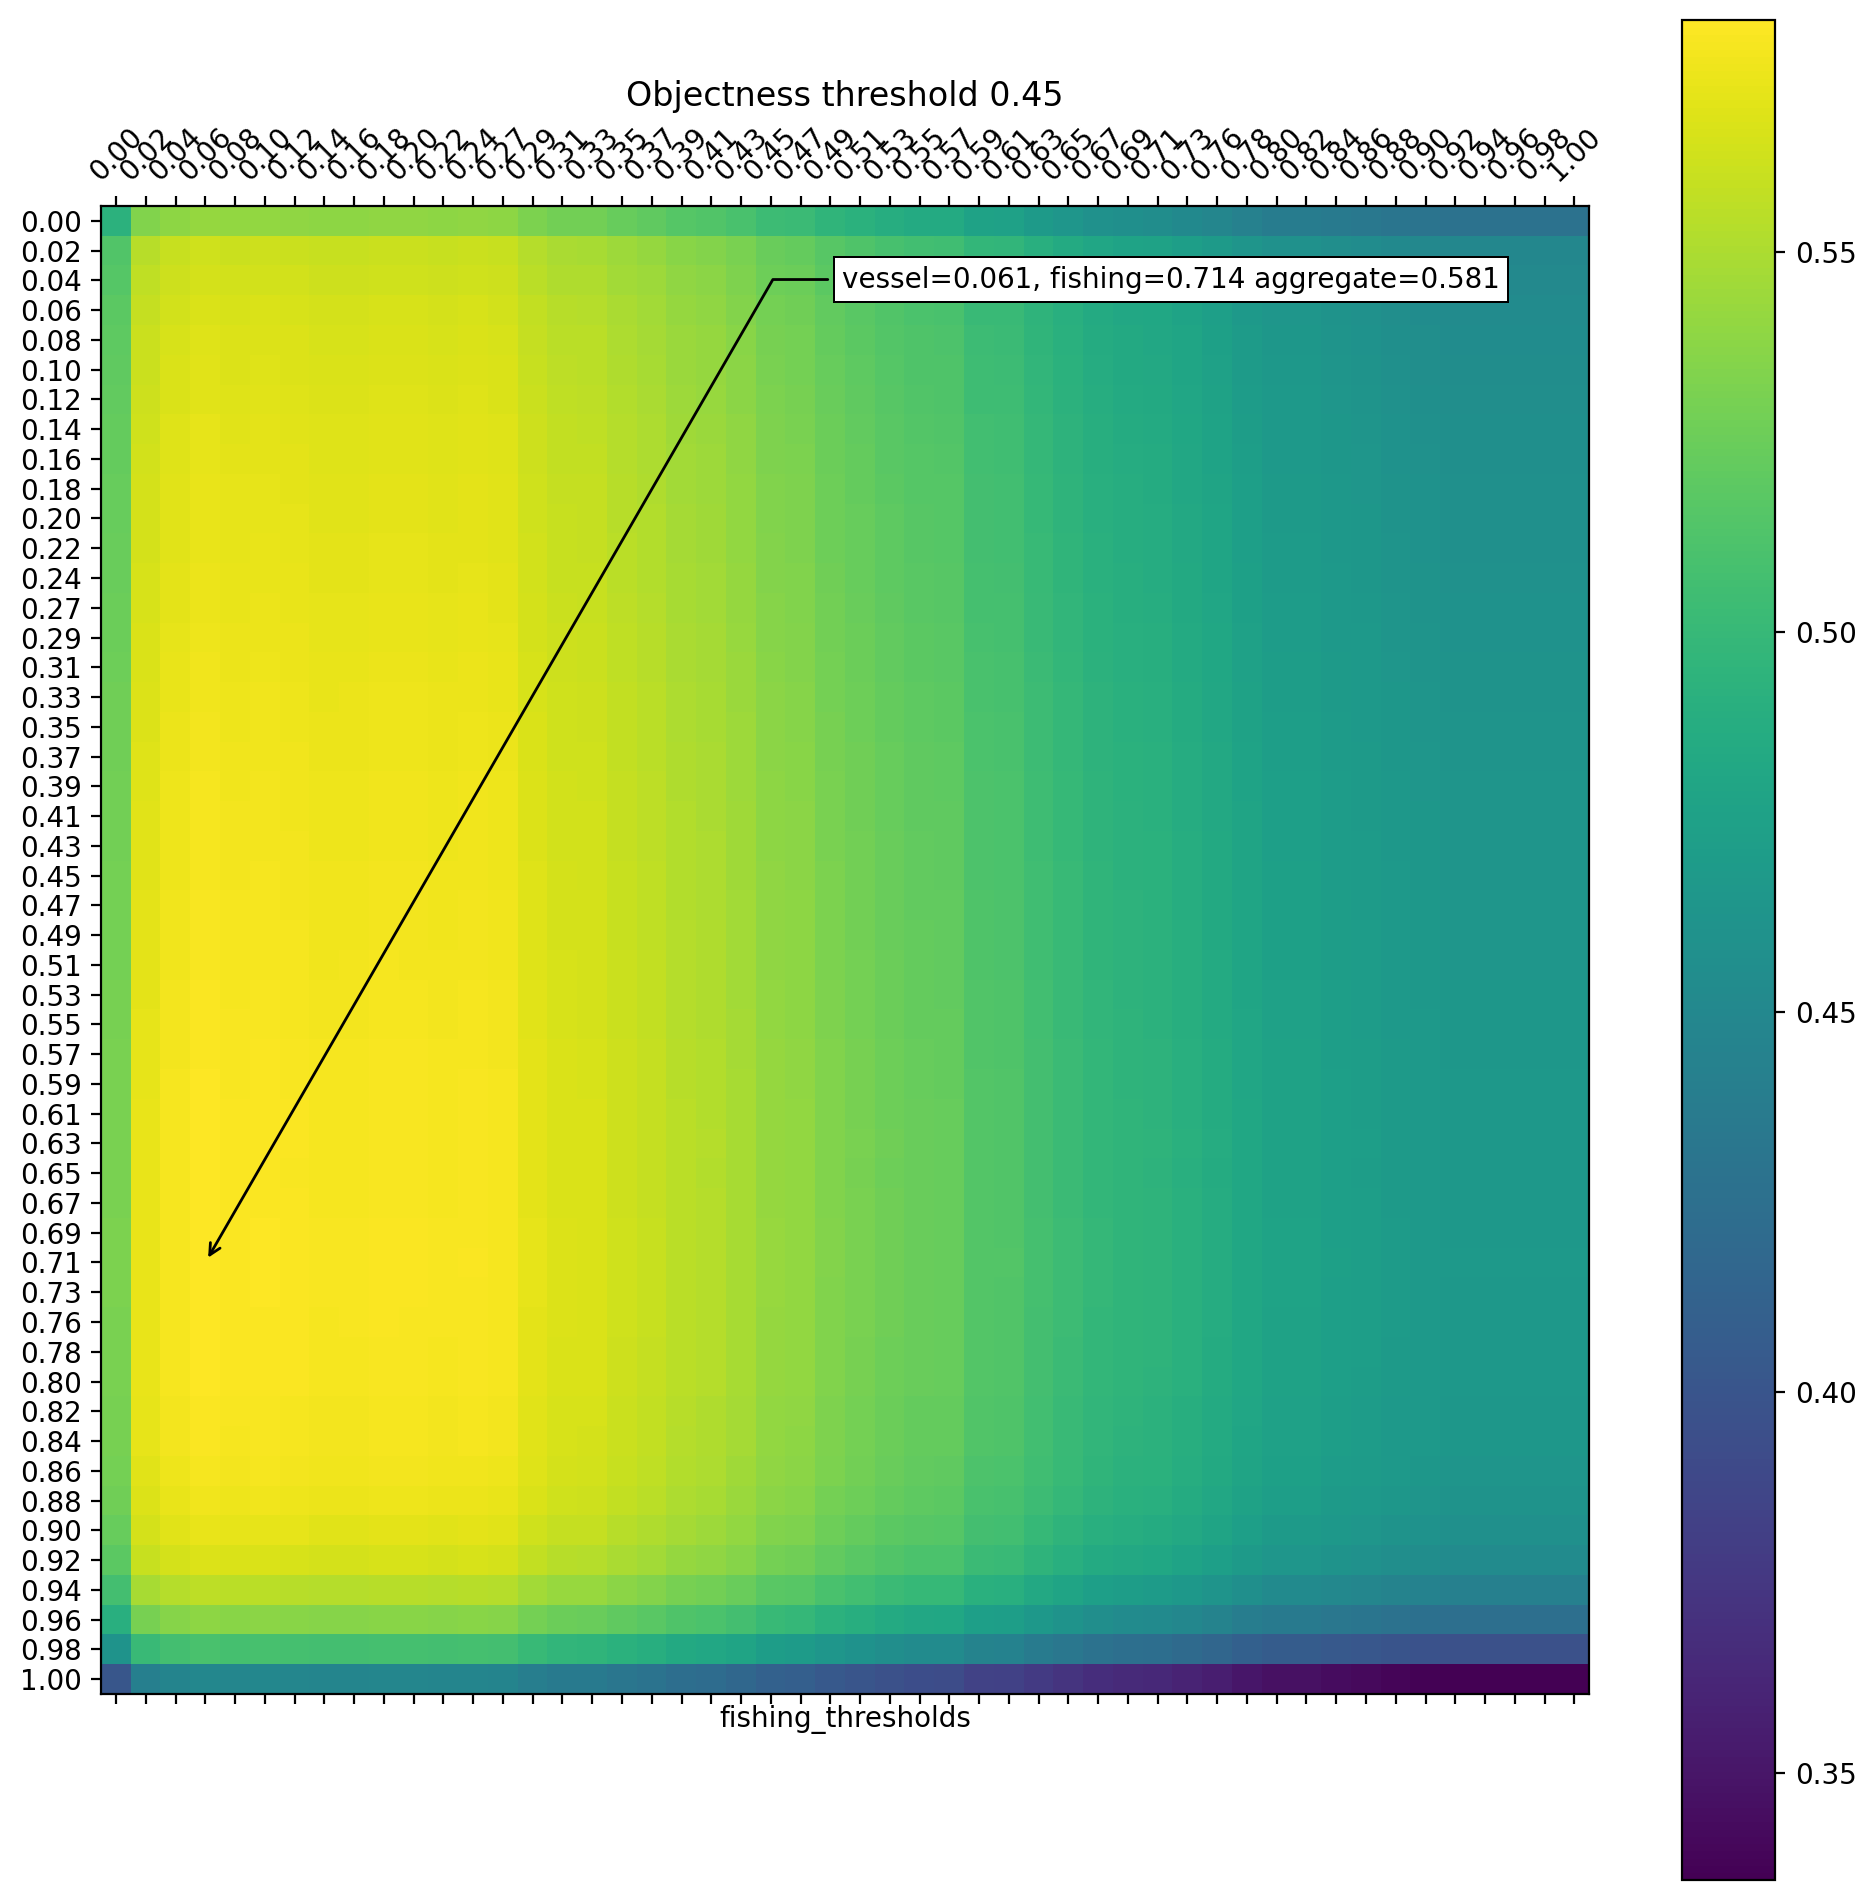

<ipython-input-20-488284eb5ea1>:70: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



<Figure size 3600x3600 with 0 Axes>

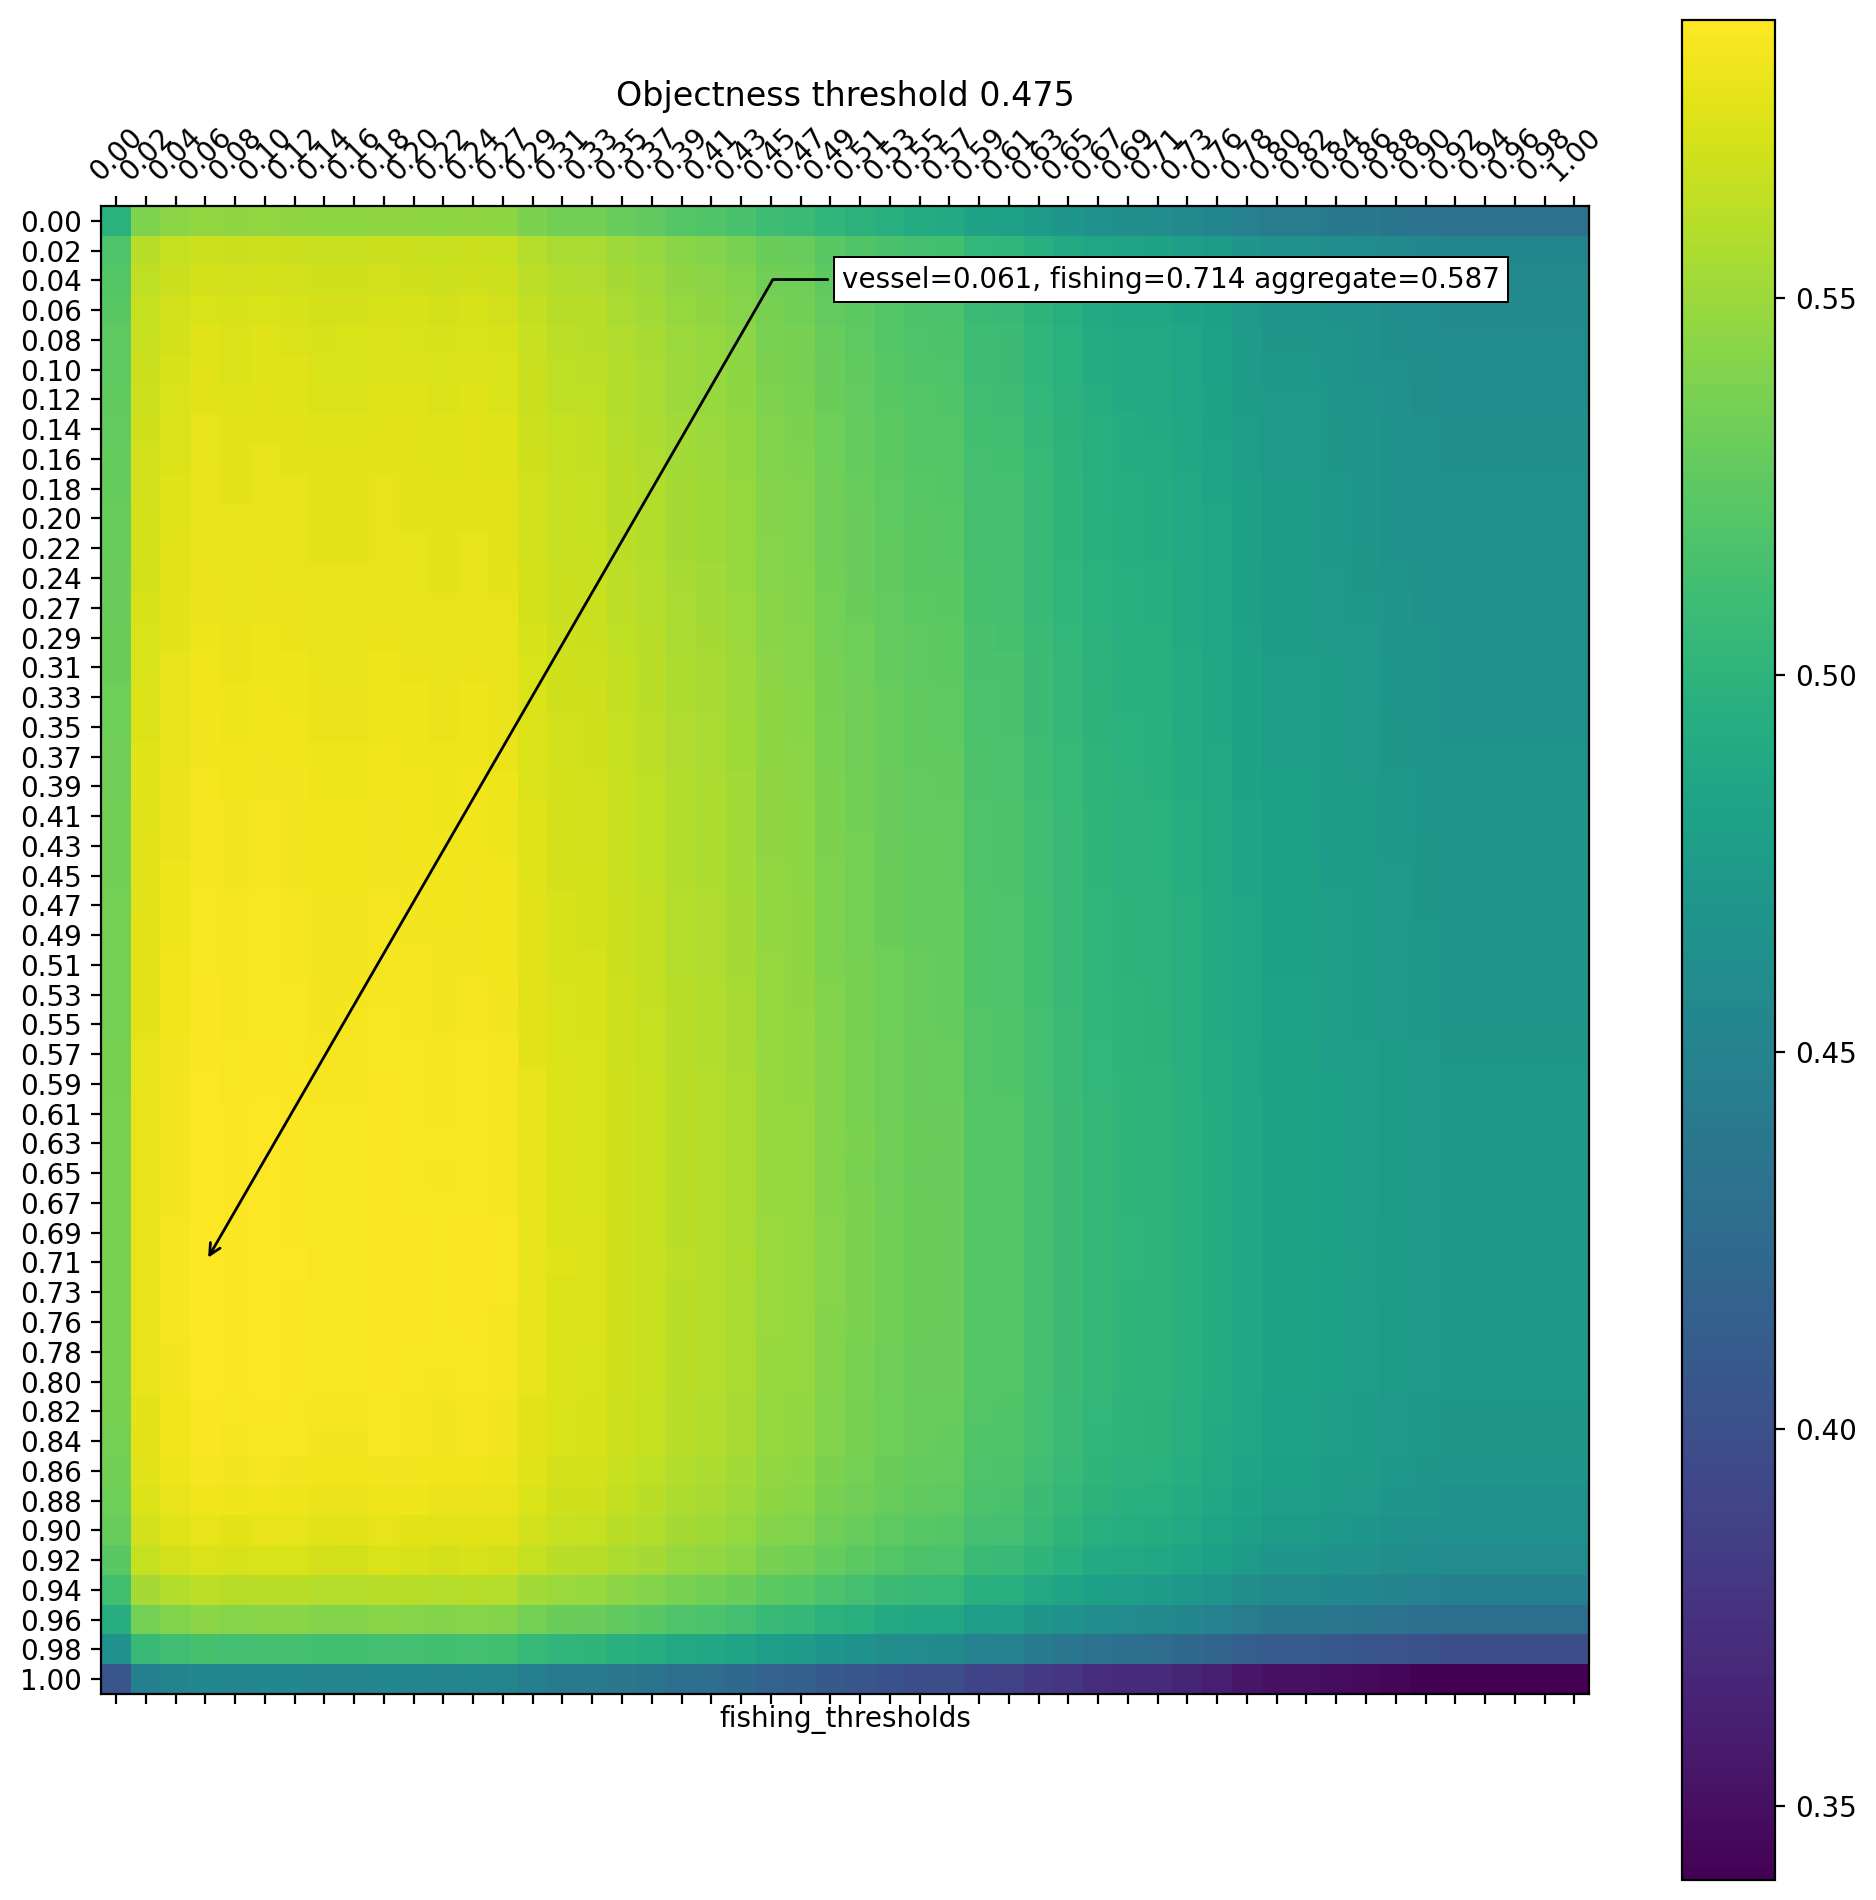

<ipython-input-20-488284eb5ea1>:70: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



<Figure size 3600x3600 with 0 Axes>

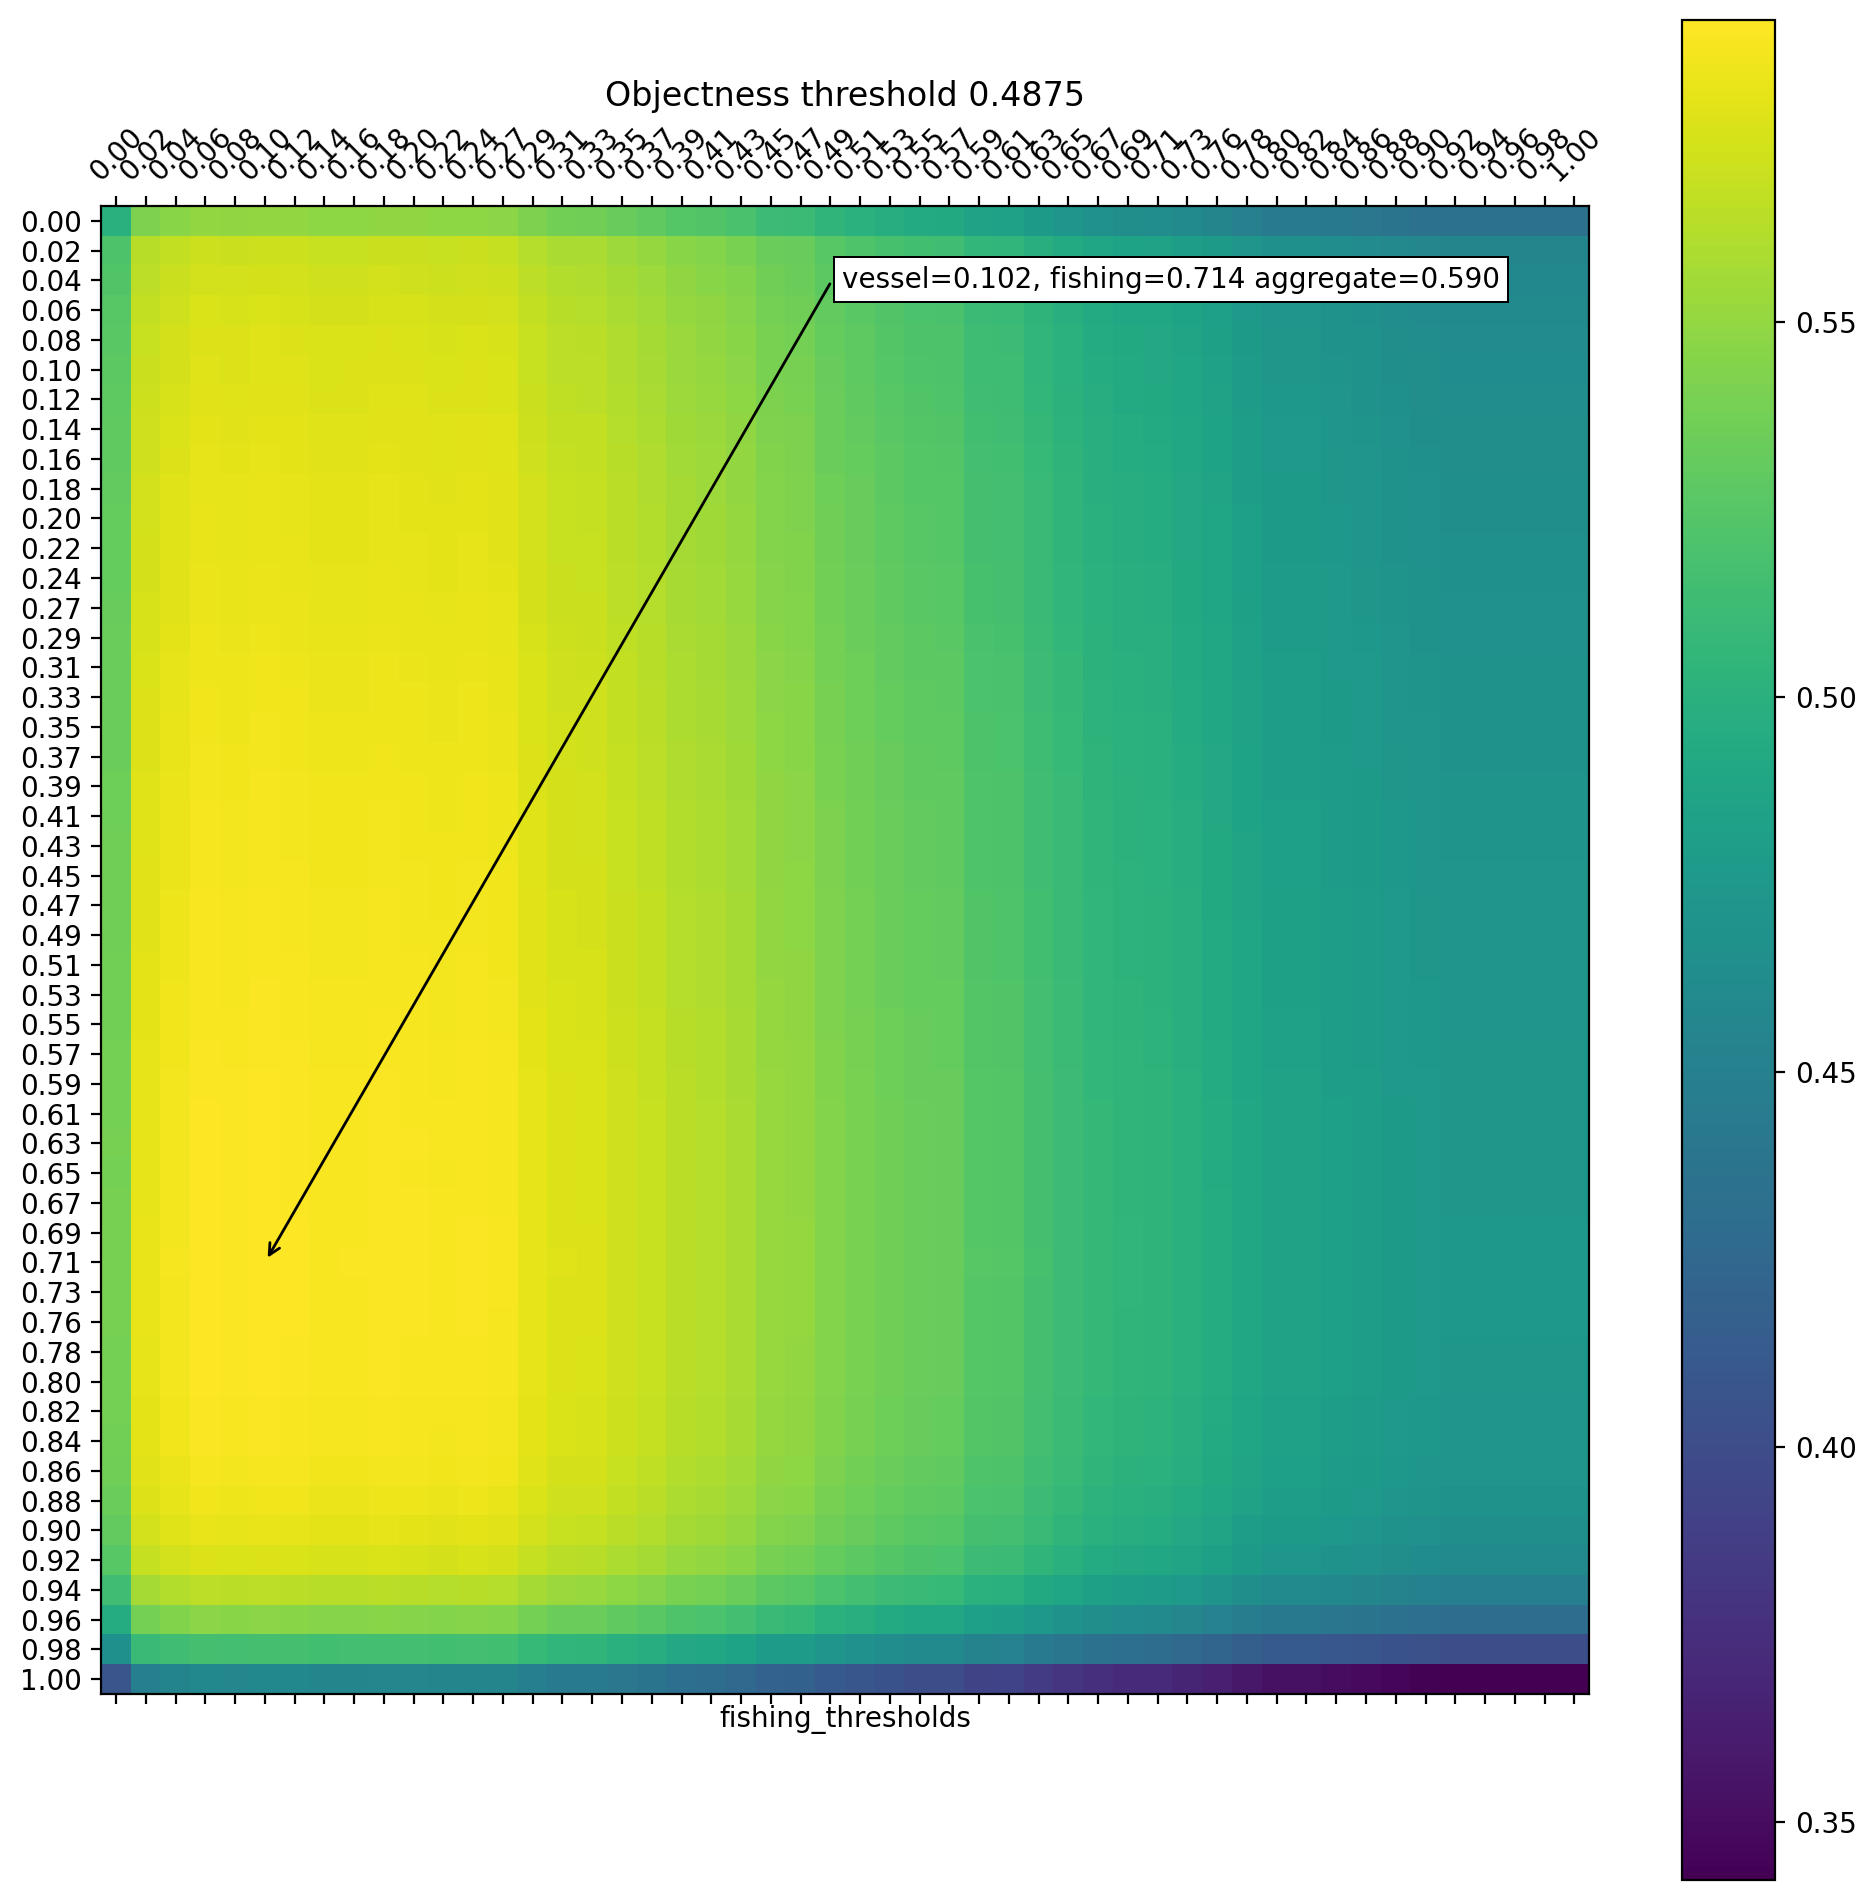

<ipython-input-20-488284eb5ea1>:70: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



<Figure size 3600x3600 with 0 Axes>

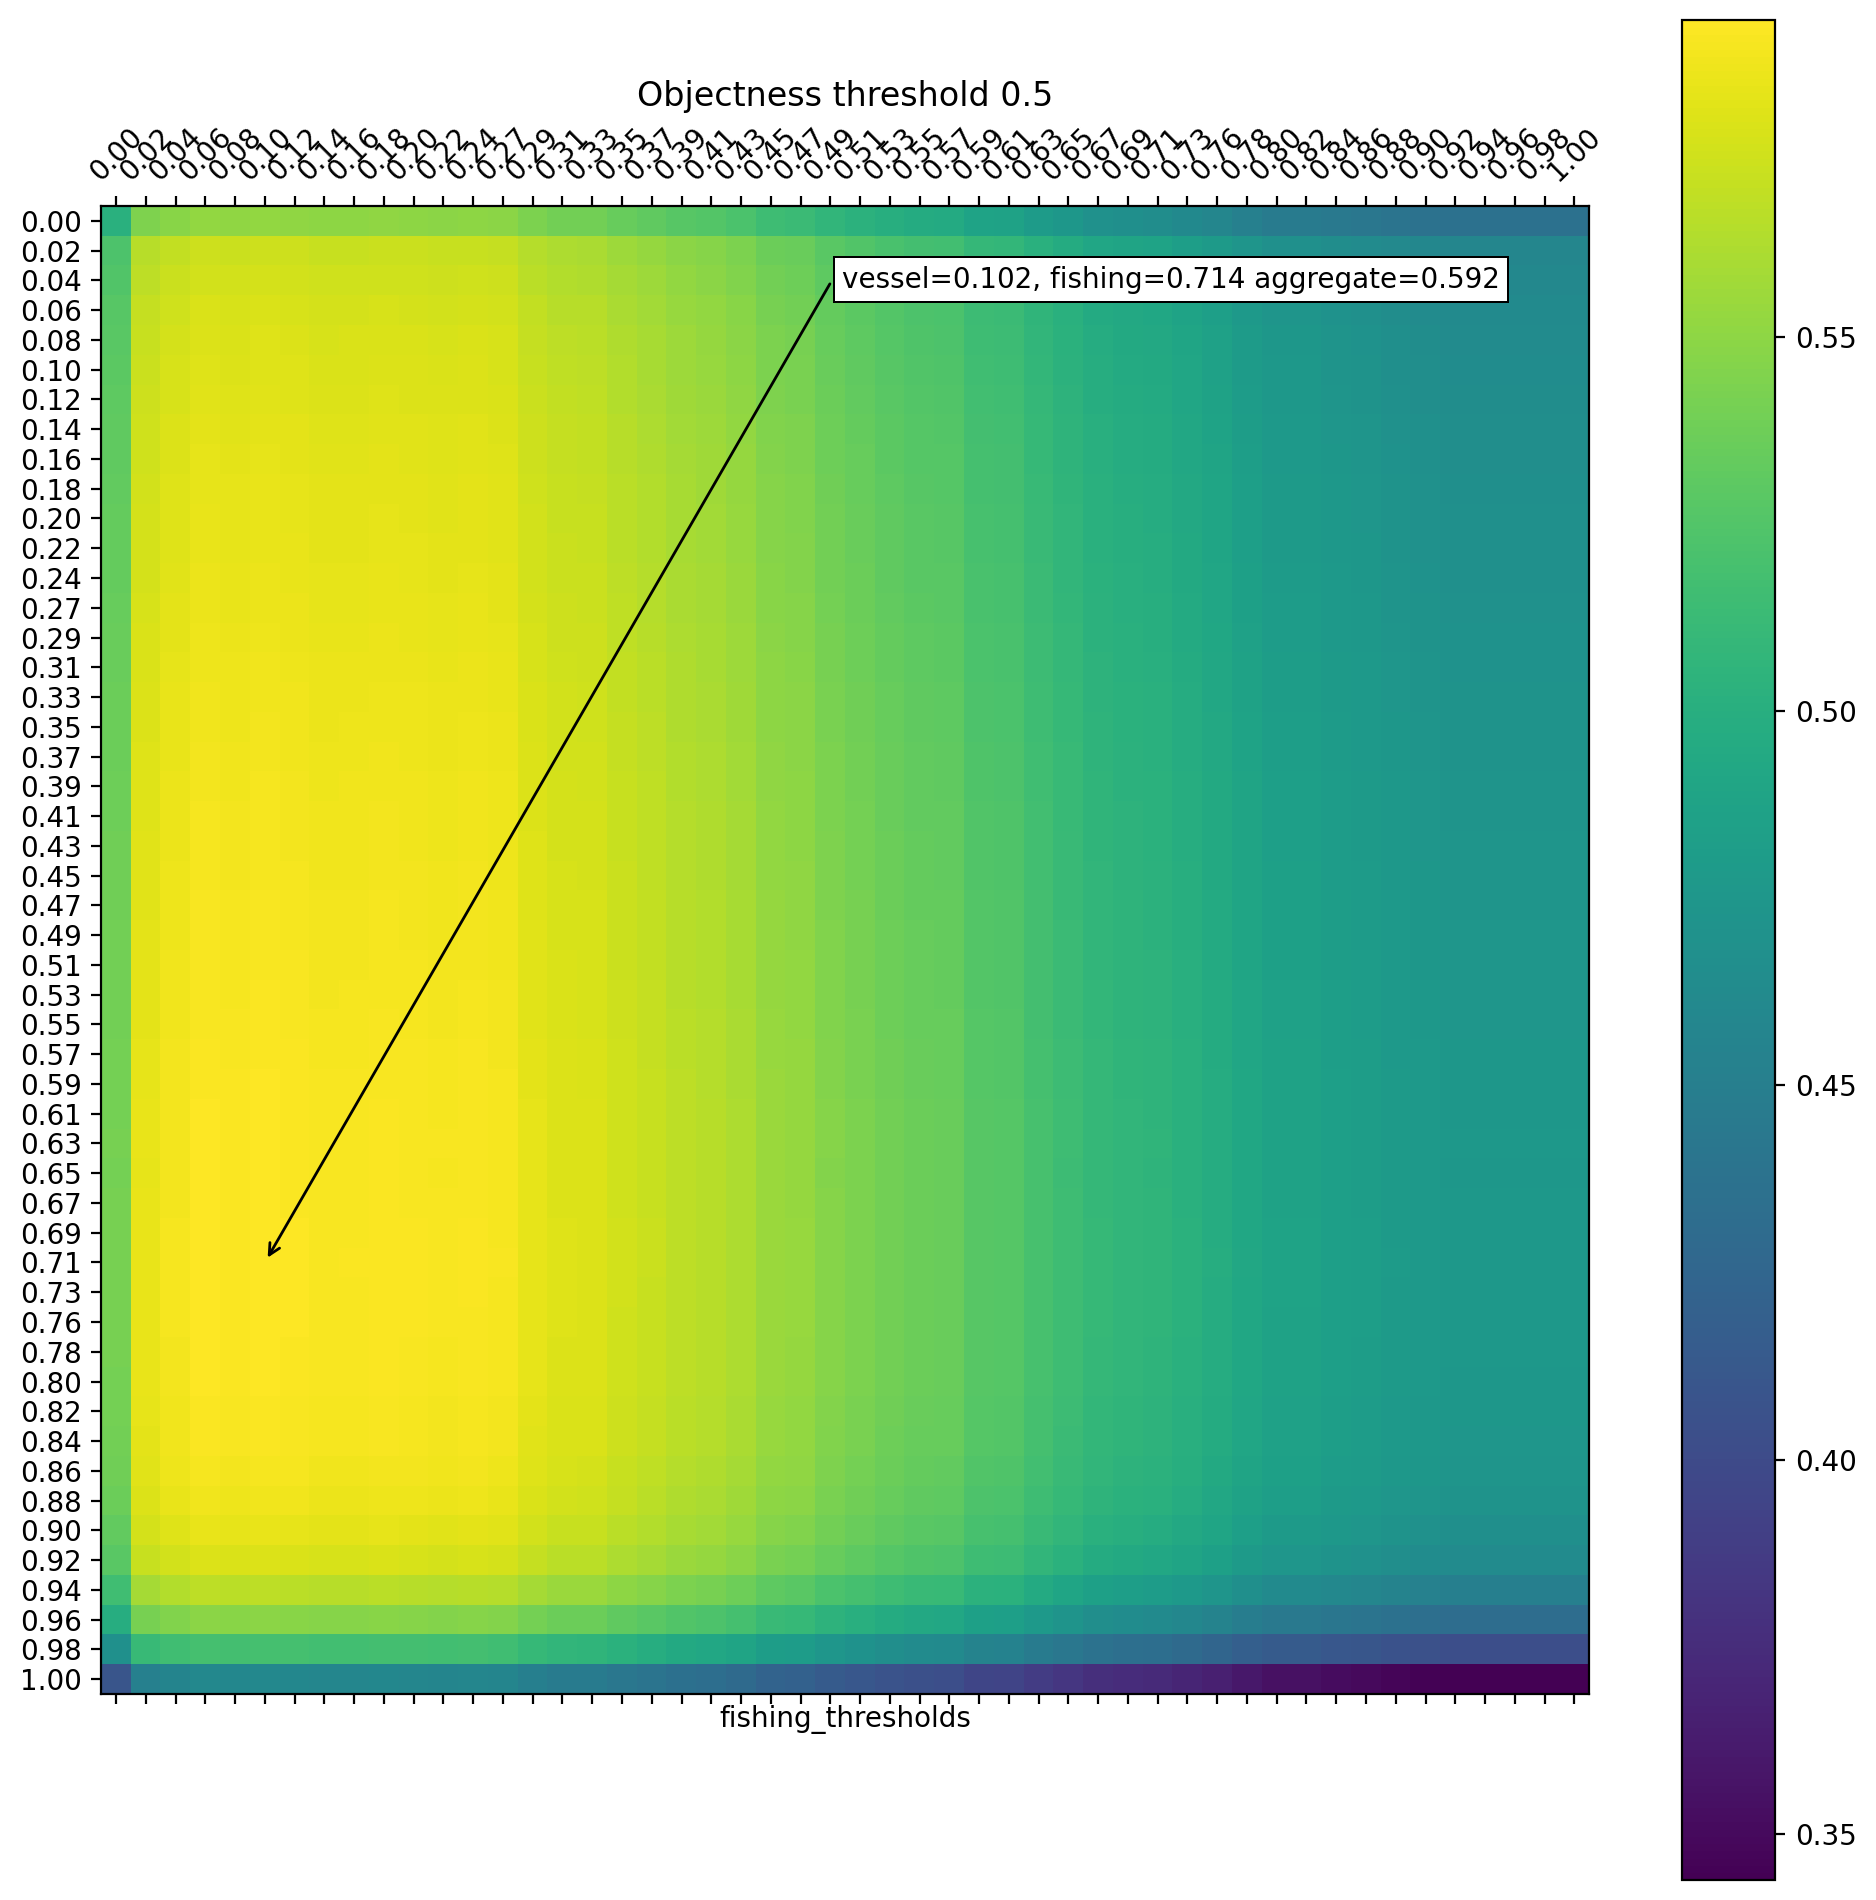

<ipython-input-20-488284eb5ea1>:70: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



<Figure size 3600x3600 with 0 Axes>

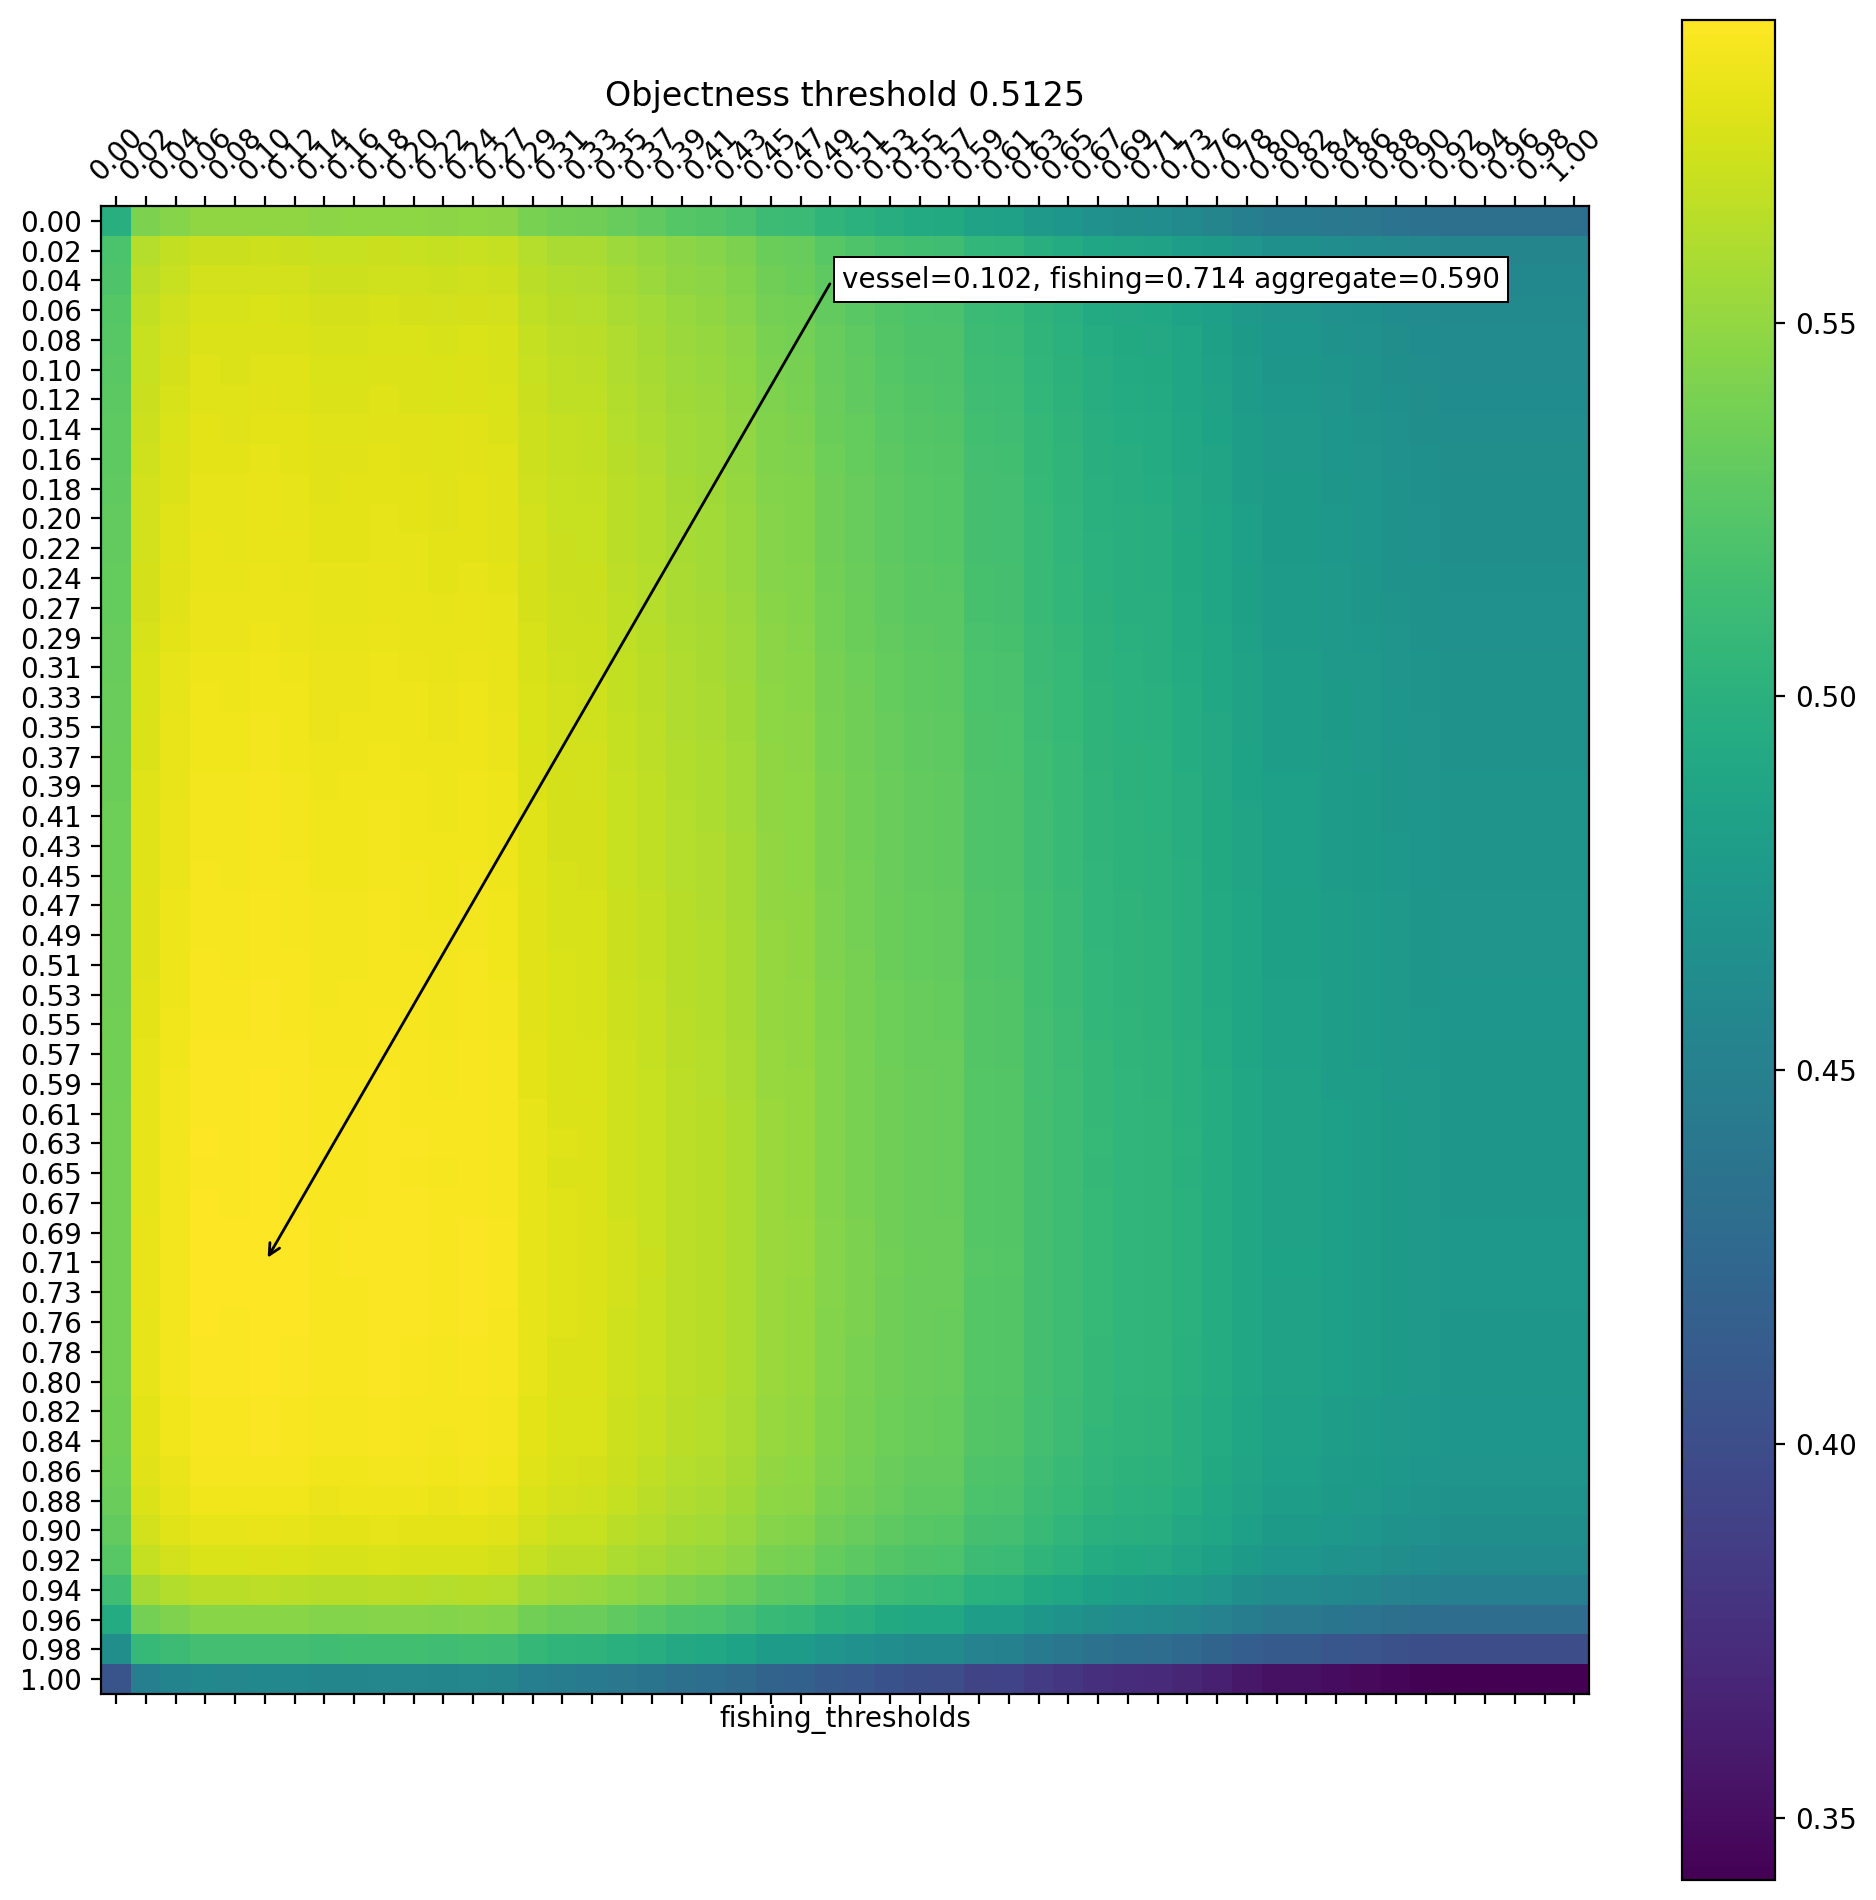

<ipython-input-20-488284eb5ea1>:70: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



<Figure size 3600x3600 with 0 Axes>

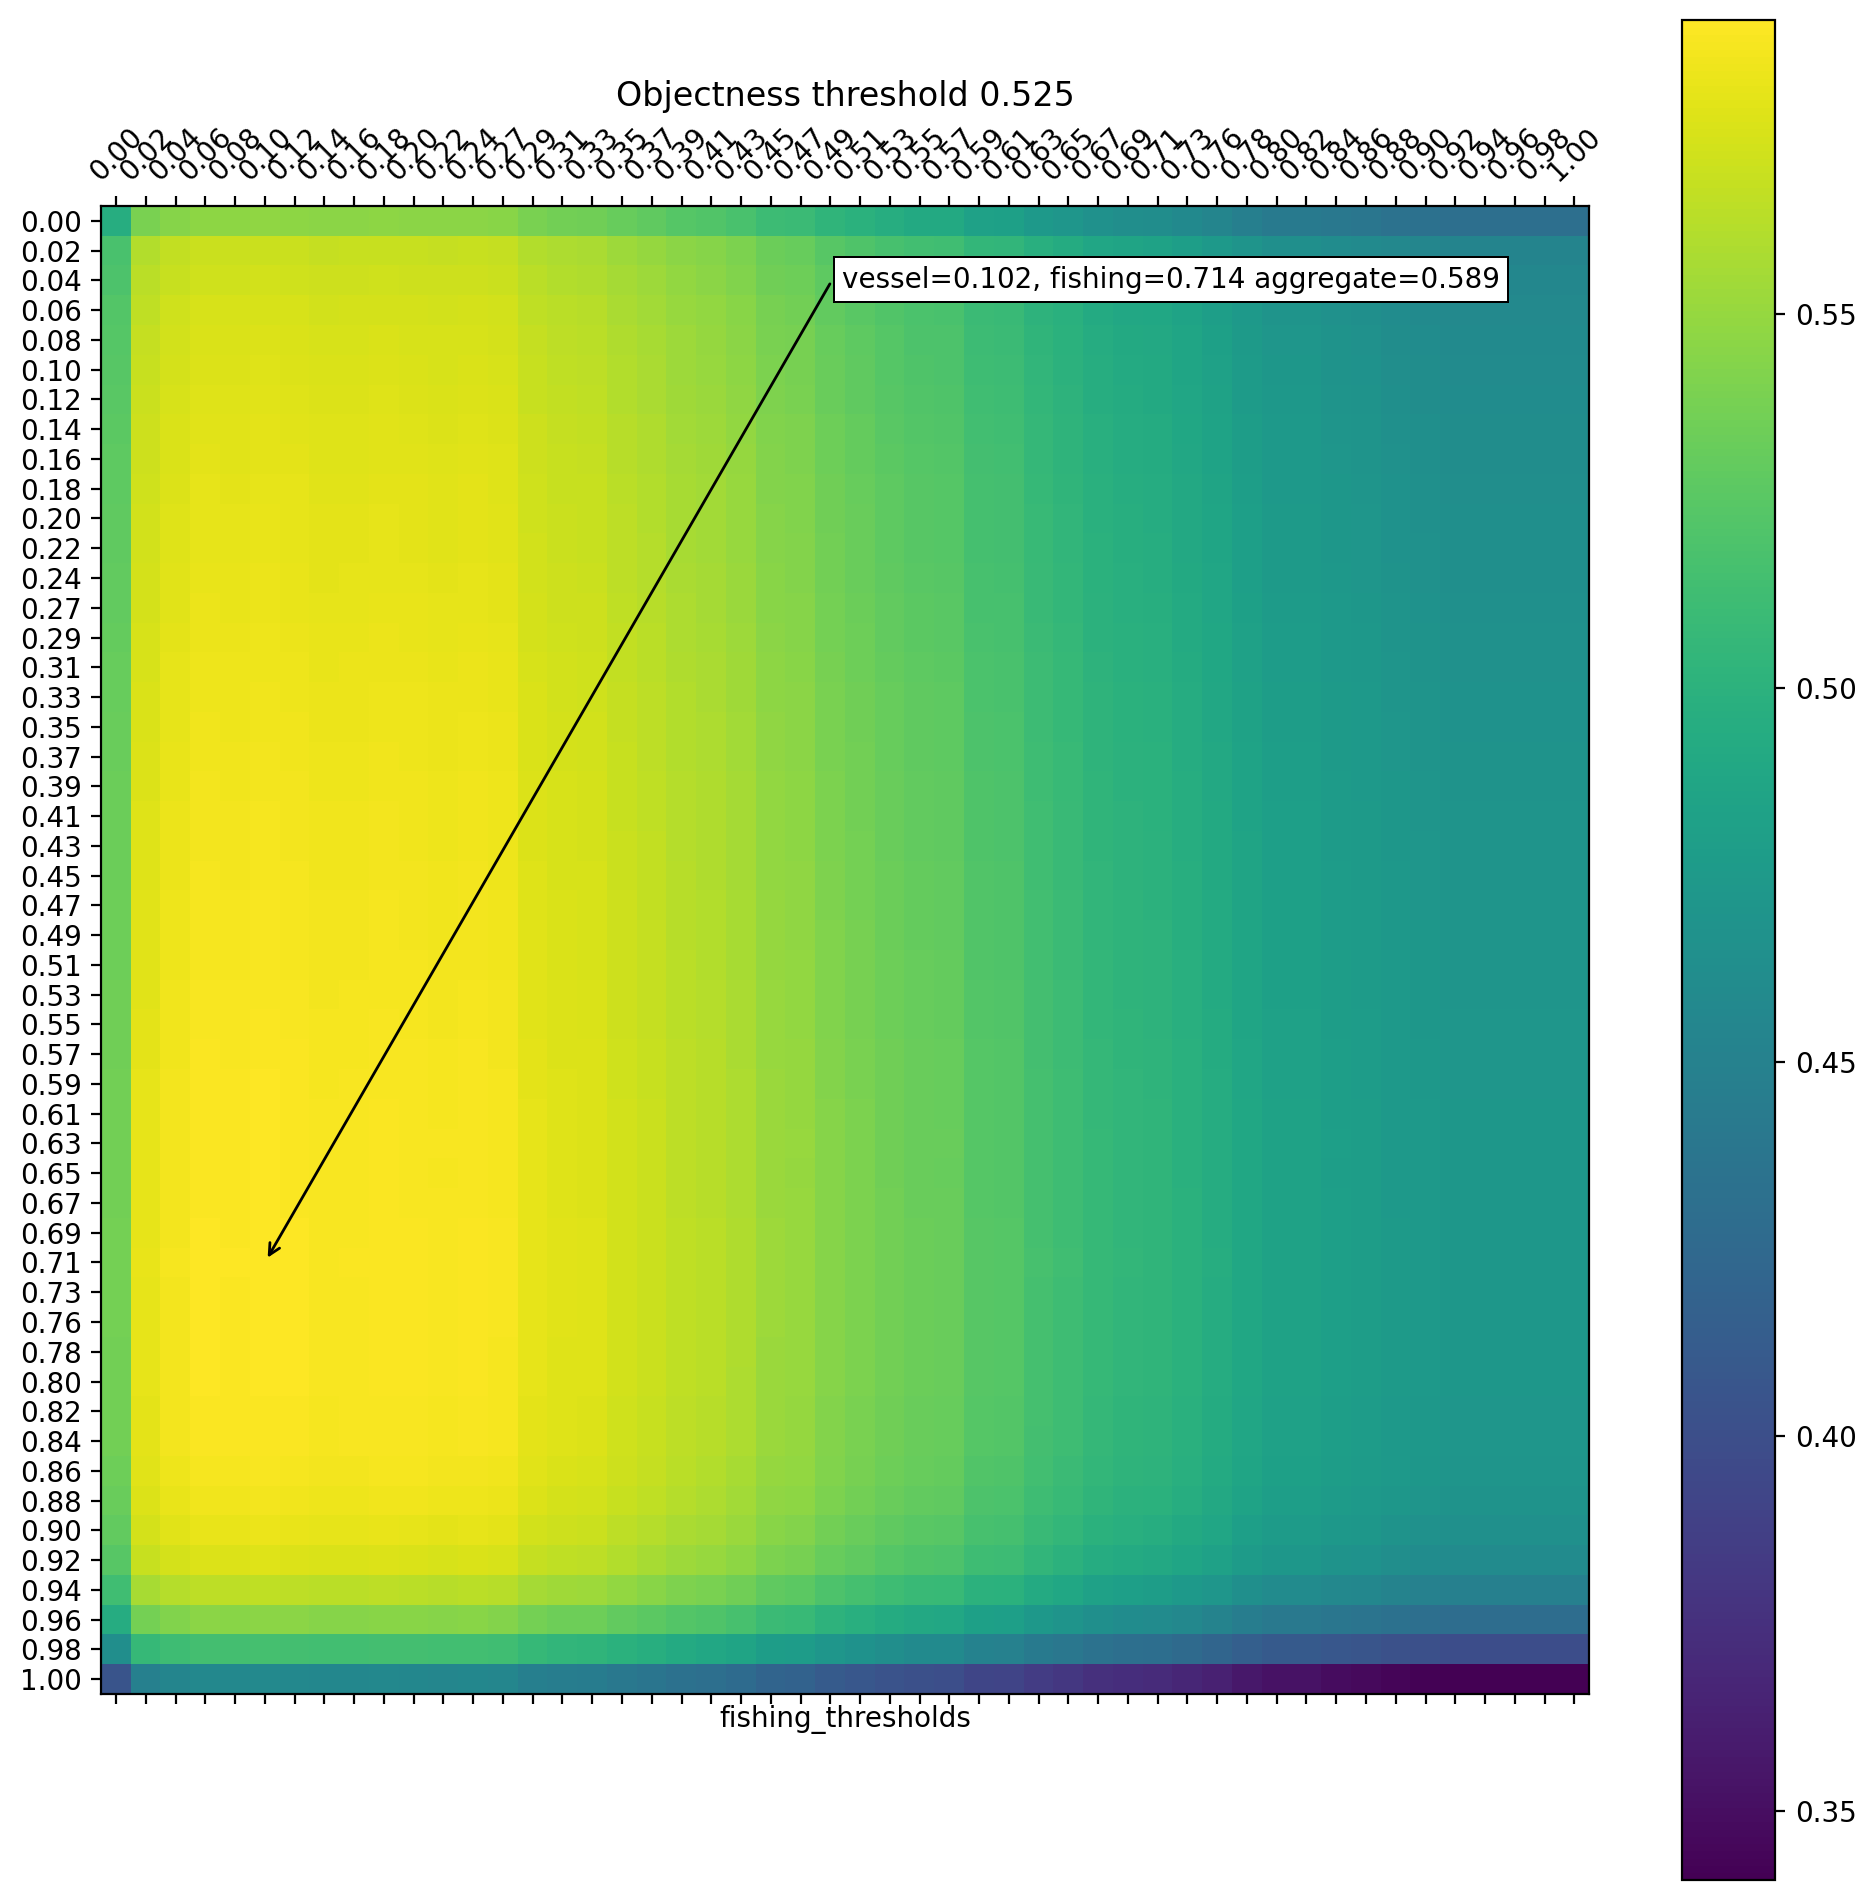

<ipython-input-20-488284eb5ea1>:70: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



<Figure size 3600x3600 with 0 Axes>

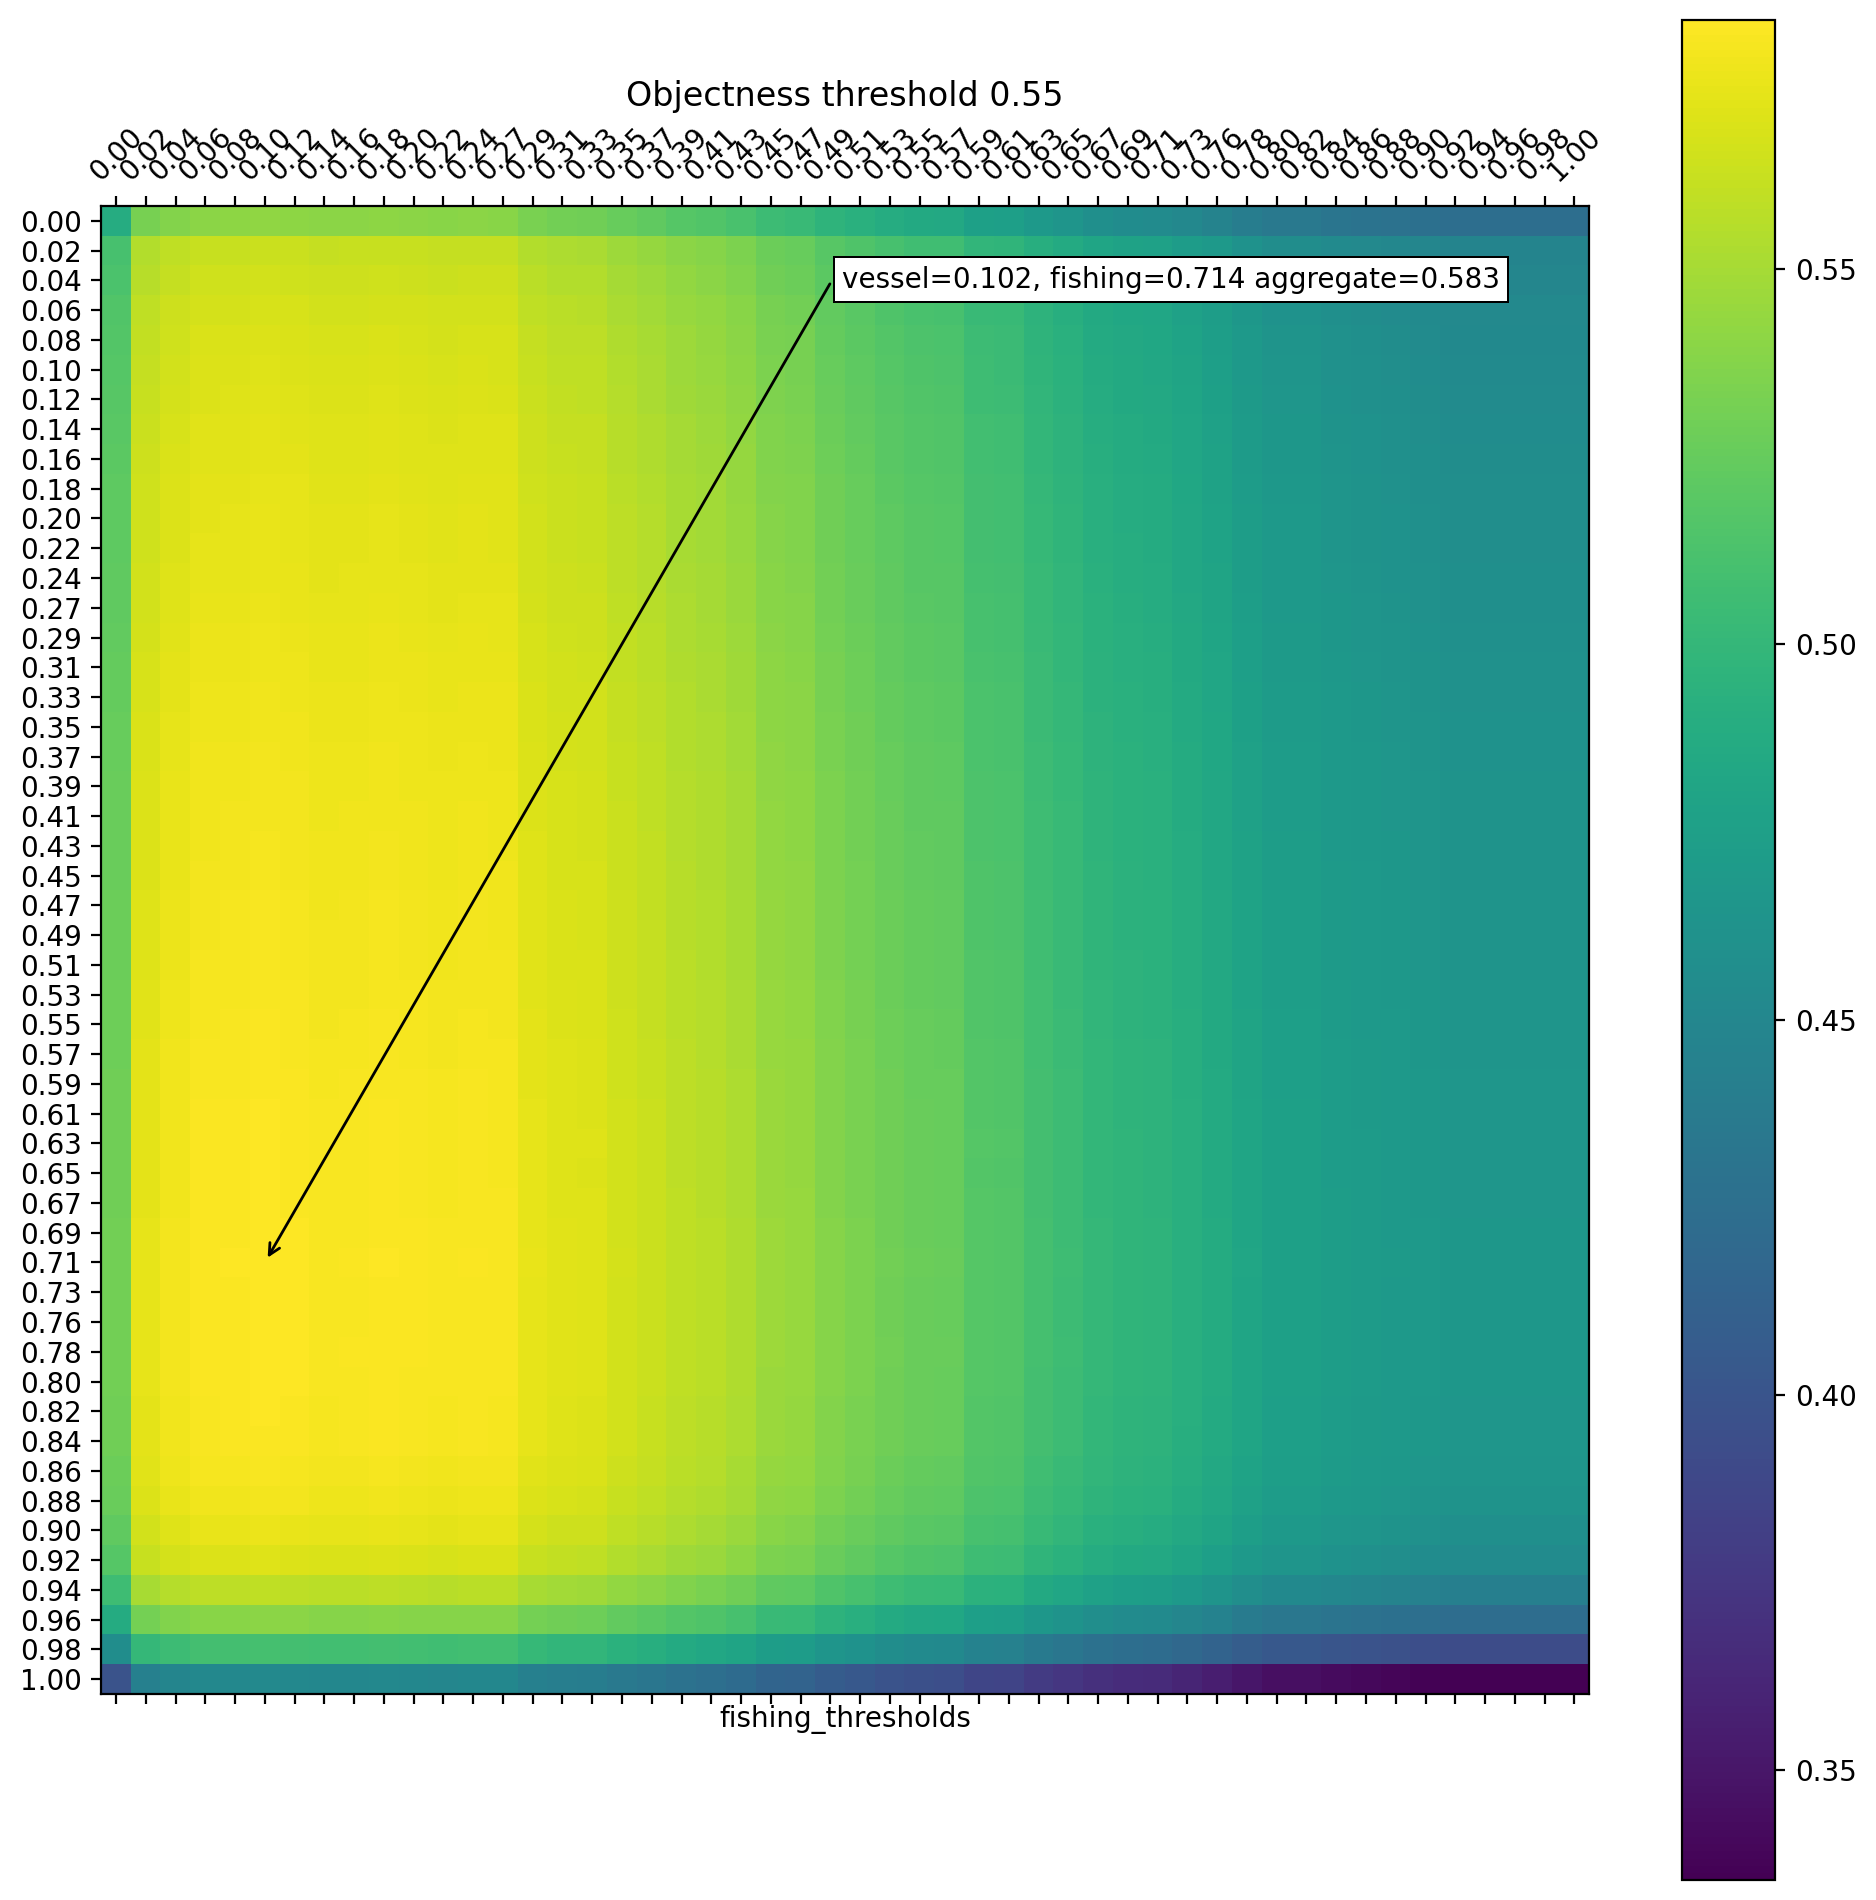

loc_fscore  loc_fscore_shore  vessel_fscore  fishing_fscore  length_acc  \
1755    0.798902          0.470016       0.880092        0.725389    0.631419   
1705    0.798902          0.470016       0.879330        0.725389    0.631419   
1805    0.798902          0.470016       0.879257        0.725389    0.631419   
1753    0.798902          0.470016       0.880092        0.723898    0.631419   
1855    0.798902          0.470016       0.878468        0.725389    0.631419   
1703    0.798902          0.470016       0.879330        0.723898    0.631419   
1803    0.798902          0.470016       0.879257        0.723898    0.631419   
1555    0.798902          0.470016       0.877285        0.725389    0.631419   
1655    0.798902          0.470016       0.877219        0.725389    0.631419   
1853    0.798902          0.470016       0.878468        0.723898    0.631419   
1905    0.798902          0.470016       0.876875        0.725389    0.631419   
1955    0.798902          0.470016       0.876647        0.725389    0.631419   
1505    0.798902          0.470016       0.876529        0.725389    0.631419   
1605    0.798902          0.470016       0.876362        0.725389    0.631419   
1756    0.798902          0.470016       0.880092        0.721485    0.631419   
1553    0.798902          0.470016       0.877285        0.723898    0.631419   
1653    0.798902          0.470016       0.877219        0.723898    0.631419   
1706    0.798902          0.470016       0.879330        0.721485    0.631419   
1903    0.798902          0.470016       0.876875        0.723898    0.631419   
1806    0.798902          0.470016       0.879257        0.721485    0.631419   

      aggregate  is_vessel_threshold  is_fishing_threshold  \
1755   0.592293             0.714286              0.102041   
1705   0.592171             0.693878              0.102041   
1805   0.592159             0.734694              0.102041   
1753   0.592054             0.714286              0.061224   
1855   0.592033             0.755102              0.102041   
1703   0.591933             0.693878              0.061224   
1803   0.591921             0.734694              0.061224   
1555   0.591844             0.632653              0.102041   
1655   0.591834             0.673469              0.102041   
1853   0.591795             0.755102              0.061224   
1905   0.591778             0.775510              0.102041   
1955   0.591742             0.795918              0.102041   
1505   0.591723             0.612245              0.102041   
1605   0.591697             0.653061              0.102041   
1756   0.591669             0.714286              0.122449   
1553   0.591606             0.632653              0.061224   
1653   0.591595             0.673469              0.061224   
1706   0.591547             0.693878              0.122449   
1903   0.591540             0.775510              0.061224   
1806   0.591535             0.734694              0.122449   

      objectness_threshold  
1755                   0.5  
1705                   0.5  
1805                   0.5  
1753                   0.5  
1855                   0.5  
1703                   0.5  
1803                   0.5  
1555                   0.5  
1655                   0.5  
1853                   0.5  
1905                   0.5  
1955                   0.5  
1505                   0.5  
1605                   0.5  
1756                   0.5  
1553                   0.5  
1653                   0.5  
1706                   0.5  
1903                   0.5  
1806                   0.5

In [26]:
vanilla_box_coder = MultilabelCircleNetCoder(
    (2048,2048), output_stride=4, max_objects=2048, heatmap_encoding="umich", labels_encoding="circle", ignore_value=IGNORE_LABEL,
    fixed_radius=3,
    labels_radius=3,
    nms_method=centernet_tight_heatmap_nms,
    nms_kernel_size=5)

vanilla_predictions = decode_predictions(predicted_scenes_paths, vanilla_box_coder)
centernet_tight_heatmap_nms_ks_5 = compute_optimal_thresholds(
    predictions=vanilla_predictions,
    groundtruths=groundtruth,
    shore_root=shore_root,
    objectness_thresholds=objectness_thresholds,
)
centernet_tight_heatmap_nms_ks_5.to_csv("centernet_tight_heatmap_nms_ks_5", index=False)
plot_visualizations(centernet_tight_heatmap_nms_ks_5)
centernet_tight_heatmap_nms_ks_5.head(20)